In [1]:
# Cell 1: imports, reproducibility, and Torch device

import os
import random
from typing import Sequence, Tuple

import numpy as np
import torch
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms

# ---------- Reproducibility ----------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# ---------- Torch device (GPU if available) ----------
if torch.cuda.is_available():
    torch_device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(0)
else:
    torch_device = torch.device("cpu")
    device_name = "CPU"

print(f"Torch device: {torch_device} ({device_name})")

# ---------- Global training hyperparameters ----------
BATCH_SIZE_CLASSICAL = 128      # for classical models
BATCH_SIZE_QUANTUM = 16         # for quantum/hybrid models
NUM_WORKERS = 2                 # dataloader workers (keep modest)

# For fast experiments first; we can increase later
MAX_TRAIN_SAMPLES = 5000        # None = full MNIST train
MAX_TEST_SAMPLES = 2000         # None = full MNIST test

DATA_ROOT = "./data"            # where MNIST will be downloaded

print("Global config set.")


Torch device: cpu (CPU)
Global config set.


In [2]:
# Cell 2: PennyLane setup and quantum device factory

import pennylane as qml

print("PennyLane version:", qml.__version__)

def make_qdevice(
    n_wires: int,
    use_gpu: bool = False,
    shots: int | None = None,
):
    """
    Create a PennyLane Lightning device.

    Parameters
    ----------
    n_wires : int
        Number of qubits.
    use_gpu : bool
        False -> 'lightning.qubit'
        True  -> 'lightning.gpu' (requires proper CUDA + plugin install)
    shots : int or None
        None -> analytic mode (exact expectations, good for training)
        int  -> finite-shot sampling mode
    """
    dev_name = "lightning.gpu" if use_gpu else "lightning.qubit"

    dev = qml.device(
        dev_name,
        wires=n_wires,
        shots=shots,
    )
    return dev

# Quick sanity check: 4-qubit CPU device in analytic mode
dev_test = make_qdevice(4, use_gpu=False, shots=None)
print("Example CPU quantum device:", dev_test)


PennyLane version: 0.43.1
Example CPU quantum device: <lightning.qubit device (wires=4) at 0x7e082b2effb0>


In [3]:
# Cell 3: MNIST datasets (28×28 and 8×8 versions)

from torchvision import datasets, transforms

# Standard MNIST normalization
MNIST_MEAN = (0.1307,)
MNIST_STD = (0.3081,)

# ---- 28×28 original MNIST ----
transform_28 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MNIST_MEAN, MNIST_STD),
])

# ---- 8×8 downsampled version (for quantum) ----
transform_8 = transforms.Compose([
    transforms.Resize((8, 8)),
    transforms.ToTensor(),
    transforms.Normalize(MNIST_MEAN, MNIST_STD),
])

# ---- Download / Load ----
full_train_28 = datasets.MNIST(
    root=DATA_ROOT, train=True, download=True, transform=transform_28
)
full_test_28 = datasets.MNIST(
    root=DATA_ROOT, train=False, download=True, transform=transform_28
)

full_train_8 = datasets.MNIST(
    root=DATA_ROOT, train=True, download=False, transform=transform_8
)
full_test_8 = datasets.MNIST(
    root=DATA_ROOT, train=False, download=False, transform=transform_8
)

print("Loaded MNIST.")
print("28×28 train:", len(full_train_28))
print(" 8×8 train:", len(full_train_8))

# ---- Trim datasets for fast quantum tests ----
def trim_dataset(dataset, max_samples: int | None):
    if max_samples is None or max_samples >= len(dataset):
        return dataset
    indices = list(range(max_samples))
    return Subset(dataset, indices)

train_28 = trim_dataset(full_train_28, MAX_TRAIN_SAMPLES)
test_28 = trim_dataset(full_test_28, MAX_TEST_SAMPLES)

train_8 = trim_dataset(full_train_8, MAX_TRAIN_SAMPLES)
test_8 = trim_dataset(full_test_8, MAX_TEST_SAMPLES)

print("Using train_28:", len(train_28))
print("Using train_8 :", len(train_8))
print("Using test_28 :", len(test_28))
print("Using test_8  :", len(test_8))


100%|██████████████████████████████████████| 9.91M/9.91M [00:07<00:00, 1.38MB/s]
100%|███████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 225kB/s]
100%|██████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 1.62MB/s]
100%|███████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 654kB/s]

Loaded MNIST.
28×28 train: 60000
 8×8 train: 60000
Using train_28: 5000
Using train_8 : 5000
Using test_28 : 2000
Using test_8  : 2000


In [4]:
# Cell 4: Filter MNIST for binary tasks (e.g., digits 0 vs 1)

def filter_digits(dataset, allowed_digits: Sequence[int]):
    """
    Return indices of samples whose labels match allowed_digits.
    Handles both full MNIST and Subset versions.
    """
    if isinstance(dataset, Subset):
        base_ds = dataset.dataset
        base_indices = dataset.indices
        targets = base_ds.targets[base_indices]
        indices = [
            base_indices[i]
            for i, t in enumerate(targets)
            if int(t.item()) in allowed_digits
        ]
    else:
        targets = dataset.targets
        indices = [
            i for i, t in enumerate(targets)
            if int(t.item()) in allowed_digits
        ]
    return indices

print("Digit filtering utility ready.")


Digit filtering utility ready.


In [5]:
# Cell 5: Build DataLoaders for binary MNIST tasks

def make_binary_loaders(
    digits: Tuple[int, int] = (0, 1),
    image_size: str = "8x8",
    batch_size_classical: int = BATCH_SIZE_CLASSICAL,
    batch_size_quantum: int = BATCH_SIZE_QUANTUM,
    val_split: float = 0.2,
):
    """
    Create DataLoaders for a binary classification task on MNIST.

    Parameters
    ----------
    digits : (int, int)
        The two digit labels to keep, e.g. (0, 1) or (3, 8).
    image_size : str
        '8x8'  -> use downsampled images (for quantum experiments)
        '28x28' -> use original images (for CNN / hybrid later)
    """

    assert image_size in ("8x8", "28x28")

    # Choose base dataset version
    if image_size == "8x8":
        train_base = train_8
        test_base = test_8
    else:
        train_base = train_28
        test_base = test_28

    # Filter indices for chosen digits
    train_indices = filter_digits(train_base, digits)
    test_indices = filter_digits(test_base, digits)

    train_bin = Subset(train_base, train_indices)
    test_bin = Subset(test_base, test_indices)

    # Train / validation split
    n_train = len(train_bin)
    n_val = int(val_split * n_train)
    n_train_final = n_train - n_val

    train_bin_ds, val_bin_ds = random_split(
        train_bin,
        [n_train_final, n_val],
        generator=torch.Generator().manual_seed(SEED),
    )

    # Classical loaders (larger batches)
    train_loader_classical = DataLoader(
        train_bin_ds,
        batch_size=batch_size_classical,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=(torch_device.type == "cuda"),
    )

    val_loader_classical = DataLoader(
        val_bin_ds,
        batch_size=batch_size_classical,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=(torch_device.type == "cuda"),
    )

    # Quantum loaders (smaller batches)
    train_loader_quantum = DataLoader(
        train_bin_ds,
        batch_size=batch_size_quantum,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=(torch_device.type == "cuda"),
    )

    val_loader_quantum = DataLoader(
        val_bin_ds,
        batch_size=batch_size_quantum,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=(torch_device.type == "cuda"),
    )

    test_loader = DataLoader(
        test_bin,
        batch_size=batch_size_classical,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=(torch_device.type == "cuda"),
    )

    print(
        f"Binary task {digits}, {image_size}: "
        f"train={n_train_final}, val={n_val}, test={len(test_bin)}"
    )

    return {
        "train_classical": train_loader_classical,
        "val_classical": val_loader_classical,
        "train_quantum": train_loader_quantum,
        "val_quantum": val_loader_quantum,
        "test": test_loader,
        "digits": digits,
        "image_size": image_size,
    }

print("Binary DataLoader factory ready.")


Binary DataLoader factory ready.


In [6]:
# Cell 6: Example binary task – digits 0 vs 1, 8×8 images

binary_loaders_01_8 = make_binary_loaders(
    digits=(0, 1),
    image_size="8x8",
)

# Quick sanity check: one batch
batch = next(iter(binary_loaders_01_8["train_classical"]))
images, labels = batch
print("Batch images shape:", images.shape)   # [B, 1, 8, 8]
print("Batch labels shape:", labels.shape)
print("Unique labels in batch:", labels.unique().tolist())


Binary task (0, 1), 8x8: train=834, val=208, test=409
Batch images shape: torch.Size([128, 1, 8, 8])
Batch labels shape: torch.Size([128])
Unique labels in batch: [0, 1]


In [7]:
# Cell 7: Simple logistic regression classifier for the 8×8 binary task

import torch.nn as nn

class LogisticClassifier(nn.Module):
    def __init__(self, input_dim=64):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        # Flatten: (B, 1, 8, 8) → (B, 64)
        x = x.view(x.size(0), -1)
        return self.linear(x).squeeze(-1)


In [8]:
# Cell 8: Training + validation for logistic baseline

import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

def train_logistic(
    model,
    train_loader,
    val_loader,
    epochs=5,
    lr=1e-2,
):
    model = model.to(torch_device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for x, y in tqdm(train_loader, desc=f"Epoch {epoch}"):
            x = x.to(torch_device)
            y = y.float().to(torch_device)

            logits = model(x)
            loss = loss_fn(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)
            preds = (torch.sigmoid(logits) > 0.5).long()
            correct += (preds.cpu() == y.cpu().long()).sum().item()
            total += x.size(0)

        train_acc = correct / total

        # ----- validation -----
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(torch_device)
                y = y.to(torch_device)

                preds = (torch.sigmoid(model(x)) > 0.5).long()
                val_correct += (preds.cpu() == y.cpu()).sum().item()
                val_total += x.size(0)

        val_acc = val_correct / val_total

        print(f"Epoch {epoch}:  train_acc={train_acc:.4f},  val_acc={val_acc:.4f}")

    return model


In [9]:
logistic = LogisticClassifier()
trained_logistic = train_logistic(
    logistic,
    binary_loaders_01_8["train_classical"],
    binary_loaders_01_8["val_classical"],
    epochs=5,
    lr=1e-2,
)


Epoch 1: 100%|████████████████████████████████████| 7/7 [00:00<00:00, 52.99it/s]


Epoch 1:  train_acc=0.7998,  val_acc=0.9856


Epoch 2: 100%|████████████████████████████████████| 7/7 [00:00<00:00, 33.86it/s]


Epoch 2:  train_acc=0.9832,  val_acc=0.9952


Epoch 3: 100%|████████████████████████████████████| 7/7 [00:00<00:00, 34.18it/s]


Epoch 3:  train_acc=0.9844,  val_acc=0.9904


Epoch 4: 100%|████████████████████████████████████| 7/7 [00:00<00:00, 41.21it/s]


Epoch 4:  train_acc=0.9832,  val_acc=0.9952


Epoch 5: 100%|████████████████████████████████████| 7/7 [00:00<00:00, 43.25it/s]


Epoch 5:  train_acc=0.9856,  val_acc=0.9952


### PCA Feature Reduction for Quantum Input

We reduce each 8×8 image (64 features) → 4 principal components.
This keeps quantum circuits lightweight and fast.

In [10]:
# Cell 9: PCA to reduce 8×8 images to a small number of features

from sklearn.decomposition import PCA

# Flatten all training images (subset) into numpy vectors
def extract_flat_features(dataloader):
    X = []
    y = []
    for imgs, labels in dataloader:
        imgs = imgs.view(imgs.size(0), -1).numpy()
        X.append(imgs)
        y.append(labels.numpy())
    return np.vstack(X), np.hstack(y)

# Use classical loader (bigger batch, faster)
X_train_flat, y_train_flat = extract_flat_features(binary_loaders_01_8["train_classical"])
X_val_flat,   y_val_flat   = extract_flat_features(binary_loaders_01_8["val_classical"])

# Fit PCA to training features only
pca_components = 4
pca = PCA(n_components=pca_components)
pca.fit(X_train_flat)

# Transform train and validation sets
X_train_pca = pca.transform(X_train_flat)
X_val_pca   = pca.transform(X_val_flat)

print("PCA ready.")
print("Input dimension:", X_train_flat.shape[1], "→", pca_components)
print("Train PCA shape:", X_train_pca.shape)
print("Val PCA shape:", X_val_pca.shape)


PCA ready.
Input dimension: 64 → 4
Train PCA shape: (834, 4)
Val PCA shape: (208, 4)


In [11]:
# NEW Cell 10: Quantum circuit QNode WITHOUT TorchLayer

import pennylane as qml
import torch
import torch.nn as nn

n_qubits = 4

dev = make_qdevice(
    n_wires=n_qubits,
    use_gpu=False,   # GPU later if you want
    shots=None       # analytic mode
)

@qml.qnode(dev, interface="torch")
def vqc_circuit(inputs, weights):
    """
    inputs: 1D tensor of length 4 (PCA features)
    weights: 1D tensor of length 4 (trainable params)
    """
    # ----- Data encoding -----
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    # ----- Entangling layer -----
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i + 1) % n_qubits])

    # ----- Trainable layer -----
    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)

    return qml.expval(qml.PauliZ(0))

print("Manual QNode vqc_circuit ready.")


Manual QNode vqc_circuit ready.


### Build Hybrid QNN Model in PyTorch

In [12]:
# NEW Cell 11: Hybrid QNN that calls vqc_circuit manually

import torch.nn as nn

class HybridQNN(nn.Module):
    def __init__(self, input_dim=4):
        super().__init__()
        # Quantum parameters live as a trainable torch Parameter
        self.q_weights = nn.Parameter(0.01 * torch.randn(n_qubits))
        self.fc_out = nn.Linear(1, 1)

    def forward(self, x_pca):
        """
        x_pca: tensor [B, 4] of PCA features
        We call the QNode once per sample and stack results.
        """
        x_pca = x_pca.to(torch_device).float()

        outputs = []
        for i in range(x_pca.shape[0]):
            out = vqc_circuit(x_pca[i], self.q_weights)  # scalar
            outputs.append(out)

        q_out = torch.stack(outputs).unsqueeze(-1)  # [B, 1]
        logits = self.fc_out(q_out).squeeze(-1)     # [B]
        return logits


## Prepare Training Data for the Quantum Model

In [13]:
# Cell 12: Convert PCA outputs + labels into Torch datasets for QNN

import torch

# Convert PCA arrays -> torch tensors
X_train_q = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_q = torch.tensor(y_train_flat, dtype=torch.float32)

X_val_q   = torch.tensor(X_val_pca, dtype=torch.float32)
y_val_q   = torch.tensor(y_val_flat, dtype=torch.float32)

print("Quantum PCA tensors ready.")
print("Train PCA:", X_train_q.shape, "Labels:", y_train_q.shape)
print("Val PCA:",   X_val_q.shape,   "Labels:", y_val_q.shape)


Quantum PCA tensors ready.
Train PCA: torch.Size([834, 4]) Labels: torch.Size([834])
Val PCA: torch.Size([208, 4]) Labels: torch.Size([208])


## Quantum DataLoaders from PCA features

In [14]:
# Cell 13: Build DataLoaders for the PCA-based quantum model

from torch.utils.data import TensorDataset, DataLoader

train_dataset_q = TensorDataset(X_train_q, y_train_q)
val_dataset_q   = TensorDataset(X_val_q,   y_val_q)

train_loader_q = DataLoader(
    train_dataset_q,
    batch_size=BATCH_SIZE_QUANTUM,
    shuffle=True,
    num_workers=NUM_WORKERS,
    drop_last=True,  # IMPORTANT
)

val_loader_q = DataLoader(
    val_dataset_q,
    batch_size=BATCH_SIZE_QUANTUM,
    shuffle=False,
    num_workers=NUM_WORKERS,
    drop_last=True,  # IMPORTANT
)


print("Quantum DataLoaders ready.")
print("Train batches:", len(train_loader_q), " Val batches:", len(val_loader_q))


Quantum DataLoaders ready.
Train batches: 52  Val batches: 13


## Train the Hybrid Quantum Model

In [15]:
# Cell 14: Training loop for HybridQNN (PCA -> VQC -> Linear)

import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

def train_hybrid_qnn(
    model,
    train_loader,
    val_loader,
    epochs=10,
    lr=5e-3,
):
    model = model.to(torch_device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()

    for epoch in range(1, epochs + 1):
        # ----- training -----
        model.train()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch} (train)"):
            x_batch = x_batch.to(torch_device)
            y_batch = y_batch.to(torch_device)

            logits = model(x_batch)
            loss = loss_fn(logits, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x_batch.size(0)
            preds = (torch.sigmoid(logits) > 0.5).long()
            total_correct += (preds == y_batch.long()).sum().item()
            total_samples += x_batch.size(0)

        train_loss = total_loss / total_samples
        train_acc = total_correct / total_samples

        # ----- validation -----
        model.eval()
        val_correct = 0
        val_samples = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.to(torch_device)
                y_val = y_val.to(torch_device)

                logits_val = model(x_val)
                preds_val = (torch.sigmoid(logits_val) > 0.5).long()
                val_correct += (preds_val == y_val.long()).sum().item()
                val_samples += x_val.size(0)

        val_acc = val_correct / val_samples

        print(
            f"Epoch {epoch}: "
            f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
            f"val_acc={val_acc:.4f}"
        )

    return model


# Instantiate and train the hybrid quantum model
hybrid_model = HybridQNN()   # <-- no qlayer argument
hybrid_model = train_hybrid_qnn(
    hybrid_model,
    train_loader_q,
    val_loader_q,
    epochs=10,
    lr=5e-3,
)



Epoch 1 (train): 100%|██████████████████████████| 52/52 [00:03<00:00, 16.99it/s]


Epoch 1: train_loss=0.8054, train_acc=0.4579, val_acc=0.4519


Epoch 2 (train): 100%|██████████████████████████| 52/52 [00:03<00:00, 17.26it/s]


Epoch 2: train_loss=0.7559, train_acc=0.4591, val_acc=0.4615


Epoch 3 (train): 100%|██████████████████████████| 52/52 [00:03<00:00, 15.88it/s]


Epoch 3: train_loss=0.7254, train_acc=0.4507, val_acc=0.4615


Epoch 4 (train): 100%|██████████████████████████| 52/52 [00:02<00:00, 20.49it/s]


Epoch 4: train_loss=0.7081, train_acc=0.4315, val_acc=0.4615


Epoch 5 (train): 100%|██████████████████████████| 52/52 [00:02<00:00, 17.71it/s]


Epoch 5: train_loss=0.6980, train_acc=0.4615, val_acc=0.5000


Epoch 6 (train): 100%|██████████████████████████| 52/52 [00:02<00:00, 19.35it/s]


Epoch 6: train_loss=0.6928, train_acc=0.5240, val_acc=0.5481


Epoch 7 (train): 100%|██████████████████████████| 52/52 [00:03<00:00, 16.18it/s]


Epoch 7: train_loss=0.6896, train_acc=0.5373, val_acc=0.5481


Epoch 8 (train): 100%|██████████████████████████| 52/52 [00:03<00:00, 17.30it/s]


Epoch 8: train_loss=0.6874, train_acc=0.5397, val_acc=0.5481


Epoch 9 (train): 100%|██████████████████████████| 52/52 [00:03<00:00, 16.93it/s]


Epoch 9: train_loss=0.6864, train_acc=0.5445, val_acc=0.5481


Epoch 10 (train): 100%|█████████████████████████| 52/52 [00:02<00:00, 22.00it/s]


Epoch 10: train_loss=0.6852, train_acc=0.5493, val_acc=0.5288


In [16]:
# Cell 15: Training functions that record history (for plots)

import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

def train_logistic_with_history(
    model,
    train_loader,
    val_loader,
    epochs=5,
    lr=1e-2,
):
    model = model.to(torch_device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_acc": [],
    }

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        for x, y in tqdm(train_loader, desc=f"[Logistic] Epoch {epoch}"):
            x = x.to(torch_device)
            y = y.float().to(torch_device)

            logits = model(x)
            loss = loss_fn(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)
            preds = (torch.sigmoid(logits) > 0.5).long()
            total_correct += (preds == y.long()).sum().item()
            total_samples += x.size(0)

        train_loss = total_loss / total_samples
        train_acc = total_correct / total_samples

        # ----- validation -----
        model.eval()
        val_correct = 0
        val_samples = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.to(torch_device)
                y_val = y_val.to(torch_device)

                logits_val = model(x_val)
                preds_val = (torch.sigmoid(logits_val) > 0.5).long()
                val_correct += (preds_val == y_val.long()).sum().item()
                val_samples += x_val.size(0)

        val_acc = val_correct / val_samples

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(
            f"[Logistic] Epoch {epoch}: "
            f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
            f"val_acc={val_acc:.4f}"
        )

    return model, history


def train_hybrid_qnn_with_history(
    model,
    train_loader,
    val_loader,
    epochs=10,
    lr=5e-3,
):
    model = model.to(torch_device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_acc": [],
    }

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        for x_batch, y_batch in tqdm(train_loader, desc=f"[Hybrid] Epoch {epoch}"):
            x_batch = x_batch.to(torch_device)
            y_batch = y_batch.float().to(torch_device)     # <--- FIX


            logits = model(x_batch)
            loss = loss_fn(logits, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x_batch.size(0)
            preds = (torch.sigmoid(logits) > 0.5).long()
            total_correct += (preds == y_batch.long()).sum().item()
            total_samples += x_batch.size(0)

        train_loss = total_loss / total_samples
        train_acc = total_correct / total_samples

        # ----- validation -----
        model.eval()
        val_correct = 0
        val_samples = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.to(torch_device)
                y_val = y_val.float().to(torch_device)         # <--- FIX


                logits_val = model(x_val)
                preds_val = (torch.sigmoid(logits_val) > 0.5).long()
                val_correct += (preds_val == y_val.long()).sum().item()
                val_samples += x_val.size(0)

        val_acc = val_correct / val_samples

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(
            f"[Hybrid] Epoch {epoch}: "
            f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
            f"val_acc={val_acc:.4f}"
        )

    return model, history


In [17]:
# Cell 16: Retrain logistic baseline with history

logistic2 = LogisticClassifier()
logistic2, hist_logistic = train_logistic_with_history(
    logistic2,
    binary_loaders_01_8["train_classical"],
    binary_loaders_01_8["val_classical"],
    epochs=5,
    lr=1e-2,
)

print("Logistic history keys:", hist_logistic.keys())


[Logistic] Epoch 1: 100%|█████████████████████████| 7/7 [00:00<00:00, 39.92it/s]


[Logistic] Epoch 1: train_loss=0.4302, train_acc=0.9376, val_acc=0.9952


[Logistic] Epoch 2: 100%|█████████████████████████| 7/7 [00:00<00:00, 30.03it/s]


[Logistic] Epoch 2: train_loss=0.2183, train_acc=0.9844, val_acc=0.9952


[Logistic] Epoch 3: 100%|█████████████████████████| 7/7 [00:00<00:00, 27.47it/s]


[Logistic] Epoch 3: train_loss=0.1289, train_acc=0.9820, val_acc=0.9952


[Logistic] Epoch 4: 100%|█████████████████████████| 7/7 [00:00<00:00, 36.20it/s]


[Logistic] Epoch 4: train_loss=0.0911, train_acc=0.9844, val_acc=0.9952


[Logistic] Epoch 5: 100%|█████████████████████████| 7/7 [00:00<00:00, 23.95it/s]


[Logistic] Epoch 5: train_loss=0.0713, train_acc=0.9892, val_acc=0.9952
Logistic history keys: dict_keys(['train_loss', 'train_acc', 'val_acc'])


[Hybrid] Epoch 1: 100%|█████████████████████████| 52/52 [00:02<00:00, 18.48it/s]


[Hybrid] Epoch 1: train_loss=0.7919, train_acc=0.4627, val_acc=0.4519


[Hybrid] Epoch 2: 100%|█████████████████████████| 52/52 [00:01<00:00, 36.59it/s]


[Hybrid] Epoch 2: train_loss=0.7464, train_acc=0.4688, val_acc=0.4712


[Hybrid] Epoch 3: 100%|█████████████████████████| 52/52 [00:01<00:00, 28.83it/s]


[Hybrid] Epoch 3: train_loss=0.7173, train_acc=0.5096, val_acc=0.4712


[Hybrid] Epoch 4: 100%|█████████████████████████| 52/52 [00:02<00:00, 19.20it/s]


[Hybrid] Epoch 4: train_loss=0.7016, train_acc=0.5096, val_acc=0.4904


[Hybrid] Epoch 5: 100%|█████████████████████████| 52/52 [00:02<00:00, 18.49it/s]


[Hybrid] Epoch 5: train_loss=0.6922, train_acc=0.5252, val_acc=0.5048


[Hybrid] Epoch 6: 100%|█████████████████████████| 52/52 [00:02<00:00, 17.97it/s]


[Hybrid] Epoch 6: train_loss=0.6879, train_acc=0.5312, val_acc=0.5096


[Hybrid] Epoch 7: 100%|█████████████████████████| 52/52 [00:03<00:00, 15.74it/s]


[Hybrid] Epoch 7: train_loss=0.6851, train_acc=0.5337, val_acc=0.5048


[Hybrid] Epoch 8: 100%|█████████████████████████| 52/52 [00:03<00:00, 16.49it/s]


[Hybrid] Epoch 8: train_loss=0.6838, train_acc=0.5204, val_acc=0.5048


[Hybrid] Epoch 9: 100%|█████████████████████████| 52/52 [00:03<00:00, 15.70it/s]


[Hybrid] Epoch 9: train_loss=0.6835, train_acc=0.5300, val_acc=0.5288


[Hybrid] Epoch 10: 100%|████████████████████████| 52/52 [00:03<00:00, 16.08it/s]


[Hybrid] Epoch 10: train_loss=0.6833, train_acc=0.5325, val_acc=0.5433


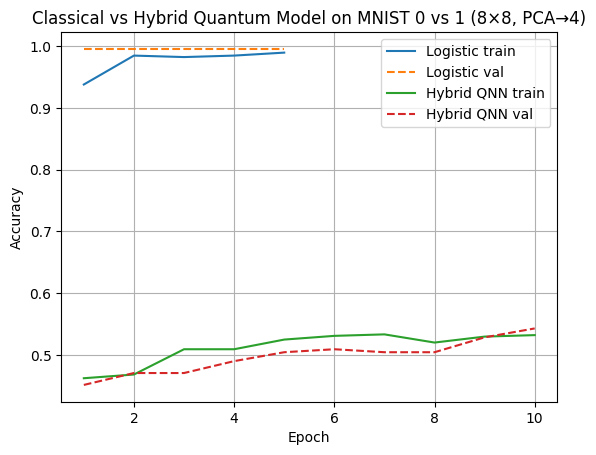

In [18]:
# Cell 17: Retrain hybrid QNN, then visualize vs logistic baseline

import matplotlib.pyplot as plt

# Retrain hybrid model with history
hybrid2 = HybridQNN()
hybrid2, hist_hybrid = train_hybrid_qnn_with_history(
    hybrid2,
    train_loader_q,
    val_loader_q,
    epochs=10,
    lr=5e-3,
)

# ------ Visualization ------

epochs_log = range(1, len(hist_logistic["train_acc"]) + 1)
epochs_hyb = range(1, len(hist_hybrid["train_acc"]) + 1)

plt.figure()
plt.plot(epochs_log, hist_logistic["train_acc"], label="Logistic train")
plt.plot(epochs_log, hist_logistic["val_acc"], linestyle="--", label="Logistic val")

plt.plot(epochs_hyb, hist_hybrid["train_acc"], label="Hybrid QNN train")
plt.plot(epochs_hyb, hist_hybrid["val_acc"], linestyle="--", label="Hybrid QNN val")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Classical vs Hybrid Quantum Model on MNIST 0 vs 1 (8×8, PCA→4)")
plt.legend()
plt.grid(True)
plt.show()


## NEXT PHASE: Build a more expressive quantum model

### Upgrade A — Multi-layer VQC (L = 3)

#### New multi-layer quantum circuit

In [19]:
# Cell 18: Multi-layer VQC (L=3) with many more weights

import torch
import torch.nn as nn
import pennylane as qml

n_qubits = 4
n_layers = 3
n_weights = n_qubits * n_layers    # 4 qubits * 3 layers = 12 parameters

dev = make_qdevice(
    n_wires=n_qubits,
    use_gpu=False,
    shots=None
)

@qml.qnode(dev, interface="torch")
def vqc_deep(inputs, weights):
    """
    inputs: [4]
    weights: [12]
    Structure:
        encode → (RY+entangle)*3 → expval
    """
    # Encoding
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    # Layers
    idx = 0
    for layer in range(n_layers):
        # Trainable rotations
        for i in range(n_qubits):
            qml.RY(weights[idx], wires=i)
            idx += 1

        # Entanglement ring
        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + 1) % n_qubits])

    return qml.expval(qml.PauliZ(0))

print("Deep VQC (L=3) ready. Total params:", n_weights)


Deep VQC (L=3) ready. Total params: 12


### HybridQNN updated to use new VQC

In [20]:
# Cell 19: Hybrid model using the deeper VQC

class HybridQNN_Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.q_weights = nn.Parameter(0.01 * torch.randn(n_weights))
        self.fc_out = nn.Linear(1, 1)

    def forward(self, x_pca):
        outputs = []
        for i in range(x_pca.shape[0]):
            out = vqc_deep(x_pca[i], self.q_weights)
            outputs.append(out)

        q_out = torch.stack(outputs).unsqueeze(-1)
        logits = self.fc_out(q_out).squeeze(-1)
        return logits


In [21]:
model_deep = HybridQNN_Deep()
model_deep, hist_deep = train_hybrid_qnn_with_history(
    model_deep,
    train_loader_q,
    val_loader_q,
    epochs=10,
    lr=5e-3,
)


[Hybrid] Epoch 1: 100%|█████████████████████████| 52/52 [00:04<00:00, 11.96it/s]


[Hybrid] Epoch 1: train_loss=0.6614, train_acc=0.6334, val_acc=0.6587


[Hybrid] Epoch 2: 100%|█████████████████████████| 52/52 [00:03<00:00, 13.96it/s]


[Hybrid] Epoch 2: train_loss=0.6322, train_acc=0.6899, val_acc=0.6875


[Hybrid] Epoch 3: 100%|█████████████████████████| 52/52 [00:04<00:00, 12.90it/s]


[Hybrid] Epoch 3: train_loss=0.6050, train_acc=0.7151, val_acc=0.7212


[Hybrid] Epoch 4: 100%|█████████████████████████| 52/52 [00:05<00:00, 10.16it/s]


[Hybrid] Epoch 4: train_loss=0.5748, train_acc=0.7332, val_acc=0.7356


[Hybrid] Epoch 5: 100%|█████████████████████████| 52/52 [00:03<00:00, 13.45it/s]


[Hybrid] Epoch 5: train_loss=0.5462, train_acc=0.7608, val_acc=0.7644


[Hybrid] Epoch 6: 100%|█████████████████████████| 52/52 [00:03<00:00, 17.09it/s]


[Hybrid] Epoch 6: train_loss=0.5213, train_acc=0.7728, val_acc=0.7692


[Hybrid] Epoch 7: 100%|█████████████████████████| 52/52 [00:02<00:00, 20.32it/s]


[Hybrid] Epoch 7: train_loss=0.4983, train_acc=0.7837, val_acc=0.7740


[Hybrid] Epoch 8: 100%|█████████████████████████| 52/52 [00:02<00:00, 19.52it/s]


[Hybrid] Epoch 8: train_loss=0.4775, train_acc=0.8005, val_acc=0.7981


[Hybrid] Epoch 9: 100%|█████████████████████████| 52/52 [00:03<00:00, 15.11it/s]


[Hybrid] Epoch 9: train_loss=0.4570, train_acc=0.8245, val_acc=0.8558


[Hybrid] Epoch 10: 100%|████████████████████████| 52/52 [00:04<00:00, 10.95it/s]


[Hybrid] Epoch 10: train_loss=0.4410, train_acc=0.8498, val_acc=0.8894


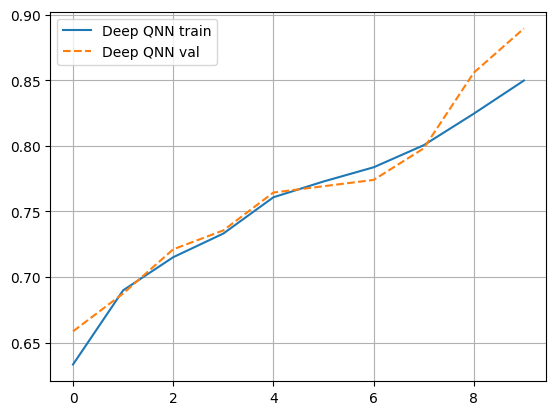

In [22]:
plt.figure()
plt.plot(hist_deep["train_acc"], label="Deep QNN train")
plt.plot(hist_deep["val_acc"], '--', label="Deep QNN val")
plt.legend(); plt.grid(); plt.show()


PCA(8) ready.
Input dim: 64 -> 8
Train PCA8 shape: (834, 8)
Val PCA8 shape: (208, 8)


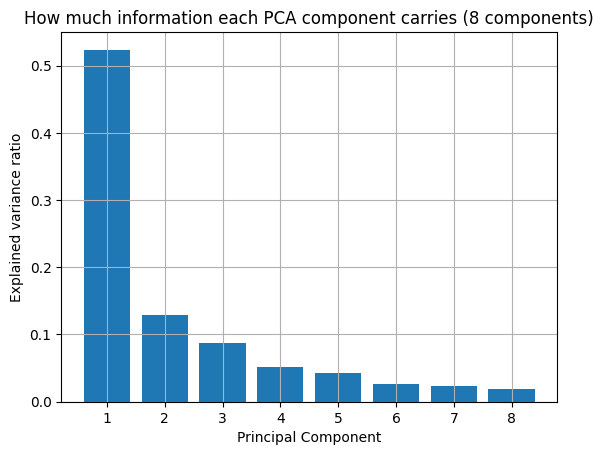

Total variance captured: 0.90231997


In [23]:
# Cell 20: PCA with 8 components + explained-variance plot

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reuse the flat features you already built earlier
# X_train_flat, y_train_flat, X_val_flat, y_val_flat

pca8_components = 8
pca8 = PCA(n_components=pca8_components)
pca8.fit(X_train_flat)

X_train_pca8 = pca8.transform(X_train_flat)
X_val_pca8   = pca8.transform(X_val_flat)

print("PCA(8) ready.")
print("Input dim:", X_train_flat.shape[1], "->", pca8_components)
print("Train PCA8 shape:", X_train_pca8.shape)
print("Val PCA8 shape:", X_val_pca8.shape)

# Visualization: explained variance of each component
plt.figure()
plt.bar(range(1, pca8_components + 1), pca8.explained_variance_ratio_)
plt.xlabel("Principal Component")
plt.ylabel("Explained variance ratio")
plt.title("How much information each PCA component carries (8 components)")
plt.grid(True)
plt.show()

print("Total variance captured:", pca8.explained_variance_ratio_.sum())


In [24]:
# Cell 21: Torch tensors + DataLoaders for PCA(8) features

import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert PCA(8) arrays to tensors
X_train_q8 = torch.tensor(X_train_pca8, dtype=torch.float32)
y_train_q8 = torch.tensor(y_train_flat, dtype=torch.float32)

X_val_q8   = torch.tensor(X_val_pca8,   dtype=torch.float32)
y_val_q8   = torch.tensor(y_val_flat,   dtype=torch.float32)

train_dataset_q8 = TensorDataset(X_train_q8, y_train_q8)
val_dataset_q8   = TensorDataset(X_val_q8,   y_val_q8)

train_loader_q8 = DataLoader(
    train_dataset_q8,
    batch_size=BATCH_SIZE_QUANTUM,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=(torch_device.type == "cuda"),
    drop_last=True,
)

val_loader_q8 = DataLoader(
    val_dataset_q8,
    batch_size=BATCH_SIZE_QUANTUM,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(torch_device.type == "cuda"),
    drop_last=True,
)

print("PCA(8) quantum DataLoaders ready.")
print("Train batches (8D):", len(train_loader_q8), " Val batches:", len(val_loader_q8))


PCA(8) quantum DataLoaders ready.
Train batches (8D): 52  Val batches: 13


In [25]:
# Cell 22: 8-qubit, 2-layer VQC + hybrid model

import pennylane as qml
import torch.nn as nn

n_qubits8 = 8
n_layers8 = 2
n_weights8 = n_qubits8 * n_layers8  # 16 parameters

dev8 = make_qdevice(
    n_wires=n_qubits8,
    use_gpu=False,   # later you can try True for lightning.gpu
    shots=None
)

@qml.qnode(dev8, interface="torch")
def vqc_8(inputs, weights):
    """
    inputs: [8] PCA features
    weights: [16] trainable parameters
    """
    # Encode data
    for i in range(n_qubits8):
        qml.RY(inputs[i], wires=i)

    idx = 0
    for layer in range(n_layers8):
        # Trainable rotations
        for i in range(n_qubits8):
            qml.RY(weights[idx], wires=i)
            idx += 1

        # Entangling ring
        for i in range(n_qubits8):
            qml.CNOT(wires=[i, (i + 1) % n_qubits8])

    return qml.expval(qml.PauliZ(0))


class HybridQNN_8D(nn.Module):
    def __init__(self):
        super().__init__()
        self.q_weights = nn.Parameter(0.01 * torch.randn(n_weights8))
        self.fc_out = nn.Linear(1, 1)

    def forward(self, x_pca8):
        x_pca8 = x_pca8.to(torch_device).float()
        outs = []
        for i in range(x_pca8.shape[0]):
            outs.append(vqc_8(x_pca8[i], self.q_weights))
        q_out = torch.stack(outs).unsqueeze(-1)  # [B, 1]
        logits = self.fc_out(q_out).squeeze(-1)
        return logits

print("HybridQNN_8D ready with", n_qubits8, "qubits and", n_weights8, "params.")


HybridQNN_8D ready with 8 qubits and 16 params.


[Hybrid] Epoch 1: 100%|█████████████████████████| 52/52 [00:06<00:00,  8.20it/s]


[Hybrid] Epoch 1: train_loss=0.7166, train_acc=0.5373, val_acc=0.5481


[Hybrid] Epoch 2: 100%|█████████████████████████| 52/52 [00:06<00:00,  8.38it/s]


[Hybrid] Epoch 2: train_loss=0.6755, train_acc=0.5373, val_acc=0.5481


[Hybrid] Epoch 3: 100%|█████████████████████████| 52/52 [00:05<00:00, 10.39it/s]


[Hybrid] Epoch 3: train_loss=0.6370, train_acc=0.5565, val_acc=0.5962


[Hybrid] Epoch 4: 100%|█████████████████████████| 52/52 [00:04<00:00, 10.55it/s]


[Hybrid] Epoch 4: train_loss=0.6064, train_acc=0.6310, val_acc=0.6731


[Hybrid] Epoch 5: 100%|█████████████████████████| 52/52 [00:05<00:00,  9.62it/s]


[Hybrid] Epoch 5: train_loss=0.5827, train_acc=0.6947, val_acc=0.7212


[Hybrid] Epoch 6: 100%|█████████████████████████| 52/52 [00:05<00:00,  9.27it/s]


[Hybrid] Epoch 6: train_loss=0.5622, train_acc=0.7236, val_acc=0.7500


[Hybrid] Epoch 7: 100%|█████████████████████████| 52/52 [00:05<00:00,  9.27it/s]


[Hybrid] Epoch 7: train_loss=0.5461, train_acc=0.7596, val_acc=0.7981


[Hybrid] Epoch 8: 100%|█████████████████████████| 52/52 [00:06<00:00,  8.11it/s]


[Hybrid] Epoch 8: train_loss=0.5326, train_acc=0.7716, val_acc=0.7933


[Hybrid] Epoch 9: 100%|█████████████████████████| 52/52 [00:06<00:00,  7.67it/s]


[Hybrid] Epoch 9: train_loss=0.5194, train_acc=0.7861, val_acc=0.7981


[Hybrid] Epoch 10: 100%|████████████████████████| 52/52 [00:06<00:00,  8.10it/s]


[Hybrid] Epoch 10: train_loss=0.5074, train_acc=0.7969, val_acc=0.8077


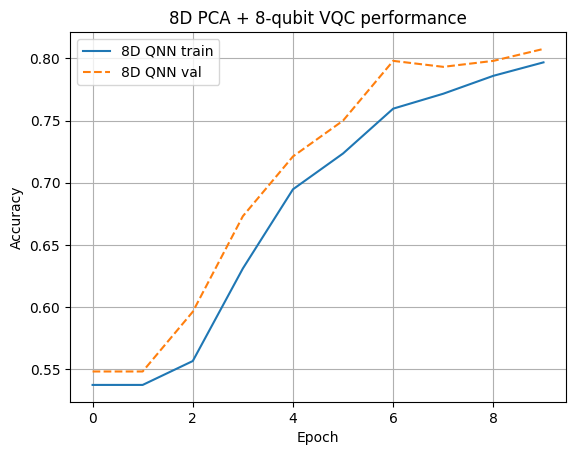

In [26]:
model_8d = HybridQNN_8D()
model_8d, hist_8d = train_hybrid_qnn_with_history(
    model_8d,
    train_loader_q8,
    val_loader_q8,
    epochs=10,
    lr=5e-3,
)

plt.figure()
plt.plot(hist_8d["train_acc"], label="8D QNN train")
plt.plot(hist_8d["val_acc"], '--', label="8D QNN val")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("8D PCA + 8-qubit VQC performance")
plt.legend(); plt.grid(True); plt.show()


# NEXT BIG STEP

## Build the first CNN → Quantum hybrid architecture

### NEW PLAN

Step 1 — Build a small CNN encoder

Output feature vector of size 8 or 16

Step 2 — Feed CNN features to a VQC

4 qubits or 8 qubits

2–3 layers

Train end-to-end

Step 3 — Move to the 28×28 MNIST task
Step 4 — Add Lightning.gpu acceleration
Step 5 — Move to full 0–9 classification with multi-output quantum head or hybrid head


## Small CNN Feature Extractor

In [27]:
# Cell A1: Small CNN encoder to extract image features for quantum classifier

import torch.nn as nn
import torch.nn.functional as F

class CNN_Encoder(nn.Module):
    def __init__(self, out_features=8):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)   # halves image size
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        
        # After 8×8 → conv → pool → 4×4 → conv → pool → 2×2
        self.fc = nn.Linear(16 * 2 * 2, out_features)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # [B,8,8,8]
        x = self.pool(x)            # [B,8,4,4]
        x = F.relu(self.conv2(x))   # [B,16,4,4]
        x = self.pool(x)            # [B,16,2,2]
        x = x.view(x.size(0), -1)   # flatten
        x = self.fc(x)
        return x


### Hybrid CNN → VQC model

In [28]:
# Cell A2: Full hybrid model: CNN encoder -> 8D vector -> quantum circuit

class HybridCNN_QNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = CNN_Encoder(out_features=8)
        self.q_weights = nn.Parameter(0.01 * torch.randn(n_weights8))
        self.fc_out = nn.Linear(1, 1)

    def forward(self, x):
        # CNN features (B, 8)
        features = self.encoder(x.float().to(torch_device))

        # Quantum layer per sample
        outs = []
        for i in range(features.shape[0]):
            outs.append(vqc_8(features[i], self.q_weights))

        q_out = torch.stack(outs).unsqueeze(-1)
        logits = self.fc_out(q_out).squeeze(-1)
        return logits


### Train the CNN→QNN hybrid on 8×8 MNIST (binary 0 vs 1)

[Hybrid] Epoch 1: 100%|███████████████████████████| 7/7 [00:04<00:00,  1.59it/s]


[Hybrid] Epoch 1: train_loss=0.6914, train_acc=0.5384, val_acc=0.5481


[Hybrid] Epoch 2: 100%|███████████████████████████| 7/7 [00:04<00:00,  1.60it/s]


[Hybrid] Epoch 2: train_loss=0.6468, train_acc=0.5384, val_acc=0.5481


[Hybrid] Epoch 3: 100%|███████████████████████████| 7/7 [00:04<00:00,  1.75it/s]


[Hybrid] Epoch 3: train_loss=0.6245, train_acc=0.5384, val_acc=0.5481


[Hybrid] Epoch 4: 100%|███████████████████████████| 7/7 [00:04<00:00,  1.44it/s]


[Hybrid] Epoch 4: train_loss=0.6060, train_acc=0.5384, val_acc=0.5481


[Hybrid] Epoch 5: 100%|███████████████████████████| 7/7 [00:04<00:00,  1.48it/s]


[Hybrid] Epoch 5: train_loss=0.5884, train_acc=0.5384, val_acc=0.5481


[Hybrid] Epoch 6: 100%|███████████████████████████| 7/7 [00:05<00:00,  1.39it/s]


[Hybrid] Epoch 6: train_loss=0.5713, train_acc=0.5384, val_acc=0.5481


[Hybrid] Epoch 7: 100%|███████████████████████████| 7/7 [00:05<00:00,  1.32it/s]


[Hybrid] Epoch 7: train_loss=0.5537, train_acc=0.5384, val_acc=0.5481


[Hybrid] Epoch 8: 100%|███████████████████████████| 7/7 [00:03<00:00,  1.76it/s]


[Hybrid] Epoch 8: train_loss=0.5363, train_acc=0.8885, val_acc=0.9952


[Hybrid] Epoch 9: 100%|███████████████████████████| 7/7 [00:04<00:00,  1.68it/s]


[Hybrid] Epoch 9: train_loss=0.5191, train_acc=0.9916, val_acc=0.9952


[Hybrid] Epoch 10: 100%|██████████████████████████| 7/7 [00:05<00:00,  1.22it/s]


[Hybrid] Epoch 10: train_loss=0.4937, train_acc=0.9880, val_acc=0.9952


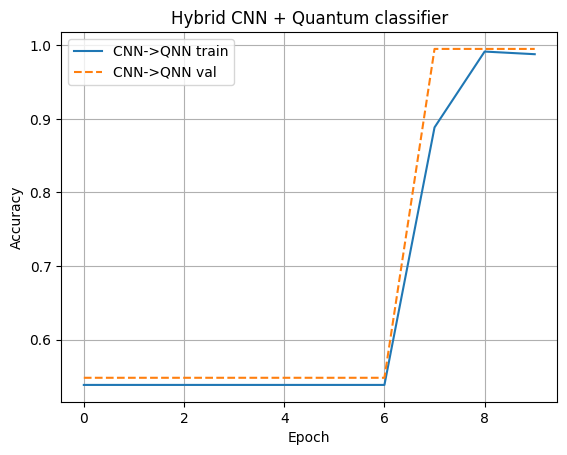

In [29]:
# Cell A3: Train CNN -> QNN hybrid

model_cnn_qnn = HybridCNN_QNN()
model_cnn_qnn = model_cnn_qnn.to(torch_device)

model_cnn_qnn, hist_cnn_qnn = train_hybrid_qnn_with_history(
    model_cnn_qnn,
    binary_loaders_01_8["train_classical"],   # images (8x8)
    binary_loaders_01_8["val_classical"],     # images (8x8)
    epochs=10,
    lr=5e-3,
)

plt.figure()
plt.plot(hist_cnn_qnn["train_acc"], label="CNN->QNN train")
plt.plot(hist_cnn_qnn["val_acc"], '--', label="CNN->QNN val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Hybrid CNN + Quantum classifier")
plt.legend()
plt.grid(True)
plt.show()


### Multi-class MNIST 28×28 loaders

In [30]:
# Cell 1: DataLoaders for full MNIST (0–9), 28×28

def make_multiclass_loaders_28(
    val_split: float = 0.1,
    batch_size_classical: int = BATCH_SIZE_CLASSICAL,
    batch_size_quantum: int = BATCH_SIZE_QUANTUM,
):
    """
    Build train/val/test loaders for full 10-class MNIST at 28×28.
    - classical loaders: larger batch (for pure CNN baselines)
    - quantum loaders: smaller batch (for CNN->QNN hybrid)
    """
    full_train = train_28
    full_test = test_28

    n_train = len(full_train)
    n_val = int(val_split * n_train)
    n_train_final = n_train - n_val

    train_ds, val_ds = random_split(
        full_train,
        [n_train_final, n_val],
        generator=torch.Generator().manual_seed(SEED),
    )

    # Classical loaders
    train_loader_classical = DataLoader(
        train_ds,
        batch_size=batch_size_classical,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=(torch_device.type == "cuda"),
    )

    val_loader_classical = DataLoader(
        val_ds,
        batch_size=batch_size_classical,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=(torch_device.type == "cuda"),
    )

    # Quantum loaders (smaller batch size, drop_last to avoid batch=1)
    train_loader_quantum = DataLoader(
        train_ds,
        batch_size=batch_size_quantum,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=(torch_device.type == "cuda"),
        drop_last=True,
    )

    val_loader_quantum = DataLoader(
        val_ds,
        batch_size=batch_size_quantum,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=(torch_device.type == "cuda"),
        drop_last=True,
    )

    test_loader = DataLoader(
        full_test,
        batch_size=batch_size_classical,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=(torch_device.type == "cuda"),
    )

    print(
        f"28x28 MNIST multi-class: train={n_train_final}, val={n_val}, "
        f"test={len(full_test)}"
    )

    return {
        "train_classical": train_loader_classical,
        "val_classical": val_loader_classical,
        "train_quantum": train_loader_quantum,
        "val_quantum": val_loader_quantum,
        "test": test_loader,
    }


loaders_28 = make_multiclass_loaders_28()


28x28 MNIST multi-class: train=4500, val=500, test=2000


### CNN encoder for 28×28 → 8-D feature vector

In [31]:
# Cell 2: CNN encoder for 28×28 MNIST

import torch.nn as nn
import torch.nn.functional as F

class CNN28_Encoder(nn.Module):
    def __init__(self, out_features: int = 8):
        super().__init__()
        # 28x28 -> 14x14 -> 7x7 -> 3x3
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # 28x28
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) # 14x14
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # 7x7
        self.pool  = nn.MaxPool2d(2, 2)

        # After conv+pool:
        # 28x28 -> pool -> 14x14
        # 14x14 -> pool -> 7x7
        # 7x7  -> pool -> 3x3
        flattened_dim = 64 * 3 * 3

        self.fc = nn.Sequential(
            nn.Linear(flattened_dim, 64),
            nn.ReLU(),
            nn.Linear(64, out_features),
        )

    def forward(self, x):
        x = x.to(torch_device).float()
        x = F.relu(self.conv1(x))  # [B,16,28,28]
        x = self.pool(x)           # [B,16,14,14]
        x = F.relu(self.conv2(x))  # [B,32,14,14]
        x = self.pool(x)           # [B,32,7,7]
        x = F.relu(self.conv3(x))  # [B,64,7,7]
        x = self.pool(x)           # [B,64,3,3]
        x = x.view(x.size(0), -1)  # [B, 64*3*3]
        x = self.fc(x)             # [B, out_features]
        return x


## 8-qubit, vector-output VQC + 10-class hybrid model

In [32]:
# Fixed Cell: 8-qubit VQC with vector output + 10-class CNN->QNN hybrid

import pennylane as qml
import torch
import torch.nn as nn

n_qubits10 = 8
n_layers10 = 2

dev10 = make_qdevice(
    n_wires=n_qubits10,
    use_gpu=False,   # can flip to True later for lightning.gpu
    shots=None
)

@qml.qnode(dev10, interface="torch")
def vqc_8_vector(inputs, weights):
    """
    inputs: 1D tensor of length 8
    weights: [n_layers10, n_qubits10]
    returns: tuple of 8 expectation values (torch scalars)
    """
    # Data encoding
    for i in range(n_qubits10):
        qml.RY(inputs[i], wires=i)

    # Variational layers
    for l in range(n_layers10):
        # trainable rotations
        for i in range(n_qubits10):
            qml.RY(weights[l, i], wires=i)

        # ring entanglement
        for i in range(n_qubits10):
            qml.CNOT(wires=[i, (i + 1) % n_qubits10])

    # IMPORTANT: return a tuple, not a list
    return tuple(qml.expval(qml.PauliZ(i)) for i in range(n_qubits10))


class HybridCNN_QNN_10(nn.Module):
    def __init__(self, n_classes: int = 10):
        super().__init__()
        self.encoder = CNN28_Encoder(out_features=n_qubits10)
        # quantum parameters
        self.q_weights = nn.Parameter(0.01 * torch.randn(n_layers10, n_qubits10))
        # classical head: 8 quantum features -> 10 logits
        self.fc_out = nn.Linear(n_qubits10, n_classes)

    def forward(self, x):
        # CNN features: [B, 8]
        feats = self.encoder(x)                  # [B, 8]

        # Quantum layer per sample
        outs = []
        for i in range(feats.shape[0]):
            out_tuple = vqc_8_vector(feats[i], self.q_weights)  # tuple of 8 scalars
            out_vec = torch.stack(out_tuple)                    # tensor [8]
            outs.append(out_vec)

        # Stack to [B, 8]
        q_out = torch.stack(outs)                               # [B, 8]
        logits = self.fc_out(q_out)                             # [B, 10]
        return logits


print("HybridCNN_QNN_10 model ready (fixed vector output).")
model_10 = HybridCNN_QNN_10().to(torch_device)
print(model_10)


HybridCNN_QNN_10 model ready (fixed vector output).
HybridCNN_QNN_10(
  (encoder): CNN28_Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc): Sequential(
      (0): Linear(in_features=576, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=8, bias=True)
    )
  )
  (fc_out): Linear(in_features=8, out_features=10, bias=True)
)


### Multi-class training loop (CrossEntropy + quantum batching)

In [33]:
# Cell 1: Multi-class training loop for HybridCNN_QNN_10

import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

def train_multiclass_qnn(model, train_loader, val_loader, epochs=10, lr=1e-3):
    model = model.to(torch_device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }

    for epoch in range(1, epochs + 1):

        # ------------------ TRAIN ------------------
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for x_batch, y_batch in tqdm(train_loader, desc=f"[QNN Train Epoch {epoch}]"):
            x_batch = x_batch.to(torch_device)
            y_batch = y_batch.to(torch_device)

            logits = model(x_batch)              # [B,10]
            loss = loss_fn(logits, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x_batch.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == y_batch).sum().item()
            total_samples += x_batch.size(0)

        train_loss = total_loss / total_samples
        train_acc = total_correct / total_samples

        # ------------------ VAL ------------------
        model.eval()
        val_loss = 0
        val_correct = 0
        val_samples = 0

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.to(torch_device)
                y_val = y_val.to(torch_device)

                logits_val = model(x_val)
                loss_val = loss_fn(logits_val, y_val)

                preds_val = logits_val.argmax(dim=1)
                val_correct += (preds_val == y_val).sum().item()
                val_samples += x_val.size(0)

                val_loss += loss_val.item() * x_val.size(0)

        val_loss /= val_samples
        val_acc = val_correct / val_samples

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"[Epoch {epoch}] "
              f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

    return model, history


### Run training

In [34]:
# Cell 2: Train Hybrid CNN->QNN on full MNIST 28x28 (0–9)

model_10 = HybridCNN_QNN_10().to(torch_device)

model_10, hist_10 = train_multiclass_qnn(
    model_10,
    loaders_28["train_quantum"],
    loaders_28["val_quantum"],
    epochs=10,        # heavy but safe for your hardware
    lr=1e-3,
)


[QNN Train Epoch 1]: 100%|████████████████████| 281/281 [00:30<00:00,  9.11it/s]


[Epoch 1] train_loss=2.0942 train_acc=0.2164 | val_loss=1.8127 val_acc=0.2641


[QNN Train Epoch 2]: 100%|████████████████████| 281/281 [00:32<00:00,  8.77it/s]


[Epoch 2] train_loss=1.5803 train_acc=0.4346 | val_loss=1.4095 val_acc=0.5706


[QNN Train Epoch 3]: 100%|████████████████████| 281/281 [00:30<00:00,  9.07it/s]


[Epoch 3] train_loss=1.2117 train_acc=0.6684 | val_loss=1.1403 val_acc=0.6976


[QNN Train Epoch 4]: 100%|████████████████████| 281/281 [00:34<00:00,  8.23it/s]


[Epoch 4] train_loss=0.9553 train_acc=0.7682 | val_loss=0.8927 val_acc=0.8508


[QNN Train Epoch 5]: 100%|████████████████████| 281/281 [00:32<00:00,  8.67it/s]


[Epoch 5] train_loss=0.7565 train_acc=0.8327 | val_loss=0.7050 val_acc=0.9012


[QNN Train Epoch 6]: 100%|████████████████████| 281/281 [00:28<00:00,  9.95it/s]


[Epoch 6] train_loss=0.6245 train_acc=0.8741 | val_loss=0.7153 val_acc=0.8649


[QNN Train Epoch 7]: 100%|████████████████████| 281/281 [00:33<00:00,  8.51it/s]


[Epoch 7] train_loss=0.5246 train_acc=0.8897 | val_loss=0.5353 val_acc=0.8891


[QNN Train Epoch 8]: 100%|████████████████████| 281/281 [00:29<00:00,  9.60it/s]


[Epoch 8] train_loss=0.4324 train_acc=0.9068 | val_loss=0.4825 val_acc=0.8972


[QNN Train Epoch 9]: 100%|████████████████████| 281/281 [00:30<00:00,  9.13it/s]


[Epoch 9] train_loss=0.3678 train_acc=0.9255 | val_loss=0.5172 val_acc=0.9093


[QNN Train Epoch 10]: 100%|███████████████████| 281/281 [00:28<00:00,  9.80it/s]


[Epoch 10] train_loss=0.3110 train_acc=0.9304 | val_loss=0.4112 val_acc=0.9375


### NEXT UPGRADE: Full-power quantum training

### Deep 8-qubit, 6-layer VQC + hybrid model

In [35]:
# Cell H1: Deep 8-qubit, 6-layer VQC + hybrid CNN->QNN model

import pennylane as qml
import torch
import torch.nn as nn

N_QUBITS_DEEP = 8
N_LAYERS_DEEP = 6

dev_deep = qml.device(
    "lightning.qubit",
    wires=N_QUBITS_DEEP,
    shots=None,
)

@qml.qnode(dev_deep, interface="torch")
def vqc_8_vector_deep(inputs, weights):
    """
    inputs: [8]
    weights: [N_LAYERS_DEEP, N_QUBITS_DEEP]
    """
    # data encoding
    for i in range(N_QUBITS_DEEP):
        qml.RY(inputs[i], wires=i)

    # variational layers
    for l in range(N_LAYERS_DEEP):
        for i in range(N_QUBITS_DEEP):
            qml.RY(weights[l, i], wires=i)
        for i in range(N_QUBITS_DEEP):
            qml.CNOT(wires=[i, (i + 1) % N_QUBITS_DEEP])

    # return tuple of expvals (torch-friendly)
    return tuple(qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS_DEEP))


class HybridCNN_QNN_10_Deep(nn.Module):
    """
    CNN28_Encoder -> deep 8-qubit VQC (6 layers) -> 10-class logits
    """
    def __init__(self, n_classes: int = 10):
        super().__init__()
        self.encoder = CNN28_Encoder(out_features=N_QUBITS_DEEP)
        self.q_weights = nn.Parameter(
            0.01 * torch.randn(N_LAYERS_DEEP, N_QUBITS_DEEP)
        )
        self.fc_out = nn.Linear(N_QUBITS_DEEP, n_classes)

    def forward(self, x):
        feats = self.encoder(x)  # [B, 8]

        outs = []
        for i in range(feats.shape[0]):
            out_tuple = vqc_8_vector_deep(feats[i], self.q_weights)
            out_vec = torch.stack(out_tuple)      # [8]
            outs.append(out_vec)

        q_out = torch.stack(outs)                 # [B, 8]
        logits = self.fc_out(q_out)               # [B, 10]
        return logits


print("HybridCNN_QNN_10_Deep ready:",
      f"{N_QUBITS_DEEP} qubits, {N_LAYERS_DEEP} layers.")


HybridCNN_QNN_10_Deep ready: 8 qubits, 6 layers.


In [36]:
# Cell H2: L2 heavy run on full 10-class MNIST with deep VQC

EPOCHS_L2 = 25
LR_L2     = 1e-3

model_10_deep = HybridCNN_QNN_10_Deep().to(torch_device)

model_10_deep, hist_10_deep = train_multiclass_qnn(
    model_10_deep,
    loaders_28["train_quantum"],
    loaders_28["val_quantum"],
    epochs=EPOCHS_L2,
    lr=LR_L2,
)


[QNN Train Epoch 1]: 100%|████████████████████| 281/281 [00:53<00:00,  5.22it/s]


[Epoch 1] train_loss=1.7513 train_acc=0.4720 | val_loss=1.3213 val_acc=0.7520


[QNN Train Epoch 2]: 100%|████████████████████| 281/281 [00:53<00:00,  5.30it/s]


[Epoch 2] train_loss=0.9920 train_acc=0.8641 | val_loss=0.7150 val_acc=0.9153


[QNN Train Epoch 3]: 100%|████████████████████| 281/281 [00:52<00:00,  5.38it/s]


[Epoch 3] train_loss=0.5763 train_acc=0.9355 | val_loss=0.4854 val_acc=0.9395


[QNN Train Epoch 4]: 100%|████████████████████| 281/281 [00:50<00:00,  5.56it/s]


[Epoch 4] train_loss=0.3697 train_acc=0.9742 | val_loss=0.3264 val_acc=0.9677


[QNN Train Epoch 5]: 100%|████████████████████| 281/281 [00:49<00:00,  5.63it/s]


[Epoch 5] train_loss=0.2328 train_acc=0.9822 | val_loss=0.2458 val_acc=0.9738


[QNN Train Epoch 6]: 100%|████████████████████| 281/281 [00:49<00:00,  5.70it/s]


[Epoch 6] train_loss=0.1471 train_acc=0.9918 | val_loss=0.1914 val_acc=0.9738


[QNN Train Epoch 7]: 100%|████████████████████| 281/281 [00:47<00:00,  5.87it/s]


[Epoch 7] train_loss=0.1068 train_acc=0.9929 | val_loss=0.1457 val_acc=0.9839


[QNN Train Epoch 8]: 100%|████████████████████| 281/281 [00:49<00:00,  5.71it/s]


[Epoch 8] train_loss=0.0733 train_acc=0.9960 | val_loss=0.1321 val_acc=0.9819


[QNN Train Epoch 9]: 100%|████████████████████| 281/281 [00:49<00:00,  5.64it/s]


[Epoch 9] train_loss=0.0517 train_acc=0.9969 | val_loss=0.1272 val_acc=0.9839


[QNN Train Epoch 10]: 100%|███████████████████| 281/281 [00:47<00:00,  5.86it/s]


[Epoch 10] train_loss=0.0368 train_acc=0.9987 | val_loss=0.1138 val_acc=0.9879


[QNN Train Epoch 11]: 100%|███████████████████| 281/281 [00:51<00:00,  5.46it/s]


[Epoch 11] train_loss=0.0290 train_acc=0.9991 | val_loss=0.1012 val_acc=0.9879


[QNN Train Epoch 12]: 100%|███████████████████| 281/281 [00:48<00:00,  5.85it/s]


[Epoch 12] train_loss=0.0222 train_acc=0.9996 | val_loss=0.1004 val_acc=0.9819


[QNN Train Epoch 13]: 100%|███████████████████| 281/281 [00:49<00:00,  5.70it/s]


[Epoch 13] train_loss=0.0179 train_acc=1.0000 | val_loss=0.0938 val_acc=0.9859


[QNN Train Epoch 14]: 100%|███████████████████| 281/281 [00:48<00:00,  5.79it/s]


[Epoch 14] train_loss=0.0146 train_acc=1.0000 | val_loss=0.0904 val_acc=0.9839


[QNN Train Epoch 15]: 100%|███████████████████| 281/281 [00:53<00:00,  5.22it/s]


[Epoch 15] train_loss=0.0121 train_acc=1.0000 | val_loss=0.0883 val_acc=0.9859


[QNN Train Epoch 16]: 100%|███████████████████| 281/281 [00:51<00:00,  5.44it/s]


[Epoch 16] train_loss=0.0102 train_acc=1.0000 | val_loss=0.0832 val_acc=0.9879


[QNN Train Epoch 17]: 100%|███████████████████| 281/281 [00:47<00:00,  5.93it/s]


[Epoch 17] train_loss=0.0087 train_acc=1.0000 | val_loss=0.0843 val_acc=0.9859


[QNN Train Epoch 18]: 100%|███████████████████| 281/281 [00:43<00:00,  6.47it/s]


[Epoch 18] train_loss=0.0074 train_acc=1.0000 | val_loss=0.0827 val_acc=0.9859


[QNN Train Epoch 19]: 100%|███████████████████| 281/281 [00:48<00:00,  5.85it/s]


[Epoch 19] train_loss=0.0063 train_acc=1.0000 | val_loss=0.0808 val_acc=0.9859


[QNN Train Epoch 20]: 100%|███████████████████| 281/281 [00:47<00:00,  5.94it/s]


[Epoch 20] train_loss=0.0054 train_acc=1.0000 | val_loss=0.0808 val_acc=0.9859


[QNN Train Epoch 21]: 100%|███████████████████| 281/281 [00:45<00:00,  6.14it/s]


[Epoch 21] train_loss=0.0047 train_acc=1.0000 | val_loss=0.0785 val_acc=0.9859


[QNN Train Epoch 22]: 100%|███████████████████| 281/281 [00:44<00:00,  6.27it/s]


[Epoch 22] train_loss=0.0040 train_acc=1.0000 | val_loss=0.0817 val_acc=0.9879


[QNN Train Epoch 23]: 100%|███████████████████| 281/281 [00:45<00:00,  6.18it/s]


[Epoch 23] train_loss=0.0035 train_acc=1.0000 | val_loss=0.0808 val_acc=0.9859


[QNN Train Epoch 24]: 100%|███████████████████| 281/281 [00:45<00:00,  6.15it/s]


[Epoch 24] train_loss=0.0030 train_acc=1.0000 | val_loss=0.0816 val_acc=0.9859


[QNN Train Epoch 25]: 100%|███████████████████| 281/281 [00:43<00:00,  6.45it/s]


[Epoch 25] train_loss=0.0026 train_acc=1.0000 | val_loss=0.0776 val_acc=0.9859


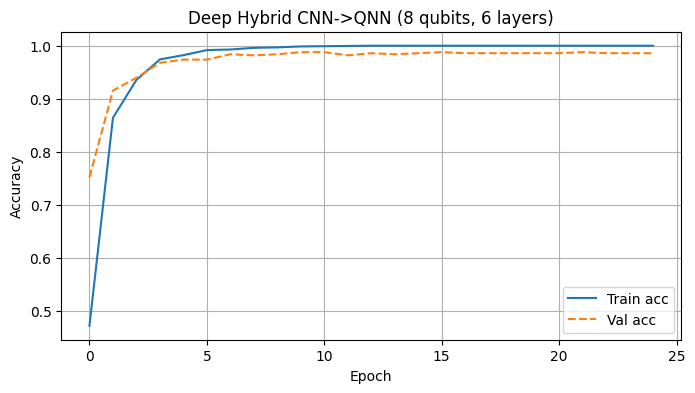

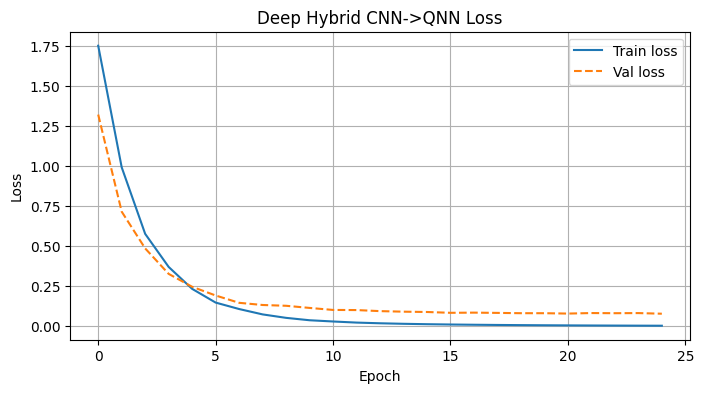

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(hist_10_deep["train_acc"], label="Train acc")
plt.plot(hist_10_deep["val_acc"], '--', label="Val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Deep Hybrid CNN->QNN (8 qubits, 6 layers)")
plt.grid(True); plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(hist_10_deep["train_loss"], label="Train loss")
plt.plot(hist_10_deep["val_loss"], '--', label="Val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Deep Hybrid CNN->QNN Loss")
plt.grid(True); plt.legend()
plt.show()


In [38]:
# Cell T1: Test accuracy for deep Hybrid CNN->QNN

import torch
import torch.nn.functional as F

def evaluate_on_test(model, test_loader):
    model.eval()
    model.to(torch_device)

    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(torch_device)
            y = y.to(torch_device)

            logits = model(x)              # [B, 10]
            preds = logits.argmax(dim=1)   # [B]

            total_correct += (preds == y).sum().item()
            total_samples += x.size(0)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    test_acc = total_correct / total_samples
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    print(f"Test accuracy: {test_acc:.4f}")
    return test_acc, all_preds, all_labels


test_acc_deep, test_preds_deep, test_labels_deep = evaluate_on_test(
    model_10_deep,
    loaders_28["test"],
)


Test accuracy: 0.9710


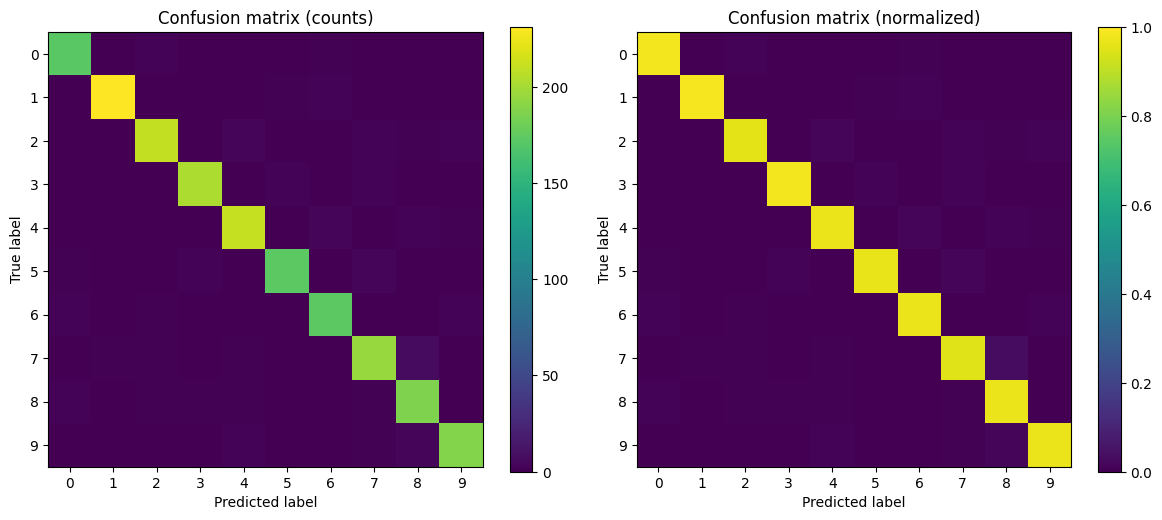

In [39]:
# Cell T2: Confusion matrix for deep Hybrid CNN->QNN

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(test_labels_deep, test_preds_deep)
cm_norm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Raw counts
im0 = ax[0].imshow(cm, interpolation='nearest')
ax[0].set_title("Confusion matrix (counts)")
ax[0].set_xlabel("Predicted label")
ax[0].set_ylabel("True label")
ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
fig.colorbar(im0, ax=ax[0])

# Normalized
im1 = ax[1].imshow(cm_norm, interpolation='nearest', vmin=0.0, vmax=1.0)
ax[1].set_title("Confusion matrix (normalized)")
ax[1].set_xlabel("Predicted label")
ax[1].set_ylabel("True label")
ax[1].set_xticks(range(10))
ax[1].set_yticks(range(10))
fig.colorbar(im1, ax=ax[1])

plt.tight_layout()
plt.show()


In [40]:
# Cell M1: Collect misclassified examples from the test set

model_10_deep.eval()
model_10_deep.to(torch_device)

mis_images = []
mis_true = []
mis_pred = []

with torch.no_grad():
    for x, y in loaders_28["test"]:
        x_dev = x.to(torch_device)
        y_dev = y.to(torch_device)

        logits = model_10_deep(x_dev)          # [B, 10]
        preds = logits.argmax(dim=1).cpu()     # back to CPU for indexing

        for i in range(x.size(0)):
            if preds[i].item() != y[i].item():
                mis_images.append(x[i])        # [1,28,28] tensor (still on CPU)
                mis_true.append(int(y[i].item()))
                mis_pred.append(int(preds[i].item()))

print(f"Total misclassified examples: {len(mis_images)}")


Total misclassified examples: 58


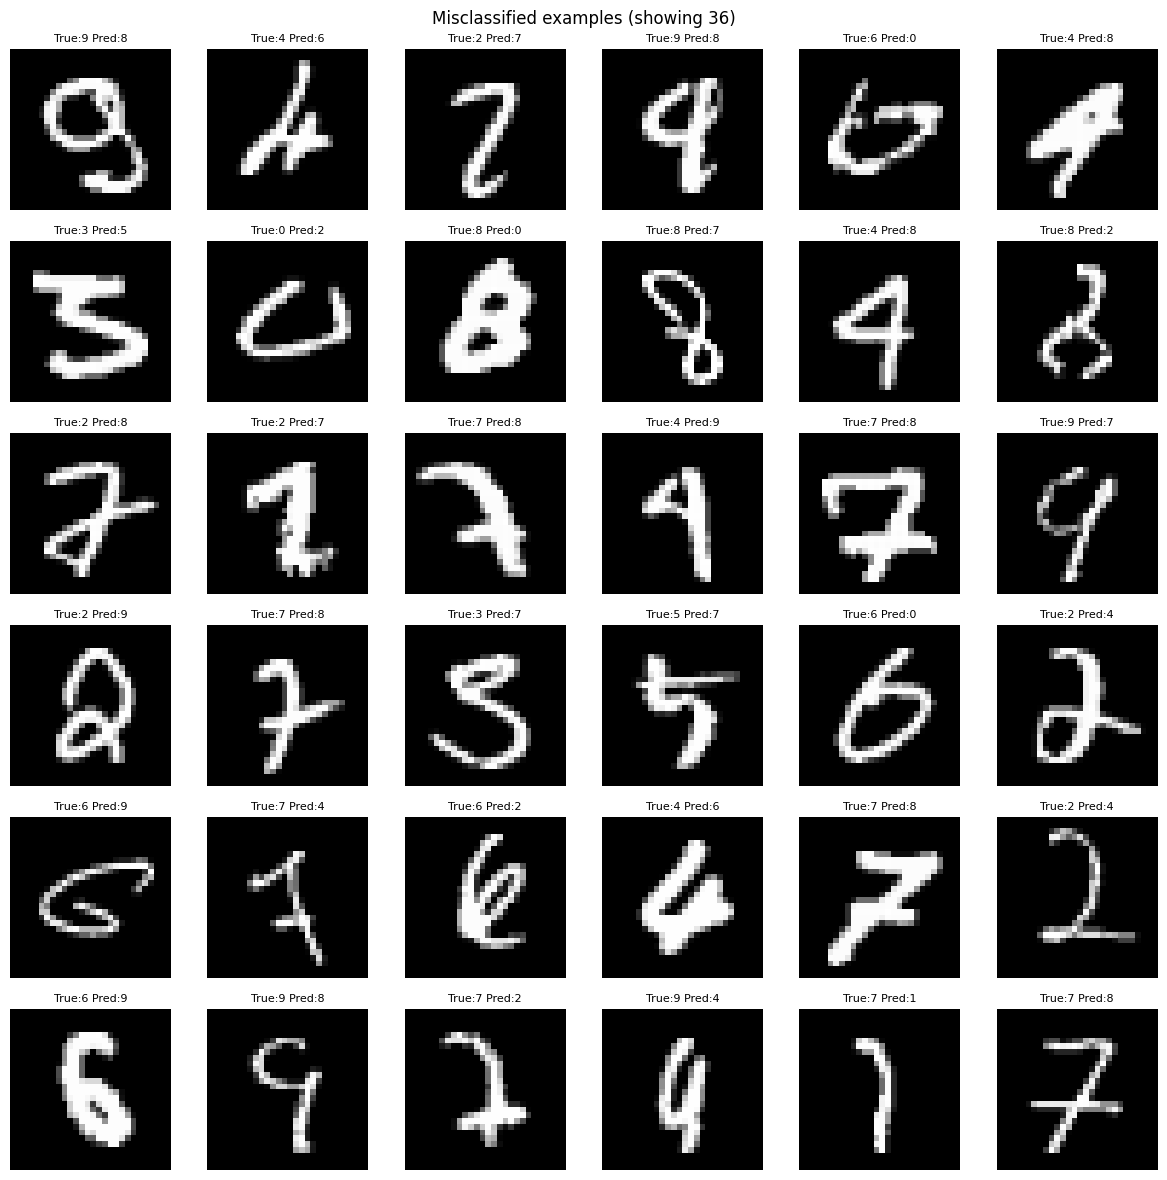

In [42]:
# Cell M2: Plot some misclassified digits

import matplotlib.pyplot as plt
import math

n_show = min(36, len(mis_images))  # show up to 36
cols = 6
rows = math.ceil(n_show / cols)

plt.figure(figsize=(cols * 2, rows * 2))
for i in range(n_show):
    img = mis_images[i].squeeze(0)  # [28, 28]
    true_label = mis_true[i]
    pred_label = mis_pred[i]

    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(img, cmap="gray")
    ax.axis("off")
    ax.set_title(f"True:{true_label} Pred:{pred_label}", fontsize=8)

plt.suptitle(f"Misclassified examples (showing {n_show})", y=0.98)
plt.tight_layout()
plt.show()


### new model 10-qubit, 8-layer VQC + new hybrid model 
# was bad dont these 2 cells 

In [43]:
# Cell 1: 10-qubit, 8-layer VQC + Hybrid CNN->QNN model

import pennylane as qml
import torch
import torch.nn as nn

N_QUBITS_10Q  = 10
N_LAYERS_10Q  = 8

dev_10q = qml.device(
    "lightning.qubit",
    wires=N_QUBITS_10Q,
    shots=None,
)

@qml.qnode(dev_10q, interface="torch")
def vqc_10q_vector(inputs, weights):
    """
    inputs: [10]
    weights: [N_LAYERS_10Q, N_QUBITS_10Q]
    returns: tuple of 10 expvals (torch-friendly)
    """
    # data encoding
    for i in range(N_QUBITS_10Q):
        qml.RY(inputs[i], wires=i)

    # variational layers
    for l in range(N_LAYERS_10Q):
        # trainable rotations
        for i in range(N_QUBITS_10Q):
            qml.RY(weights[l, i], wires=i)
        # ring entanglement
        for i in range(N_QUBITS_10Q):
            qml.CNOT(wires=[i, (i + 1) % N_QUBITS_10Q])

    return tuple(qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS_10Q))


class HybridCNN_QNN_10QDeep(nn.Module):
    """
    CNN28_Encoder -> 10-qubit, 8-layer VQC -> 10-class logits
    """
    def __init__(self, n_classes: int = 10):
        super().__init__()
        # CNN now outputs 10 features
        self.encoder = CNN28_Encoder(out_features=N_QUBITS_10Q)
        self.q_weights = nn.Parameter(
            0.01 * torch.randn(N_LAYERS_10Q, N_QUBITS_10Q)
        )
        self.fc_out = nn.Linear(N_QUBITS_10Q, n_classes)

    def forward(self, x):
        feats = self.encoder(x)              # [B, 10]

        outs = []
        for i in range(feats.shape[0]):
            out_tuple = vqc_10q_vector(feats[i], self.q_weights)  # tuple of 10 scalars
            out_vec   = torch.stack(out_tuple)                    # [10]
            outs.append(out_vec)

        q_out = torch.stack(outs)           # [B, 10]
        logits = self.fc_out(q_out)         # [B, 10]
        return logits


print("HybridCNN_QNN_10QDeep ready:",
      f"{N_QUBITS_10Q} qubits, {N_LAYERS_10Q} layers.")


HybridCNN_QNN_10QDeep ready: 10 qubits, 8 layers.


In [44]:
# Cell 2: Heavy training run for 10-qubit deep hybrid model

EPOCHS_10Q = 40
LR_10Q     = 1e-3

model_10q_deep = HybridCNN_QNN_10QDeep().to(torch_device)

model_10q_deep, hist_10q_deep = train_multiclass_qnn(
    model_10q_deep,
    loaders_28["train_quantum"],
    loaders_28["val_quantum"],
    epochs=EPOCHS_10Q,
    lr=LR_10Q,
)


[QNN Train Epoch 1]: 100%|████████████████████| 281/281 [01:02<00:00,  4.52it/s]


[Epoch 1] train_loss=2.3114 train_acc=0.1039 | val_loss=2.2899 val_acc=0.1069


[QNN Train Epoch 2]: 100%|████████████████████| 281/281 [01:04<00:00,  4.39it/s]


[Epoch 2] train_loss=2.3024 train_acc=0.1114 | val_loss=2.3043 val_acc=0.1008


[QNN Train Epoch 3]: 100%|████████████████████| 281/281 [01:04<00:00,  4.35it/s]


[Epoch 3] train_loss=2.2867 train_acc=0.1301 | val_loss=2.3166 val_acc=0.0927


[QNN Train Epoch 4]: 100%|████████████████████| 281/281 [01:03<00:00,  4.44it/s]


[Epoch 4] train_loss=2.2955 train_acc=0.1292 | val_loss=2.3095 val_acc=0.1048


[QNN Train Epoch 5]: 100%|████████████████████| 281/281 [01:05<00:00,  4.30it/s]


[Epoch 5] train_loss=2.3019 train_acc=0.1154 | val_loss=2.3103 val_acc=0.0806


[QNN Train Epoch 6]: 100%|████████████████████| 281/281 [01:05<00:00,  4.29it/s]


[Epoch 6] train_loss=2.3021 train_acc=0.1099 | val_loss=2.3086 val_acc=0.1089


[QNN Train Epoch 7]: 100%|████████████████████| 281/281 [01:06<00:00,  4.22it/s]


[Epoch 7] train_loss=2.2998 train_acc=0.1188 | val_loss=2.3101 val_acc=0.1048


[QNN Train Epoch 8]: 100%|████████████████████| 281/281 [01:04<00:00,  4.37it/s]


[Epoch 8] train_loss=2.3010 train_acc=0.1206 | val_loss=2.3152 val_acc=0.0887


[QNN Train Epoch 9]: 100%|████████████████████| 281/281 [01:04<00:00,  4.38it/s]


[Epoch 9] train_loss=2.2994 train_acc=0.1130 | val_loss=2.3175 val_acc=0.0887


[QNN Train Epoch 10]: 100%|███████████████████| 281/281 [01:05<00:00,  4.27it/s]


[Epoch 10] train_loss=2.2998 train_acc=0.1099 | val_loss=2.3095 val_acc=0.0968


[QNN Train Epoch 11]: 100%|███████████████████| 281/281 [01:05<00:00,  4.30it/s]


[Epoch 11] train_loss=2.3007 train_acc=0.1065 | val_loss=2.3150 val_acc=0.1069


[QNN Train Epoch 12]: 100%|███████████████████| 281/281 [01:07<00:00,  4.16it/s]


[Epoch 12] train_loss=2.2997 train_acc=0.1139 | val_loss=2.3126 val_acc=0.0988


[QNN Train Epoch 13]: 100%|███████████████████| 281/281 [01:05<00:00,  4.31it/s]


[Epoch 13] train_loss=2.3005 train_acc=0.1128 | val_loss=2.3129 val_acc=0.0927


[QNN Train Epoch 14]: 100%|███████████████████| 281/281 [01:07<00:00,  4.14it/s]


[Epoch 14] train_loss=2.2998 train_acc=0.1139 | val_loss=2.3101 val_acc=0.1109


[QNN Train Epoch 15]: 100%|███████████████████| 281/281 [01:08<00:00,  4.12it/s]


[Epoch 15] train_loss=2.2992 train_acc=0.1132 | val_loss=2.3141 val_acc=0.0968


[QNN Train Epoch 16]: 100%|███████████████████| 281/281 [01:07<00:00,  4.18it/s]


[Epoch 16] train_loss=2.2994 train_acc=0.1137 | val_loss=2.3149 val_acc=0.0927


[QNN Train Epoch 17]: 100%|███████████████████| 281/281 [01:05<00:00,  4.31it/s]


[Epoch 17] train_loss=2.3000 train_acc=0.1092 | val_loss=2.3120 val_acc=0.1028


[QNN Train Epoch 18]: 100%|███████████████████| 281/281 [01:05<00:00,  4.30it/s]


[Epoch 18] train_loss=2.2994 train_acc=0.1157 | val_loss=2.3116 val_acc=0.1270


[QNN Train Epoch 19]: 100%|███████████████████| 281/281 [01:03<00:00,  4.43it/s]


[Epoch 19] train_loss=2.2991 train_acc=0.1103 | val_loss=2.3120 val_acc=0.0827


[QNN Train Epoch 20]: 100%|███████████████████| 281/281 [01:06<00:00,  4.23it/s]


[Epoch 20] train_loss=2.3002 train_acc=0.1085 | val_loss=2.3110 val_acc=0.0887


[QNN Train Epoch 21]: 100%|███████████████████| 281/281 [01:03<00:00,  4.46it/s]


[Epoch 21] train_loss=2.2994 train_acc=0.1117 | val_loss=2.3113 val_acc=0.0867


[QNN Train Epoch 22]: 100%|███████████████████| 281/281 [01:02<00:00,  4.46it/s]


[Epoch 22] train_loss=2.2999 train_acc=0.1068 | val_loss=2.3109 val_acc=0.0948


[QNN Train Epoch 23]: 100%|███████████████████| 281/281 [01:05<00:00,  4.31it/s]


[Epoch 23] train_loss=2.2992 train_acc=0.1097 | val_loss=2.3115 val_acc=0.0927


[QNN Train Epoch 24]: 100%|███████████████████| 281/281 [01:05<00:00,  4.29it/s]


[Epoch 24] train_loss=2.2993 train_acc=0.1123 | val_loss=2.3121 val_acc=0.0786


[QNN Train Epoch 25]: 100%|███████████████████| 281/281 [01:04<00:00,  4.33it/s]


[Epoch 25] train_loss=2.2996 train_acc=0.1105 | val_loss=2.3130 val_acc=0.0867


[QNN Train Epoch 26]: 100%|███████████████████| 281/281 [01:06<00:00,  4.19it/s]


[Epoch 26] train_loss=2.2994 train_acc=0.1128 | val_loss=2.3123 val_acc=0.0988


[QNN Train Epoch 27]: 100%|███████████████████| 281/281 [01:06<00:00,  4.25it/s]


[Epoch 27] train_loss=2.2992 train_acc=0.1099 | val_loss=2.3117 val_acc=0.0948


[QNN Train Epoch 28]: 100%|███████████████████| 281/281 [01:04<00:00,  4.38it/s]


[Epoch 28] train_loss=2.2991 train_acc=0.1141 | val_loss=2.3121 val_acc=0.1048


[QNN Train Epoch 29]: 100%|███████████████████| 281/281 [01:06<00:00,  4.25it/s]


[Epoch 29] train_loss=2.2995 train_acc=0.1072 | val_loss=2.3119 val_acc=0.1008


[QNN Train Epoch 30]: 100%|███████████████████| 281/281 [01:06<00:00,  4.21it/s]


[Epoch 30] train_loss=2.2987 train_acc=0.1163 | val_loss=2.3120 val_acc=0.1109


[QNN Train Epoch 31]: 100%|███████████████████| 281/281 [01:03<00:00,  4.40it/s]


[Epoch 31] train_loss=2.2994 train_acc=0.1101 | val_loss=2.3108 val_acc=0.1089


[QNN Train Epoch 32]: 100%|███████████████████| 281/281 [01:04<00:00,  4.39it/s]


[Epoch 32] train_loss=2.2989 train_acc=0.1130 | val_loss=2.3110 val_acc=0.0948


[QNN Train Epoch 33]: 100%|███████████████████| 281/281 [01:04<00:00,  4.37it/s]


[Epoch 33] train_loss=2.2993 train_acc=0.1059 | val_loss=2.3113 val_acc=0.0887


[QNN Train Epoch 34]: 100%|███████████████████| 281/281 [01:02<00:00,  4.52it/s]


[Epoch 34] train_loss=2.2992 train_acc=0.1072 | val_loss=2.3112 val_acc=0.0948


[QNN Train Epoch 35]: 100%|███████████████████| 281/281 [01:04<00:00,  4.38it/s]


[Epoch 35] train_loss=2.2995 train_acc=0.1092 | val_loss=2.3110 val_acc=0.1169


[QNN Train Epoch 36]: 100%|███████████████████| 281/281 [01:02<00:00,  4.47it/s]


[Epoch 36] train_loss=2.2993 train_acc=0.1119 | val_loss=2.3108 val_acc=0.0887


[QNN Train Epoch 37]: 100%|███████████████████| 281/281 [01:03<00:00,  4.42it/s]


[Epoch 37] train_loss=2.2990 train_acc=0.1088 | val_loss=2.3120 val_acc=0.1149


[QNN Train Epoch 38]: 100%|███████████████████| 281/281 [01:02<00:00,  4.51it/s]


[Epoch 38] train_loss=2.2994 train_acc=0.1056 | val_loss=2.3113 val_acc=0.1210


[QNN Train Epoch 39]: 100%|███████████████████| 281/281 [01:01<00:00,  4.54it/s]


[Epoch 39] train_loss=2.2990 train_acc=0.1174 | val_loss=2.3116 val_acc=0.1048


[QNN Train Epoch 40]: 100%|███████████████████| 281/281 [01:03<00:00,  4.45it/s]


[Epoch 40] train_loss=2.2993 train_acc=0.1097 | val_loss=2.3123 val_acc=0.1048


In [45]:
# 10-qubit, 4-layer VQC + Hybrid CNN->QNN model (more trainable)

import pennylane as qml
import torch
import torch.nn as nn

N_QUBITS_10Q  = 10
N_LAYERS_10Q  = 4   # was 8, now shallower to avoid barren plateau

dev_10q = qml.device(
    "lightning.qubit",
    wires=N_QUBITS_10Q,
    shots=None,
)

@qml.qnode(dev_10q, interface="torch")
def vqc_10q_vector(inputs, weights):
    """
    inputs: [10]  (CNN features)
    weights: [N_LAYERS_10Q, N_QUBITS_10Q]
    returns: tuple of 10 expvals
    """
    # scale features to full angle range
    for i in range(N_QUBITS_10Q):
        qml.RY(np.pi * inputs[i], wires=i)

    for l in range(N_LAYERS_10Q):
        # trainable single-qubit rotations
        for i in range(N_QUBITS_10Q):
            qml.RY(weights[l, i], wires=i)
        # ring entanglement
        for i in range(N_QUBITS_10Q):
            qml.CNOT(wires=[i, (i + 1) % N_QUBITS_10Q])

    return tuple(qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS_10Q))


class HybridCNN_QNN_10QDeep(nn.Module):
    """
    CNN28_Encoder -> 10-qubit, 4-layer VQC -> 10-class logits
    """
    def __init__(self, n_classes: int = 10):
        super().__init__()
        self.encoder = CNN28_Encoder(out_features=N_QUBITS_10Q)
        self.q_weights = nn.Parameter(
            0.01 * torch.randn(N_LAYERS_10Q, N_QUBITS_10Q)
        )
        self.fc_out = nn.Linear(N_QUBITS_10Q, n_classes)

    def forward(self, x):
        feats = self.encoder(x)              # [B, 10]

        outs = []
        for i in range(feats.shape[0]):
            out_tuple = vqc_10q_vector(feats[i], self.q_weights)
            out_vec   = torch.stack(out_tuple)       # [10]
            outs.append(out_vec)

        q_out = torch.stack(outs)                    # [B, 10]
        logits = self.fc_out(q_out)                  # [B, 10]
        return logits


print("HybridCNN_QNN_10QDeep ready (10 qubits, 4 layers).")


HybridCNN_QNN_10QDeep ready (10 qubits, 4 layers).


In [46]:
# Re-train 10-qubit model with shallower VQC + smaller LR

EPOCHS_10Q = 30
LR_10Q     = 5e-4   # was 1e-3

model_10q_deep = HybridCNN_QNN_10QDeep().to(torch_device)

model_10q_deep, hist_10q_deep = train_multiclass_qnn(
    model_10q_deep,
    loaders_28["train_quantum"],
    loaders_28["val_quantum"],
    epochs=EPOCHS_10Q,
    lr=LR_10Q,
)


[QNN Train Epoch 1]: 100%|████████████████████| 281/281 [00:47<00:00,  5.90it/s]


[Epoch 1] train_loss=1.8761 train_acc=0.3118 | val_loss=1.4645 val_acc=0.4194


[QNN Train Epoch 2]: 100%|████████████████████| 281/281 [00:48<00:00,  5.85it/s]


[Epoch 2] train_loss=1.3494 train_acc=0.4141 | val_loss=1.2564 val_acc=0.4355


[QNN Train Epoch 3]: 100%|████████████████████| 281/281 [00:50<00:00,  5.56it/s]


[Epoch 3] train_loss=1.2025 train_acc=0.4279 | val_loss=1.2553 val_acc=0.4194


[QNN Train Epoch 4]: 100%|████████████████████| 281/281 [00:49<00:00,  5.73it/s]


[Epoch 4] train_loss=1.1360 train_acc=0.4424 | val_loss=1.1359 val_acc=0.4093


[QNN Train Epoch 5]: 100%|████████████████████| 281/281 [00:47<00:00,  5.90it/s]


[Epoch 5] train_loss=1.0846 train_acc=0.4726 | val_loss=1.0964 val_acc=0.4577


[QNN Train Epoch 6]: 100%|████████████████████| 281/281 [00:48<00:00,  5.77it/s]


[Epoch 6] train_loss=1.0274 train_acc=0.6014 | val_loss=1.0358 val_acc=0.7137


[QNN Train Epoch 7]: 100%|████████████████████| 281/281 [00:48<00:00,  5.79it/s]


[Epoch 7] train_loss=0.9483 train_acc=0.7656 | val_loss=0.9332 val_acc=0.8105


[QNN Train Epoch 8]: 100%|████████████████████| 281/281 [00:47<00:00,  5.98it/s]


[Epoch 8] train_loss=0.8451 train_acc=0.8323 | val_loss=0.8540 val_acc=0.8327


[QNN Train Epoch 9]: 100%|████████████████████| 281/281 [00:45<00:00,  6.17it/s]


[Epoch 9] train_loss=0.7285 train_acc=0.8672 | val_loss=0.7193 val_acc=0.8427


[QNN Train Epoch 10]: 100%|███████████████████| 281/281 [00:43<00:00,  6.47it/s]


[Epoch 10] train_loss=0.6155 train_acc=0.8835 | val_loss=0.6165 val_acc=0.8589


[QNN Train Epoch 11]: 100%|███████████████████| 281/281 [00:47<00:00,  5.87it/s]


[Epoch 11] train_loss=0.5103 train_acc=0.9037 | val_loss=0.5327 val_acc=0.9052


[QNN Train Epoch 12]: 100%|███████████████████| 281/281 [00:48<00:00,  5.80it/s]


[Epoch 12] train_loss=0.4274 train_acc=0.9228 | val_loss=0.4890 val_acc=0.8871


[QNN Train Epoch 13]: 100%|███████████████████| 281/281 [00:46<00:00,  5.99it/s]


[Epoch 13] train_loss=0.3659 train_acc=0.9411 | val_loss=0.4193 val_acc=0.9052


[QNN Train Epoch 14]: 100%|███████████████████| 281/281 [00:50<00:00,  5.56it/s]


[Epoch 14] train_loss=0.3154 train_acc=0.9557 | val_loss=0.3985 val_acc=0.9133


[QNN Train Epoch 15]: 100%|███████████████████| 281/281 [00:47<00:00,  5.93it/s]


[Epoch 15] train_loss=0.2686 train_acc=0.9751 | val_loss=0.3523 val_acc=0.9415


[QNN Train Epoch 16]: 100%|███████████████████| 281/281 [00:46<00:00,  6.01it/s]


[Epoch 16] train_loss=0.2330 train_acc=0.9800 | val_loss=0.3230 val_acc=0.9395


[QNN Train Epoch 17]: 100%|███████████████████| 281/281 [00:49<00:00,  5.62it/s]


[Epoch 17] train_loss=0.1984 train_acc=0.9909 | val_loss=0.3087 val_acc=0.9476


[QNN Train Epoch 18]: 100%|███████████████████| 281/281 [00:48<00:00,  5.79it/s]


[Epoch 18] train_loss=0.1727 train_acc=0.9949 | val_loss=0.2821 val_acc=0.9617


[QNN Train Epoch 19]: 100%|███████████████████| 281/281 [00:47<00:00,  5.96it/s]


[Epoch 19] train_loss=0.1513 train_acc=0.9969 | val_loss=0.2798 val_acc=0.9516


[QNN Train Epoch 20]: 100%|███████████████████| 281/281 [00:46<00:00,  6.03it/s]


[Epoch 20] train_loss=0.1246 train_acc=0.9976 | val_loss=0.2604 val_acc=0.9516


[QNN Train Epoch 21]: 100%|███████████████████| 281/281 [00:46<00:00,  6.07it/s]


[Epoch 21] train_loss=0.1034 train_acc=0.9991 | val_loss=0.2046 val_acc=0.9738


[QNN Train Epoch 22]: 100%|███████████████████| 281/281 [00:47<00:00,  5.96it/s]


[Epoch 22] train_loss=0.0863 train_acc=0.9996 | val_loss=0.1983 val_acc=0.9657


[QNN Train Epoch 23]: 100%|███████████████████| 281/281 [00:46<00:00,  6.03it/s]


[Epoch 23] train_loss=0.0766 train_acc=0.9991 | val_loss=0.2006 val_acc=0.9637


[QNN Train Epoch 24]: 100%|███████████████████| 281/281 [00:46<00:00,  6.06it/s]


[Epoch 24] train_loss=0.0719 train_acc=0.9993 | val_loss=0.1821 val_acc=0.9677


[QNN Train Epoch 25]: 100%|███████████████████| 281/281 [00:48<00:00,  5.77it/s]


[Epoch 25] train_loss=0.0573 train_acc=0.9996 | val_loss=0.1883 val_acc=0.9617


[QNN Train Epoch 26]: 100%|███████████████████| 281/281 [00:42<00:00,  6.62it/s]


[Epoch 26] train_loss=0.0465 train_acc=0.9998 | val_loss=0.1642 val_acc=0.9698


[QNN Train Epoch 27]: 100%|███████████████████| 281/281 [00:44<00:00,  6.36it/s]


[Epoch 27] train_loss=0.0407 train_acc=0.9998 | val_loss=0.1856 val_acc=0.9617


[QNN Train Epoch 28]: 100%|███████████████████| 281/281 [00:40<00:00,  6.87it/s]


[Epoch 28] train_loss=0.0626 train_acc=0.9969 | val_loss=0.2169 val_acc=0.9536


[QNN Train Epoch 29]: 100%|███████████████████| 281/281 [00:43<00:00,  6.48it/s]


[Epoch 29] train_loss=0.0792 train_acc=0.9924 | val_loss=0.1608 val_acc=0.9698


[QNN Train Epoch 30]: 100%|███████████████████| 281/281 [00:40<00:00,  6.92it/s]


[Epoch 30] train_loss=0.0375 train_acc=0.9989 | val_loss=0.1360 val_acc=0.9718


# Parallel hybrid: CNN → (classical head + quantum head) → combined logits

## $$ logits = α * logits_classical + β * logits_quantum $$

### Pure CNN baseline + Parallel Hybrid CNN–QNN

In [47]:
# Cell 1: Pure CNN baseline and Parallel Hybrid CNN+QNN architecture

import torch
import torch.nn as nn


class PureCNN10(nn.Module):
    """
    Baseline: CNN28_Encoder -> small MLP -> 10-class logits (no quantum).
    """
    def __init__(self, feat_dim: int = 32, n_classes: int = 10):
        super().__init__()
        self.encoder = CNN28_Encoder(out_features=feat_dim)
        self.head = nn.Sequential(
            nn.Linear(feat_dim, 64),
            nn.ReLU(),
            nn.Linear(64, n_classes),
        )

    def forward(self, x):
        feats = self.encoder(x)       # [B, feat_dim]
        logits = self.head(feats)     # [B, n_classes]
        return logits


class ParallelHybridCNN_QNN(nn.Module):
    """
    Novel architecture:
      - Shared CNN encoder
      - Classical head: CNN -> MLP -> logits_c
      - Quantum head:  CNN -> Linear -> 8q deep VQC -> Linear -> logits_q
      - Fusion: logits = α * logits_c + β * logits_q (α, β are trainable scalars)
    """
    def __init__(
        self,
        feat_dim: int = 32,
        n_classes: int = 10,
        q_dim: int = None,
    ):
        super().__init__()

        if q_dim is None:
            q_dim = N_QUBITS_DEEP  # typically 8

        self.encoder = CNN28_Encoder(out_features=feat_dim)

        # Classical branch
        self.class_head = nn.Sequential(
            nn.Linear(feat_dim, 64),
            nn.ReLU(),
            nn.Linear(64, n_classes),
        )

        # Map classical features -> quantum features (size = #qubits)
        self.to_q = nn.Linear(feat_dim, q_dim)

        # Quantum parameters (reuse deep 8-qubit VQC)
        self.q_weights = nn.Parameter(
            0.01 * torch.randn(N_LAYERS_DEEP, N_QUBITS_DEEP)
        )

        # Quantum branch head: VQC output -> logits
        self.q_head = nn.Linear(N_QUBITS_DEEP, n_classes)

        # Learnable fusion coefficients
        self.alpha = nn.Parameter(torch.tensor(0.5))
        self.beta  = nn.Parameter(torch.tensor(0.5))

    def forward(self, x):
        feats = self.encoder(x)             # [B, feat_dim]

        # Classical logits
        logits_c = self.class_head(feats)   # [B, 10]

        # Features for quantum head
        feats_q = self.to_q(feats)          # [B, N_QUBITS_DEEP]

        # Run deep 8-qubit VQC per sample
        outs = []
        for i in range(feats_q.shape[0]):
            out_tuple = vqc_8_vector_deep(feats_q[i], self.q_weights)
            out_vec   = torch.stack(out_tuple)  # [8]
            outs.append(out_vec)

        q_out = torch.stack(outs)           # [B, 8]
        logits_q = self.q_head(q_out)       # [B, 10]

        # Parallel fusion
        logits = self.alpha * logits_c + self.beta * logits_q
        return logits


print("PureCNN10 and ParallelHybridCNN_QNN definitions ready.")


PureCNN10 and ParallelHybridCNN_QNN definitions ready.


### Train pure CNN baseline and parallel hybrid

In [48]:
# Cell 2: Train pure CNN baseline and Parallel Hybrid CNN+QNN

EPOCHS_BASE = 20
LR_BASE     = 1e-3

print("=== Training Pure CNN baseline ===")
pure_cnn = PureCNN10().to(torch_device)
pure_cnn, hist_pure = train_multiclass_qnn(
    pure_cnn,
    loaders_28["train_quantum"],   # B=32 is fine for CNN too
    loaders_28["val_quantum"],
    epochs=EPOCHS_BASE,
    lr=LR_BASE,
)

print("\n=== Training Parallel Hybrid CNN+QNN ===")
parallel_hybrid = ParallelHybridCNN_QNN().to(torch_device)
parallel_hybrid, hist_parallel = train_multiclass_qnn(
    parallel_hybrid,
    loaders_28["train_quantum"],
    loaders_28["val_quantum"],
    epochs=EPOCHS_BASE,
    lr=LR_BASE,
)


=== Training Pure CNN baseline ===


[QNN Train Epoch 1]: 100%|███████████████████| 281/281 [00:01<00:00, 183.55it/s]


[Epoch 1] train_loss=0.8435 train_acc=0.7124 | val_loss=0.3000 val_acc=0.9173


[QNN Train Epoch 2]: 100%|███████████████████| 281/281 [00:01<00:00, 179.64it/s]


[Epoch 2] train_loss=0.2259 train_acc=0.9308 | val_loss=0.1688 val_acc=0.9536


[QNN Train Epoch 3]: 100%|███████████████████| 281/281 [00:01<00:00, 152.75it/s]


[Epoch 3] train_loss=0.1380 train_acc=0.9580 | val_loss=0.1649 val_acc=0.9536


[QNN Train Epoch 4]: 100%|███████████████████| 281/281 [00:01<00:00, 147.98it/s]


[Epoch 4] train_loss=0.0969 train_acc=0.9700 | val_loss=0.1287 val_acc=0.9637


[QNN Train Epoch 5]: 100%|███████████████████| 281/281 [00:01<00:00, 156.44it/s]


[Epoch 5] train_loss=0.0804 train_acc=0.9755 | val_loss=0.0871 val_acc=0.9677


[QNN Train Epoch 6]: 100%|███████████████████| 281/281 [00:01<00:00, 156.83it/s]


[Epoch 6] train_loss=0.0625 train_acc=0.9791 | val_loss=0.0744 val_acc=0.9778


[QNN Train Epoch 7]: 100%|███████████████████| 281/281 [00:01<00:00, 176.13it/s]


[Epoch 7] train_loss=0.0510 train_acc=0.9829 | val_loss=0.0888 val_acc=0.9677


[QNN Train Epoch 8]: 100%|███████████████████| 281/281 [00:01<00:00, 187.10it/s]


[Epoch 8] train_loss=0.0338 train_acc=0.9893 | val_loss=0.0817 val_acc=0.9718


[QNN Train Epoch 9]: 100%|███████████████████| 281/281 [00:01<00:00, 145.98it/s]


[Epoch 9] train_loss=0.0289 train_acc=0.9902 | val_loss=0.0803 val_acc=0.9718


[QNN Train Epoch 10]: 100%|██████████████████| 281/281 [00:01<00:00, 165.72it/s]


[Epoch 10] train_loss=0.0213 train_acc=0.9947 | val_loss=0.1095 val_acc=0.9738


[QNN Train Epoch 11]: 100%|██████████████████| 281/281 [00:01<00:00, 161.07it/s]


[Epoch 11] train_loss=0.0312 train_acc=0.9911 | val_loss=0.1499 val_acc=0.9718


[QNN Train Epoch 12]: 100%|██████████████████| 281/281 [00:01<00:00, 158.47it/s]


[Epoch 12] train_loss=0.0316 train_acc=0.9911 | val_loss=0.0561 val_acc=0.9738


[QNN Train Epoch 13]: 100%|██████████████████| 281/281 [00:01<00:00, 146.13it/s]


[Epoch 13] train_loss=0.0232 train_acc=0.9922 | val_loss=0.1085 val_acc=0.9718


[QNN Train Epoch 14]: 100%|██████████████████| 281/281 [00:01<00:00, 149.60it/s]


[Epoch 14] train_loss=0.0201 train_acc=0.9938 | val_loss=0.1160 val_acc=0.9758


[QNN Train Epoch 15]: 100%|██████████████████| 281/281 [00:01<00:00, 157.92it/s]


[Epoch 15] train_loss=0.0077 train_acc=0.9980 | val_loss=0.0606 val_acc=0.9778


[QNN Train Epoch 16]: 100%|██████████████████| 281/281 [00:01<00:00, 141.16it/s]


[Epoch 16] train_loss=0.0010 train_acc=0.9996 | val_loss=0.0484 val_acc=0.9819


[QNN Train Epoch 17]: 100%|██████████████████| 281/281 [00:02<00:00, 122.97it/s]


[Epoch 17] train_loss=0.0003 train_acc=1.0000 | val_loss=0.0532 val_acc=0.9839


[QNN Train Epoch 18]: 100%|██████████████████| 281/281 [00:02<00:00, 130.29it/s]


[Epoch 18] train_loss=0.0001 train_acc=1.0000 | val_loss=0.0524 val_acc=0.9819


[QNN Train Epoch 19]: 100%|██████████████████| 281/281 [00:02<00:00, 131.47it/s]


[Epoch 19] train_loss=0.0001 train_acc=1.0000 | val_loss=0.0532 val_acc=0.9819


[QNN Train Epoch 20]: 100%|██████████████████| 281/281 [00:01<00:00, 143.11it/s]


[Epoch 20] train_loss=0.0001 train_acc=1.0000 | val_loss=0.0560 val_acc=0.9819

=== Training Parallel Hybrid CNN+QNN ===


[QNN Train Epoch 1]: 100%|████████████████████| 281/281 [00:42<00:00,  6.63it/s]


[Epoch 1] train_loss=0.9897 train_acc=0.6677 | val_loss=0.3083 val_acc=0.9093


[QNN Train Epoch 2]: 100%|████████████████████| 281/281 [00:43<00:00,  6.41it/s]


[Epoch 2] train_loss=0.2424 train_acc=0.9297 | val_loss=0.1848 val_acc=0.9435


[QNN Train Epoch 3]: 100%|████████████████████| 281/281 [00:42<00:00,  6.69it/s]


[Epoch 3] train_loss=0.1401 train_acc=0.9564 | val_loss=0.1194 val_acc=0.9617


[QNN Train Epoch 4]: 100%|████████████████████| 281/281 [00:45<00:00,  6.15it/s]


[Epoch 4] train_loss=0.1001 train_acc=0.9684 | val_loss=0.0914 val_acc=0.9758


[QNN Train Epoch 5]: 100%|████████████████████| 281/281 [00:43<00:00,  6.39it/s]


[Epoch 5] train_loss=0.0739 train_acc=0.9766 | val_loss=0.0778 val_acc=0.9758


[QNN Train Epoch 6]: 100%|████████████████████| 281/281 [00:42<00:00,  6.55it/s]


[Epoch 6] train_loss=0.0598 train_acc=0.9822 | val_loss=0.0833 val_acc=0.9758


[QNN Train Epoch 7]: 100%|████████████████████| 281/281 [00:42<00:00,  6.55it/s]


[Epoch 7] train_loss=0.0567 train_acc=0.9831 | val_loss=0.0836 val_acc=0.9677


[QNN Train Epoch 8]: 100%|████████████████████| 281/281 [00:44<00:00,  6.37it/s]


[Epoch 8] train_loss=0.0427 train_acc=0.9862 | val_loss=0.1009 val_acc=0.9597


[QNN Train Epoch 9]: 100%|████████████████████| 281/281 [00:44<00:00,  6.26it/s]


[Epoch 9] train_loss=0.0303 train_acc=0.9891 | val_loss=0.0953 val_acc=0.9758


[QNN Train Epoch 10]: 100%|███████████████████| 281/281 [00:44<00:00,  6.38it/s]


[Epoch 10] train_loss=0.0294 train_acc=0.9909 | val_loss=0.0642 val_acc=0.9798


[QNN Train Epoch 11]: 100%|███████████████████| 281/281 [00:44<00:00,  6.34it/s]


[Epoch 11] train_loss=0.0192 train_acc=0.9942 | val_loss=0.1487 val_acc=0.9617


[QNN Train Epoch 12]: 100%|███████████████████| 281/281 [00:46<00:00,  6.08it/s]


[Epoch 12] train_loss=0.0430 train_acc=0.9860 | val_loss=0.1095 val_acc=0.9617


[QNN Train Epoch 13]: 100%|███████████████████| 281/281 [00:45<00:00,  6.20it/s]


[Epoch 13] train_loss=0.0187 train_acc=0.9940 | val_loss=0.0595 val_acc=0.9798


[QNN Train Epoch 14]: 100%|███████████████████| 281/281 [00:46<00:00,  6.10it/s]


[Epoch 14] train_loss=0.0301 train_acc=0.9893 | val_loss=0.1150 val_acc=0.9698


[QNN Train Epoch 15]: 100%|███████████████████| 281/281 [00:46<00:00,  5.98it/s]


[Epoch 15] train_loss=0.0112 train_acc=0.9967 | val_loss=0.0762 val_acc=0.9698


[QNN Train Epoch 16]: 100%|███████████████████| 281/281 [00:47<00:00,  5.96it/s]


[Epoch 16] train_loss=0.0180 train_acc=0.9929 | val_loss=0.1109 val_acc=0.9738


[QNN Train Epoch 17]: 100%|███████████████████| 281/281 [00:44<00:00,  6.27it/s]


[Epoch 17] train_loss=0.0311 train_acc=0.9902 | val_loss=0.0910 val_acc=0.9738


[QNN Train Epoch 18]: 100%|███████████████████| 281/281 [00:43<00:00,  6.45it/s]


[Epoch 18] train_loss=0.0182 train_acc=0.9935 | val_loss=0.1475 val_acc=0.9617


[QNN Train Epoch 19]: 100%|███████████████████| 281/281 [00:47<00:00,  5.93it/s]


[Epoch 19] train_loss=0.0158 train_acc=0.9947 | val_loss=0.0791 val_acc=0.9798


[QNN Train Epoch 20]: 100%|███████████████████| 281/281 [00:44<00:00,  6.31it/s]


[Epoch 20] train_loss=0.0030 train_acc=0.9991 | val_loss=0.0637 val_acc=0.9859


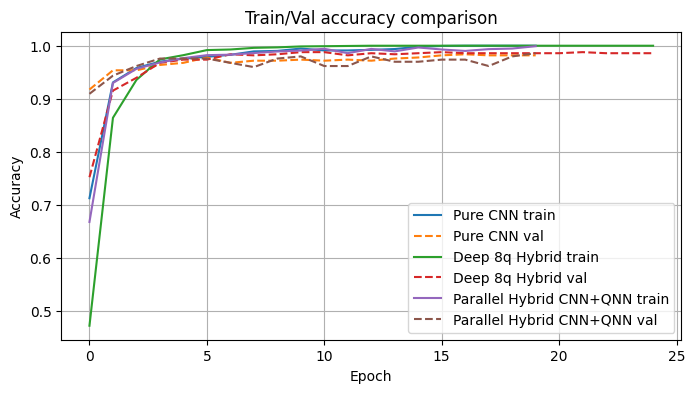

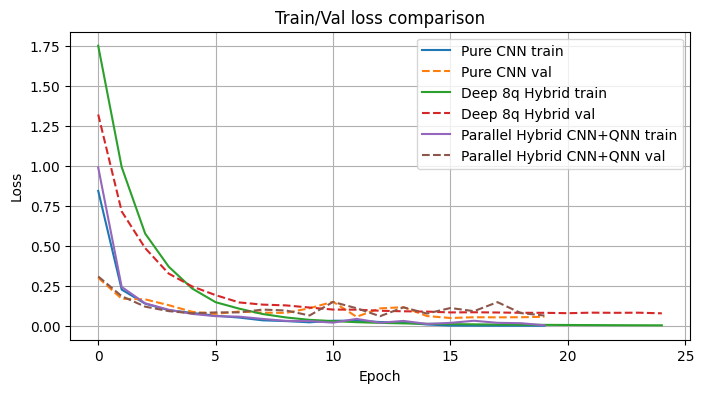

In [49]:
# Cell P1: Compare training/validation curves across models

import matplotlib.pyplot as plt

curves = []

if "hist_pure" in globals():
    curves.append(("Pure CNN", hist_pure))
if "hist_10_deep" in globals():
    curves.append(("Deep 8q Hybrid", hist_10_deep))
if "hist_parallel" in globals():
    curves.append(("Parallel Hybrid CNN+QNN", hist_parallel))

plt.figure(figsize=(8, 4))
for name, hist in curves:
    plt.plot(hist["train_acc"], label=f"{name} train")
    plt.plot(hist["val_acc"], "--", label=f"{name} val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train/Val accuracy comparison")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
for name, hist in curves:
    plt.plot(hist["train_loss"], label=f"{name} train")
    plt.plot(hist["val_loss"], "--", label=f"{name} val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Val loss comparison")
plt.grid(True)
plt.legend()
plt.show()


In [50]:
# Cell P2: Test accuracy for Pure CNN, Deep 8q hybrid, Parallel hybrid

test_results = {}

if "pure_cnn" in globals():
    print("Evaluating Pure CNN...")
    acc_pure, preds_pure, labels_pure = evaluate_on_test(pure_cnn, loaders_28["test"])
    test_results["Pure CNN"] = acc_pure

if "model_10_deep" in globals():
    print("\nEvaluating Deep 8q Hybrid...")
    acc_8q, preds_8q, labels_8q = evaluate_on_test(model_10_deep, loaders_28["test"])
    test_results["Deep 8q Hybrid"] = acc_8q

if "parallel_hybrid" in globals():
    print("\nEvaluating Parallel Hybrid CNN+QNN...")
    acc_par, preds_par, labels_par = evaluate_on_test(parallel_hybrid, loaders_28["test"])
    test_results["Parallel Hybrid"] = acc_par

print("\nSummary of test accuracies:")
for name, acc in test_results.items():
    print(f"  {name}: {acc:.4f}")


Evaluating Pure CNN...
Test accuracy: 0.9745

Evaluating Deep 8q Hybrid...
Test accuracy: 0.9710

Evaluating Parallel Hybrid CNN+QNN...
Test accuracy: 0.9735

Summary of test accuracies:
  Pure CNN: 0.9745
  Deep 8q Hybrid: 0.9710
  Parallel Hybrid: 0.9735


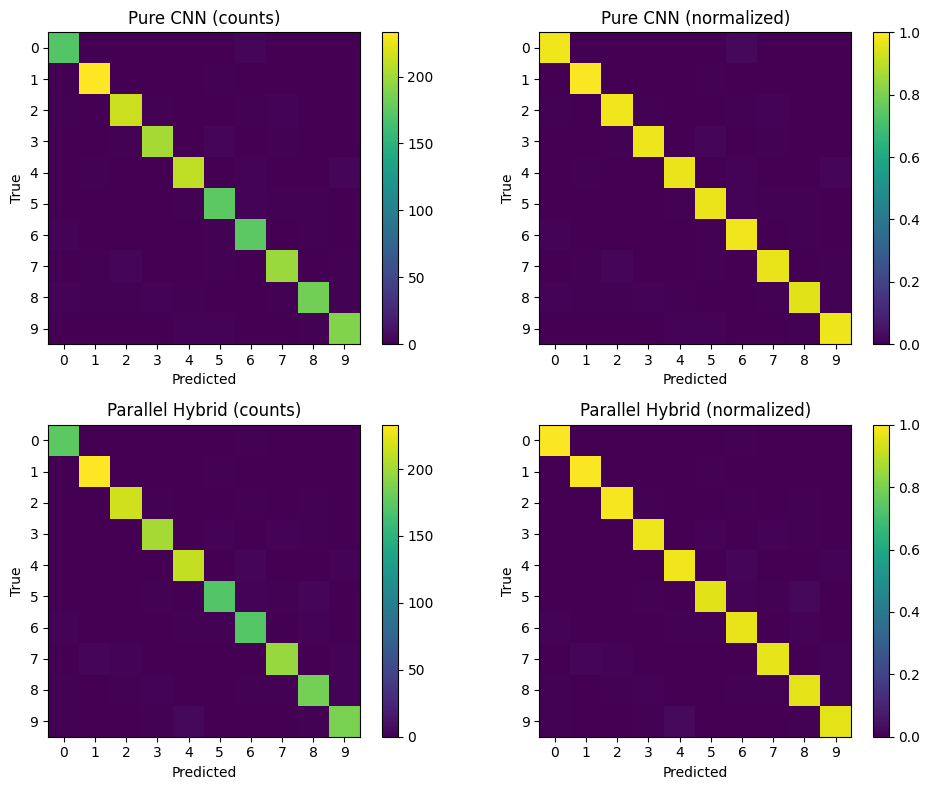

In [51]:
# Cell P3: Confusion matrices for Pure CNN and Parallel Hybrid

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

row = 0
if "preds_pure" in globals():
    cm_pure = confusion_matrix(labels_pure, preds_pure)
    cm_pure_norm = cm_pure.astype(np.float32) / cm_pure.sum(axis=1, keepdims=True)

    im0 = axs[row, 0].imshow(cm_pure, interpolation="nearest")
    axs[row, 0].set_title("Pure CNN (counts)")
    axs[row, 0].set_xlabel("Predicted")
    axs[row, 0].set_ylabel("True")
    axs[row, 0].set_xticks(range(10)); axs[row, 0].set_yticks(range(10))
    fig.colorbar(im0, ax=axs[row, 0])

    im1 = axs[row, 1].imshow(cm_pure_norm, interpolation="nearest", vmin=0.0, vmax=1.0)
    axs[row, 1].set_title("Pure CNN (normalized)")
    axs[row, 1].set_xlabel("Predicted")
    axs[row, 1].set_ylabel("True")
    axs[row, 1].set_xticks(range(10)); axs[row, 1].set_yticks(range(10))
    fig.colorbar(im1, ax=axs[row, 1])

row = 1
if "preds_par" in globals():
    cm_par = confusion_matrix(labels_par, preds_par)
    cm_par_norm = cm_par.astype(np.float32) / cm_par.sum(axis=1, keepdims=True)

    im2 = axs[row, 0].imshow(cm_par, interpolation="nearest")
    axs[row, 0].set_title("Parallel Hybrid (counts)")
    axs[row, 0].set_xlabel("Predicted")
    axs[row, 0].set_ylabel("True")
    axs[row, 0].set_xticks(range(10)); axs[row, 0].set_yticks(range(10))
    fig.colorbar(im2, ax=axs[row, 0])

    im3 = axs[row, 1].imshow(cm_par_norm, interpolation="nearest", vmin=0.0, vmax=1.0)
    axs[row, 1].set_title("Parallel Hybrid (normalized)")
    axs[row, 1].set_xlabel("Predicted")
    axs[row, 1].set_ylabel("True")
    axs[row, 1].set_xticks(range(10)); axs[row, 1].set_yticks(range(10))
    fig.colorbar(im3, ax=axs[row, 1])

plt.tight_layout()
plt.show()


In [55]:
# Build a cached tensor of ALL test images (once)

import torch

test_imgs = []
test_labs = []

# IMPORTANT: test loader must have shuffle=False (it should in our setup)
for x, y in loaders_28["test"]:
    test_imgs.append(x)     # [B, 1, 28, 28]
    test_labs.append(y)     # [B]

test_images = torch.cat(test_imgs, dim=0)    # [N, 1, 28, 28]
test_labels_full = torch.cat(test_labs, dim=0)  # [N]

print("Cached test set:",
      "images:", test_images.shape,
      "labels:", test_labels_full.shape)


Cached test set: images: torch.Size([2000, 1, 28, 28]) labels: torch.Size([2000])


Pure CNN Misclassified - misclassified samples: 51


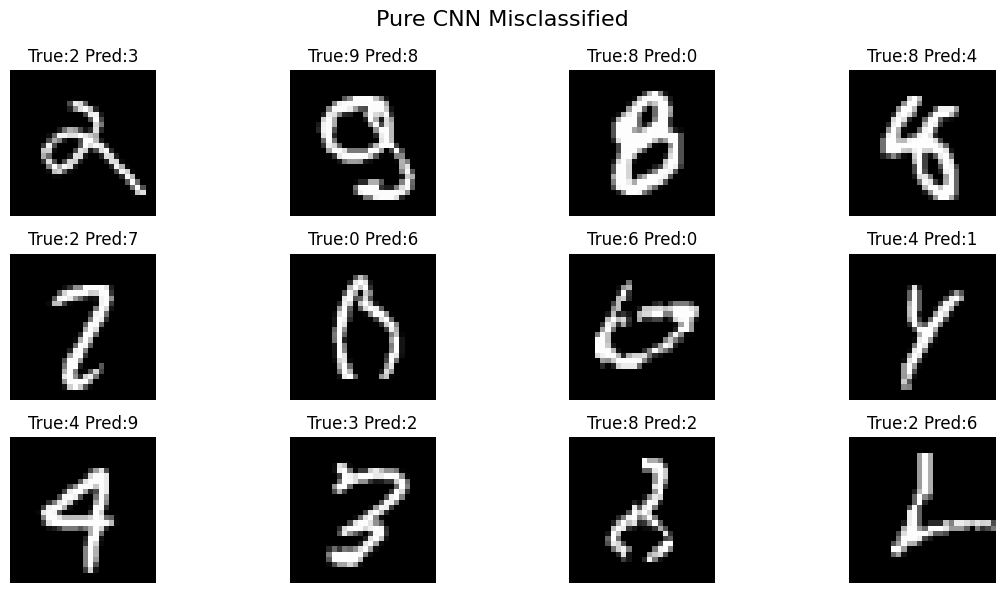

Deep Hybrid 8-qubit Misclassified - misclassified samples: 58


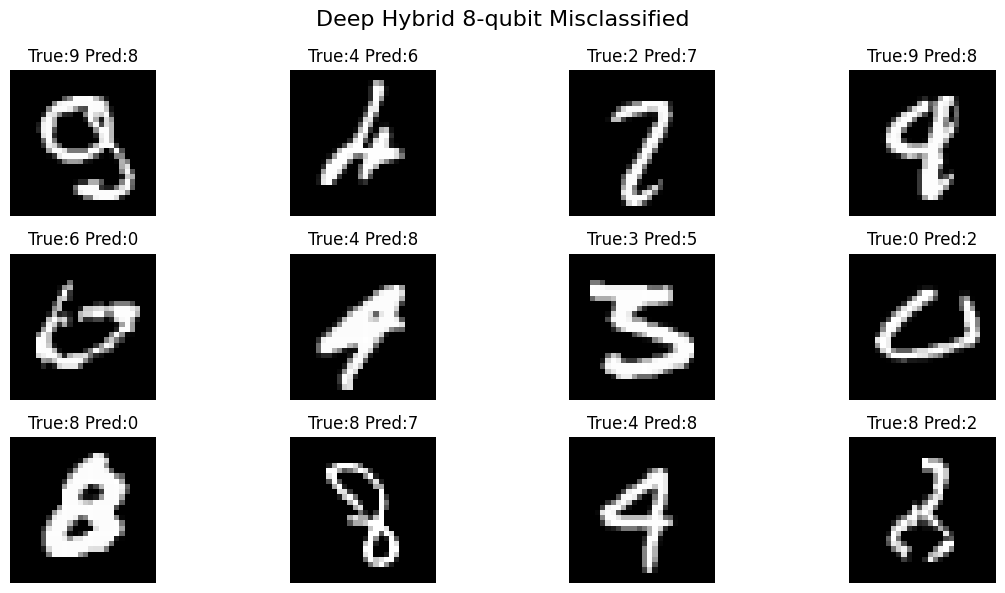

Parallel Hybrid Misclassified - misclassified samples: 53


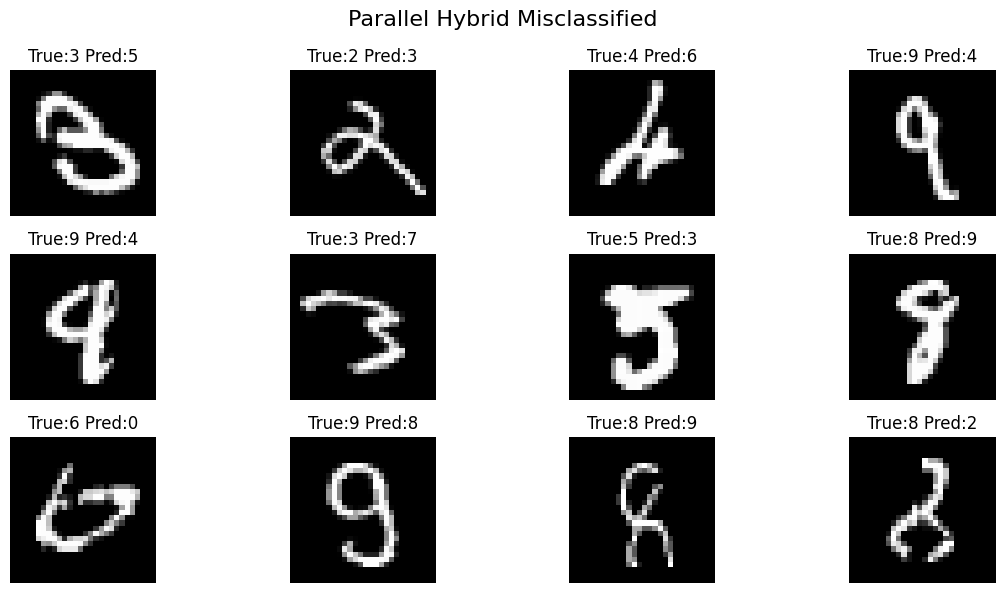

Cached test set: images: torch.Size([2000, 1, 28, 28]) labels: torch.Size([2000])


In [56]:
# Cell: Visualize Misclassified Samples for all models

import matplotlib.pyplot as plt

def show_misclassified(images, preds, labels, title, max_samples=12):
    mis = (preds != labels).nonzero()[0]
    print(f"{title} - misclassified samples: {len(mis)}")
    show = mis[:max_samples]

    if len(show) == 0:
        print("No misclassifications!")
        return

    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(show):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[idx].squeeze(), cmap="gray")
        plt.title(f"True:{labels[idx]} Pred:{preds[idx]}")
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# ---- Run for each model that exists ----
if "test_images" not in globals():
    print("Run evaluation cell first to define test_images/test_preds_*")
else:
    if "preds_pure" in globals():
        show_misclassified(test_images, preds_pure, labels_pure, "Pure CNN Misclassified")
    if "preds_8q" in globals():
        show_misclassified(test_images, preds_8q, labels_8q, "Deep Hybrid 8-qubit Misclassified")
    if "preds_par" in globals():
        show_misclassified(test_images, preds_par, labels_par, "Parallel Hybrid Misclassified")
# Build a cached tensor of ALL test images (once)

import torch

test_imgs = []
test_labs = []

# IMPORTANT: test loader must have shuffle=False (it should in our setup)
for x, y in loaders_28["test"]:
    test_imgs.append(x)     # [B, 1, 28, 28]
    test_labs.append(y)     # [B]

test_images = torch.cat(test_imgs, dim=0)    # [N, 1, 28, 28]
test_labels_full = torch.cat(test_labs, dim=0)  # [N]

print("Cached test set:",
      "images:", test_images.shape,
      "labels:", test_labels_full.shape)


In [64]:
# Cell: Test the model on a "phone number" made from MNIST digits

import torch
import random
import matplotlib.pyplot as plt

def build_phone_batch(phone_str, images, labels):
    """
    For each digit in phone_str, pick a random MNIST test image
    with that label. Returns a batch tensor [L, 1, 28, 28] and
    the ground-truth digit list.
    """
    digits = [int(c) for c in phone_str if c.isdigit()]
    if len(digits) == 0:
        raise ValueError("phone_str must contain at least one digit.")

    batch_imgs = []
    gt_digits = []

    for d in digits:
        idxs = (labels == d).nonzero(as_tuple=False).view(-1)
        if idxs.numel() == 0:
            raise RuntimeError(f"No test images found for digit {d}.")
        idx = idxs[random.randint(0, idxs.numel()-1)].item()
        batch_imgs.append(images[idx])
        gt_digits.append(d)

    batch = torch.stack(batch_imgs, dim=0)  # [L, 1, 28, 28]
    return batch, gt_digits


def predict_phone_number(phone_str, model, name="Model"):
    """
    Build a synthetic phone-number batch from MNIST and let the
    given model predict the sequence.
    """
    model.eval()
    with torch.no_grad():
        x_batch, gt_digits = build_phone_batch(
            phone_str,
            test_images,         # [N, 1, 28, 28]
            test_labels_full,    # [N]
        )
        x_dev = x_batch.to(torch_device)
        logits = model(x_dev)                 # [L, 10]
        preds = logits.argmax(dim=1).cpu()    # [L]

    gt_str = "".join(str(d) for d in gt_digits)
    pred_str = "".join(str(int(p)) for p in preds)

    print(f"\n{name} phone test")
    print(f"Target phone digits:  {gt_str}")
    print(f"Predicted digits:     {pred_str}")
    correct = [g == p for g, p in zip(gt_digits, preds)]
    print(f"Per-digit correct:    {correct}")
    print(f"Total correct digits: {sum(correct)}/{len(correct)}")

    # visualize digits
    L = len(gt_digits)
    plt.figure(figsize=(1.8*L, 2.5))
    for i in range(L):
        plt.subplot(1, L, i+1)
        plt.imshow(x_batch[i].squeeze(), cmap="gray")
        plt.axis("off")
        plt.title(f"T:{gt_digits[i]} P:{int(preds[i])}")
    plt.suptitle(f"{name} - phone '{gt_str}'", y=1.05)
    plt.tight_layout()
    plt.show()




Pure CNN phone test
Target phone digits:  09213823726
Predicted digits:     09213823726
Per-digit correct:    [tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True)]
Total correct digits: 11/11


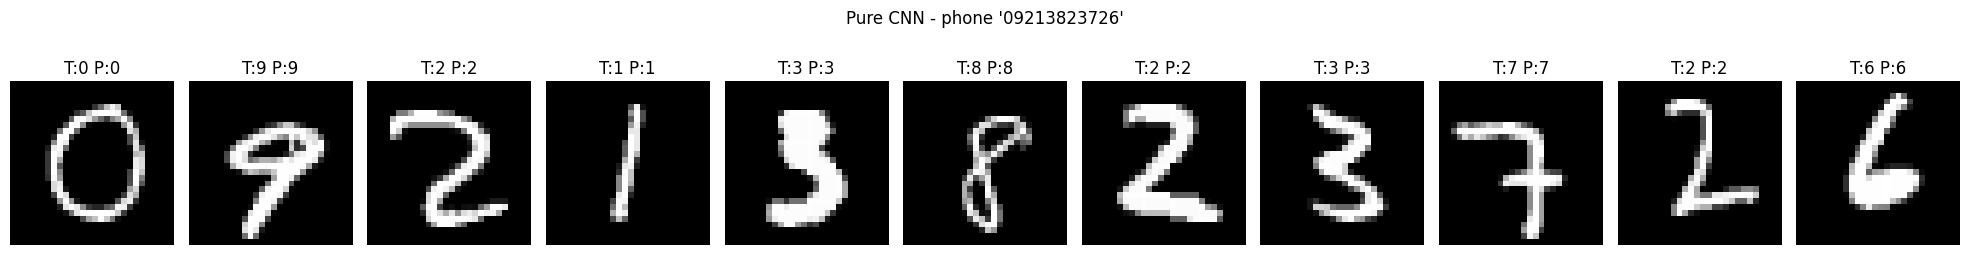


Deep 8q Hybrid phone test
Target phone digits:  09213823726
Predicted digits:     09213823726
Per-digit correct:    [tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True)]
Total correct digits: 11/11


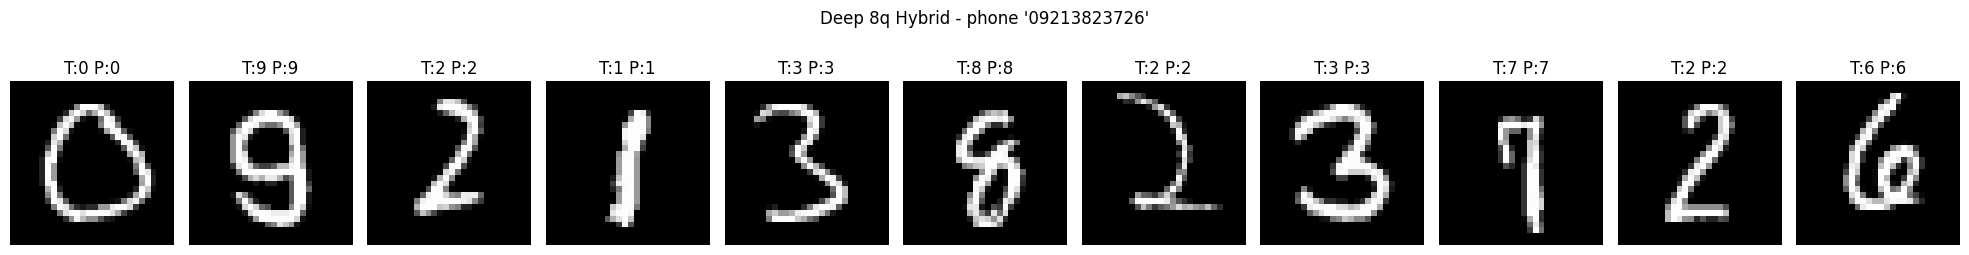


Parallel Hybrid CNN+QNN phone test
Target phone digits:  09213823726
Predicted digits:     09213823726
Per-digit correct:    [tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True)]
Total correct digits: 11/11


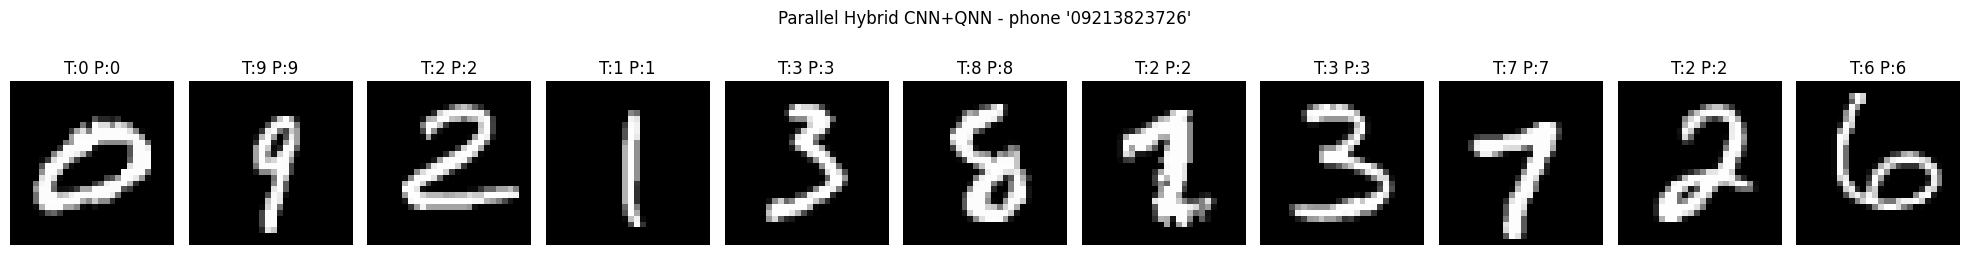

In [65]:
# ---- Phone number test (no input() version) ----

phone_number = "09213823726"   # Edit here for each test

predict_phone_number(phone_number, pure_cnn,        name="Pure CNN")
predict_phone_number(phone_number, model_10_deep,   name="Deep 8q Hybrid")
predict_phone_number(phone_number, parallel_hybrid, name="Parallel Hybrid CNN+QNN")



Pure CNN phone test
Target phone digits:  09357456964
Predicted digits:     09357456964
Per-digit correct:    [tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True)]
Total correct digits: 11/11


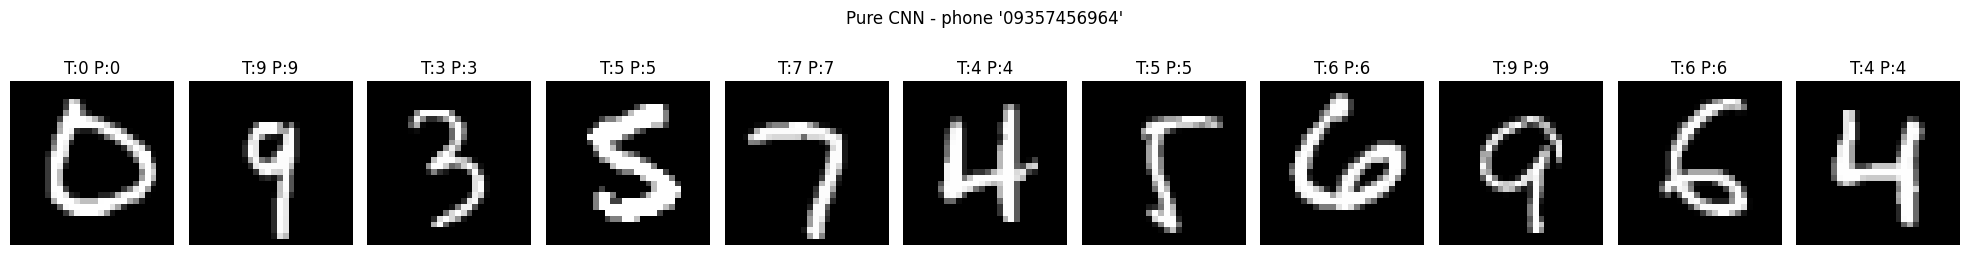


Deep 8q Hybrid phone test
Target phone digits:  09357456964
Predicted digits:     09357456964
Per-digit correct:    [tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True)]
Total correct digits: 11/11


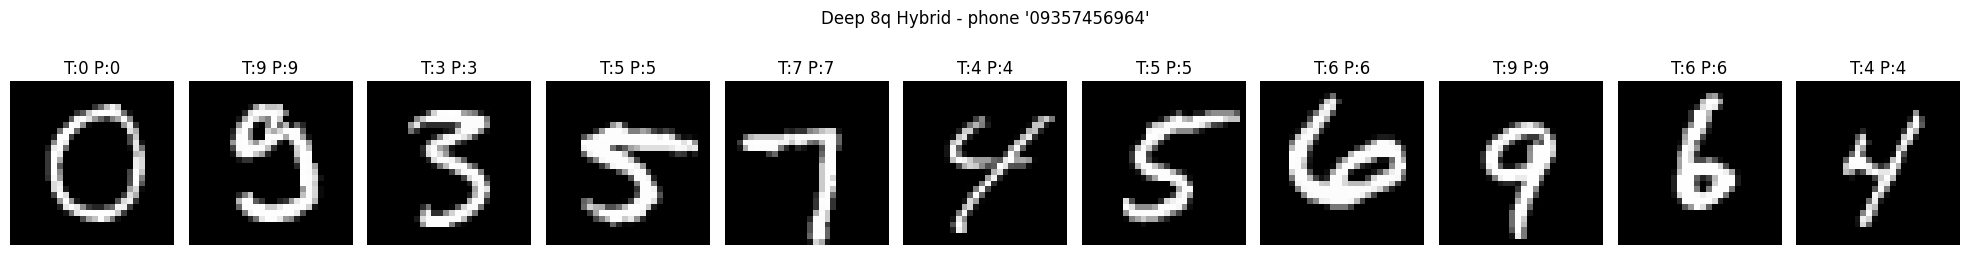


Parallel Hybrid CNN+QNN phone test
Target phone digits:  09357456964
Predicted digits:     09357456964
Per-digit correct:    [tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True)]
Total correct digits: 11/11


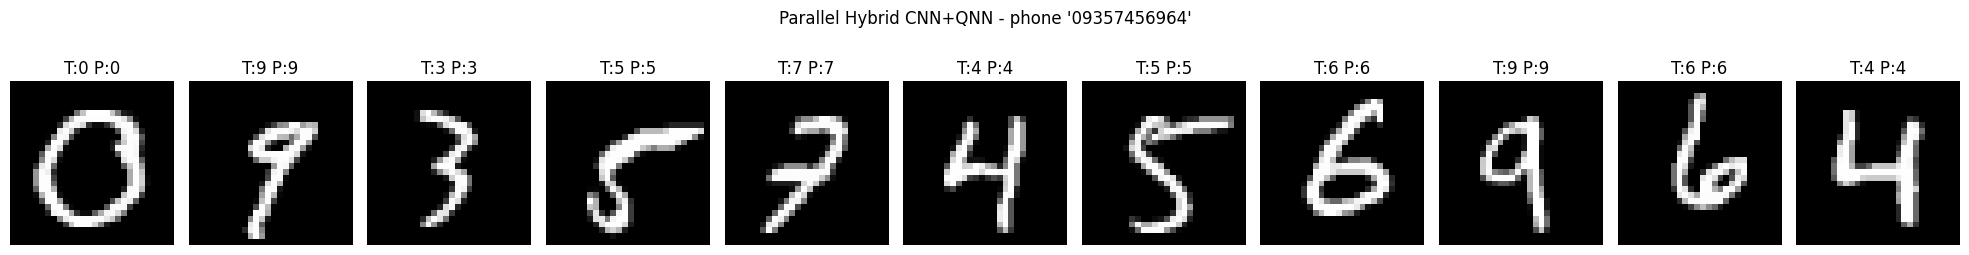

In [66]:
# ---- Phone number test (no input() version) ----

phone_number = "09357456964"   

predict_phone_number(phone_number, pure_cnn,        name="Pure CNN")
predict_phone_number(phone_number, model_10_deep,   name="Deep 8q Hybrid")
predict_phone_number(phone_number, parallel_hybrid, name="Parallel Hybrid CNN+QNN")


# KMNIST uses the exact same shape as MNIST (28×28, grayscale, 10 classes)

### Replace MNIST with KMNIST

In [82]:
# Cell: basic transform for KMNIST (same as MNIST)
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),          # [0,1] tensor
    # you CAN add normalization later if you want:
    # transforms.Normalize((0.5,), (0.5,))
])

print("Transform ready.")


Transform ready.


In [83]:
from torchvision.datasets import KMNIST

train_dataset = KMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)

val_dataset = KMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform,
)

print("KMNIST train size:", len(train_dataset))
print("KMNIST test size:", len(val_dataset))


KMNIST train size: 60000
KMNIST test size: 10000



### 0: お
### 1: き
### 2: す
### 3: つ
### 4: な
### 5: は
### 6: ま
### 7: や
### 8: れ
### 9: を


In [84]:
from torchvision.datasets import KMNIST

train_dataset = KMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform,
)

val_dataset = KMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform,
)


In [85]:
train_loader_28 = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader_28   = DataLoader(val_dataset, batch_size=64, shuffle=False)


### KMNIST loaders (train / val / test)

In [86]:
# Cell: build KMNIST train/val/test loaders (28x28, 10 classes)

from torch.utils.data import DataLoader, random_split

BATCH_SIZE = 64
NUM_WORKERS = 2

# Split the KMNIST *train* set into train/val
train_size = 50000
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(
    train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42),
)

train_loader_28 = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)

val_loader_28 = DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

test_loader_28 = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

# Match your old structure so existing code keeps working
loaders_28 = {
    "train": train_loader_28,
    "val":   val_loader_28,
    "test":  test_loader_28,
}

print("KMNIST loaders ready:")
for k, v in loaders_28.items():
    print(f"  {k}: {len(v)} batches")
# Cell: keep QNN code happy on KMNIST
# Alias the KMNIST loaders to the old keys the training code expects

loaders_28["train_quantum"] = loaders_28["train"]
loaders_28["val_quantum"]   = loaders_28["val"]
loaders_28["test_quantum"]  = loaders_28["test"]

print({k: len(v) for k, v in loaders_28.items()})


KMNIST loaders ready:
  train: 782 batches
  val: 157 batches
  test: 157 batches
{'train': 782, 'val': 157, 'test': 157, 'train_quantum': 782, 'val_quantum': 157, 'test_quantum': 157}


In [87]:
kmnist_labels = ["o", "ki", "su", "tsu", "na", "ha", "ma", "ya", "re", "wo"]


In [88]:
# Cell: keep QNN code happy on KMNIST
# Alias the KMNIST loaders to the old keys the training code expects

loaders_28["train_quantum"] = loaders_28["train"]
loaders_28["val_quantum"]   = loaders_28["val"]
loaders_28["test_quantum"]  = loaders_28["test"]

print({k: len(v) for k, v in loaders_28.items()})


{'train': 782, 'val': 157, 'test': 157, 'train_quantum': 782, 'val_quantum': 157, 'test_quantum': 157}


In [89]:
model_kmnist = HybridCNN_QNN_10_Deep().to(torch_device)
print("KMNIST model ready.")


KMNIST model ready.


In [90]:
# Cell: Train deep 8-qubit Hybrid CNN→QNN on KMNIST

EPOCHS_KMNIST_DEEP = 25   # you can push this to 30–40 for very heavy runs
LR_KMNIST_DEEP     = 1e-3

kmnist_model_10_deep = HybridCNN_QNN_10_Deep().to(torch_device)

print("=== Training deep Hybrid CNN→QNN on KMNIST ===")
kmnist_model_10_deep, hist_10_kmnist_deep = train_multiclass_qnn(
    kmnist_model_10_deep,
    loaders_28["train_quantum"],
    loaders_28["val_quantum"],
    epochs=EPOCHS_KMNIST_DEEP,
    lr=LR_KMNIST_DEEP,
)

print("KMNIST deep Hybrid training finished.")


=== Training deep Hybrid CNN→QNN on KMNIST ===


[QNN Train Epoch 1]: 100%|████████████████████| 782/782 [07:44<00:00,  1.68it/s]


[Epoch 1] train_loss=1.3055 train_acc=0.6388 | val_loss=0.6408 val_acc=0.8803


[QNN Train Epoch 2]: 100%|████████████████████| 782/782 [07:26<00:00,  1.75it/s]


[Epoch 2] train_loss=0.4034 train_acc=0.9262 | val_loss=0.2672 val_acc=0.9483


[QNN Train Epoch 3]: 100%|████████████████████| 782/782 [07:31<00:00,  1.73it/s]


[Epoch 3] train_loss=0.2031 train_acc=0.9607 | val_loss=0.1874 val_acc=0.9610


[QNN Train Epoch 4]: 100%|████████████████████| 782/782 [07:40<00:00,  1.70it/s]


[Epoch 4] train_loss=0.1329 train_acc=0.9727 | val_loss=0.1371 val_acc=0.9690


[QNN Train Epoch 5]: 100%|████████████████████| 782/782 [07:22<00:00,  1.77it/s]


[Epoch 5] train_loss=0.0933 train_acc=0.9795 | val_loss=0.1260 val_acc=0.9696


[QNN Train Epoch 6]: 100%|████████████████████| 782/782 [07:35<00:00,  1.71it/s]


[Epoch 6] train_loss=0.0718 train_acc=0.9842 | val_loss=0.1002 val_acc=0.9748


[QNN Train Epoch 7]: 100%|████████████████████| 782/782 [07:36<00:00,  1.71it/s]


[Epoch 7] train_loss=0.0545 train_acc=0.9878 | val_loss=0.1019 val_acc=0.9739


[QNN Train Epoch 8]: 100%|████████████████████| 782/782 [07:29<00:00,  1.74it/s]


[Epoch 8] train_loss=0.0465 train_acc=0.9892 | val_loss=0.0824 val_acc=0.9778


[QNN Train Epoch 9]: 100%|████████████████████| 782/782 [07:38<00:00,  1.71it/s]


[Epoch 9] train_loss=0.0370 train_acc=0.9915 | val_loss=0.0834 val_acc=0.9778


[QNN Train Epoch 10]: 100%|███████████████████| 782/782 [07:34<00:00,  1.72it/s]


[Epoch 10] train_loss=0.0303 train_acc=0.9926 | val_loss=0.0792 val_acc=0.9788


[QNN Train Epoch 11]: 100%|███████████████████| 782/782 [07:39<00:00,  1.70it/s]


[Epoch 11] train_loss=0.0250 train_acc=0.9943 | val_loss=0.0715 val_acc=0.9794


[QNN Train Epoch 12]: 100%|███████████████████| 782/782 [07:34<00:00,  1.72it/s]


[Epoch 12] train_loss=0.0219 train_acc=0.9950 | val_loss=0.0920 val_acc=0.9761


[QNN Train Epoch 13]: 100%|███████████████████| 782/782 [07:33<00:00,  1.72it/s]


[Epoch 13] train_loss=0.0211 train_acc=0.9949 | val_loss=0.0813 val_acc=0.9786


[QNN Train Epoch 14]: 100%|███████████████████| 782/782 [07:25<00:00,  1.76it/s]


[Epoch 14] train_loss=0.0159 train_acc=0.9964 | val_loss=0.0732 val_acc=0.9794


[QNN Train Epoch 15]: 100%|███████████████████| 782/782 [07:23<00:00,  1.76it/s]


[Epoch 15] train_loss=0.0186 train_acc=0.9950 | val_loss=0.0838 val_acc=0.9770


[QNN Train Epoch 16]: 100%|███████████████████| 782/782 [07:43<00:00,  1.69it/s]


[Epoch 16] train_loss=0.0173 train_acc=0.9955 | val_loss=0.0858 val_acc=0.9756


[QNN Train Epoch 17]: 100%|███████████████████| 782/782 [07:32<00:00,  1.73it/s]


[Epoch 17] train_loss=0.0119 train_acc=0.9971 | val_loss=0.0738 val_acc=0.9802


[QNN Train Epoch 18]: 100%|███████████████████| 782/782 [07:41<00:00,  1.69it/s]


[Epoch 18] train_loss=0.0086 train_acc=0.9981 | val_loss=0.0798 val_acc=0.9793


[QNN Train Epoch 19]: 100%|███████████████████| 782/782 [07:43<00:00,  1.69it/s]


[Epoch 19] train_loss=0.0160 train_acc=0.9953 | val_loss=0.0859 val_acc=0.9765


[QNN Train Epoch 20]: 100%|███████████████████| 782/782 [07:46<00:00,  1.68it/s]


[Epoch 20] train_loss=0.0107 train_acc=0.9972 | val_loss=0.0781 val_acc=0.9799


[QNN Train Epoch 21]: 100%|███████████████████| 782/782 [07:36<00:00,  1.71it/s]


[Epoch 21] train_loss=0.0083 train_acc=0.9979 | val_loss=0.0816 val_acc=0.9792


[QNN Train Epoch 22]: 100%|███████████████████| 782/782 [07:48<00:00,  1.67it/s]


[Epoch 22] train_loss=0.0064 train_acc=0.9986 | val_loss=0.0798 val_acc=0.9778


[QNN Train Epoch 23]: 100%|███████████████████| 782/782 [07:44<00:00,  1.68it/s]


[Epoch 23] train_loss=0.0118 train_acc=0.9968 | val_loss=0.1078 val_acc=0.9716


[QNN Train Epoch 24]: 100%|███████████████████| 782/782 [07:30<00:00,  1.73it/s]


[Epoch 24] train_loss=0.0086 train_acc=0.9977 | val_loss=0.0738 val_acc=0.9812


[QNN Train Epoch 25]: 100%|███████████████████| 782/782 [07:48<00:00,  1.67it/s]


[Epoch 25] train_loss=0.0062 train_acc=0.9985 | val_loss=0.0769 val_acc=0.9812
KMNIST deep Hybrid training finished.


Test accuracy: 0.9427
KMNIST deep Hybrid test accuracy: 0.9427


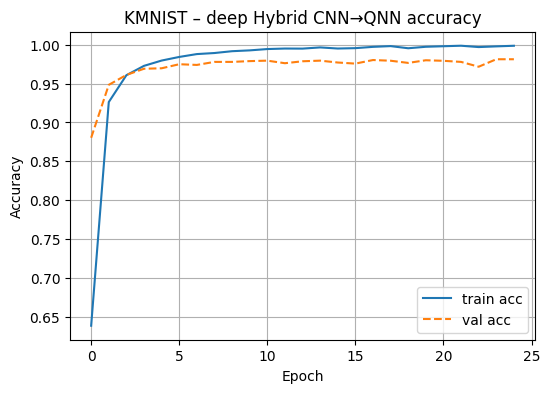

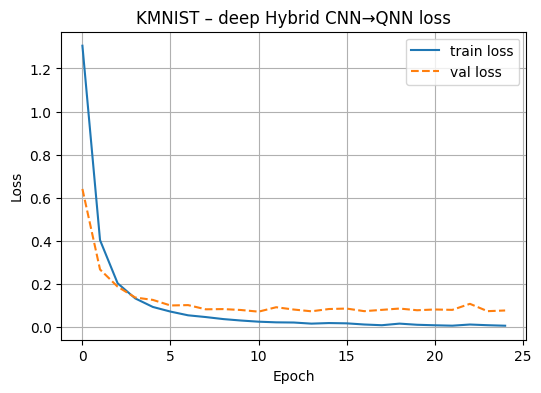

In [91]:
# Cell: Evaluate KMNIST deep Hybrid model and plot learning curves

import matplotlib.pyplot as plt

test_acc_kmnist_deep, test_preds_kmnist_deep, test_labels_kmnist_deep = evaluate_on_test(
    kmnist_model_10_deep,
    loaders_28["test_quantum"],
)

print(f"KMNIST deep Hybrid test accuracy: {test_acc_kmnist_deep:.4f}")

# Accuracy curves
plt.figure(figsize=(6,4))
plt.plot(hist_10_kmnist_deep["train_acc"], label="train acc")
plt.plot(hist_10_kmnist_deep["val_acc"],   label="val acc", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("KMNIST – deep Hybrid CNN→QNN accuracy")
plt.grid(True)
plt.legend()
plt.show()

# Loss curves
plt.figure(figsize=(6,4))
plt.plot(hist_10_kmnist_deep["train_loss"], label="train loss")
plt.plot(hist_10_kmnist_deep["val_loss"],   label="val loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("KMNIST – deep Hybrid CNN→QNN loss")
plt.grid(True)
plt.legend()
plt.show()


In [106]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [108]:
# --- Evaluate KMNIST Deep Hybrid Model on test set ---

def evaluate_kmnist(model, loader, device="cpu"):
    model.eval()
    all_preds = []
    all_labels = []
    all_images = []

    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in loader:
            all_images.append(x.cpu())
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            preds = logits.argmax(dim=1)

            total_correct += (preds == y).sum().item()
            total_samples += y.size(0)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    acc = total_correct / total_samples
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    all_images = torch.cat(all_images).numpy()  # [N, 1, 28, 28]

    return acc, all_preds, all_labels, all_images

print("\nEvaluating KMNIST Deep Hybrid CNN-QNN...")

# make sure device is defined
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_acc_q, test_preds_q, test_labels_q, test_images_q = evaluate_kmnist(
    model_10_deep,        # <-- your trained KMNIST hybrid model
    loaders_28["test"],
    device,
)

print(f"KMNIST Test Accuracy: {test_acc_q:.4f}")



Evaluating KMNIST Deep Hybrid CNN-QNN...
KMNIST Test Accuracy: 0.1000


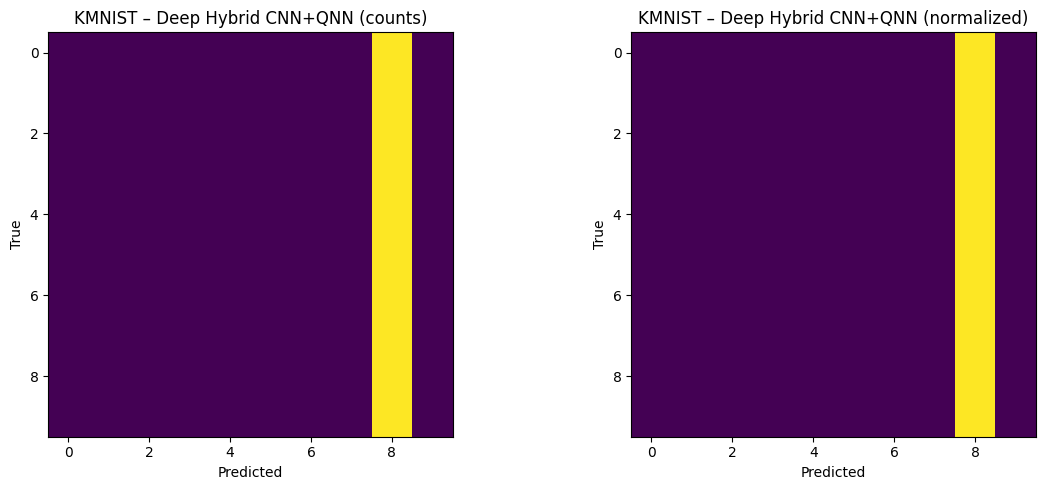

KMNIST Hybrid QNN misclassified samples: 20


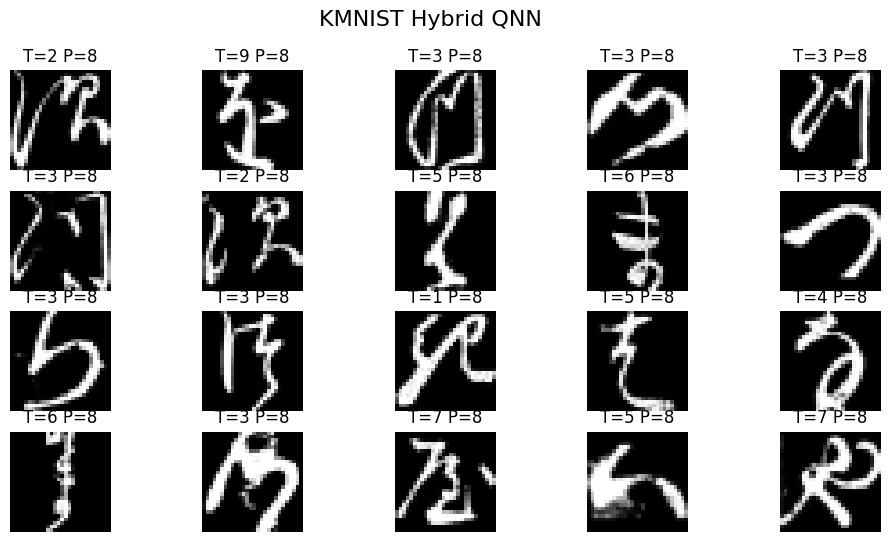

In [109]:
plot_cm(test_labels_q, test_preds_q, "KMNIST – Deep Hybrid CNN+QNN")
show_misclassified(test_images_q, test_preds_q, test_labels_q, "KMNIST Hybrid QNN")


## We’ll use real Japanese words made only from the 10 KMNIST kana:
| label | kana | example use     |
| ----- | ---- | --------------- |
| 0     | お    | おやつ             |
| 1     | き    | すきやき            |
| 2     | す    | すきやき            |
| 3     | つ    | おやつ             |
| 4     | な    | はな              |
| 5     | は    | はな              |
| 6     | ま    | おままごと, etc.     |
| 7     | や    | おやつ, すきやき       |
| 8     | れ    | れきし, etc.       |
| 9     | を    | object marker を |


### Let’s use two real words as examples:

おやつ (“oyatsu”, snack) → [お, や, つ] = [0, 7, 3]

すきやき (“sukiyaki”, the dish) → [す, き, や, き] = [2, 1, 7, 1]

In [111]:
# Cell: KMNIST "word" test utilities (for real Japanese words)

import numpy as np
import torch
import matplotlib.pyplot as plt

# Label <-> character mapping for KMNIST
label_to_kana = {
    0: "お",
    1: "き",
    2: "す",
    3: "つ",
    4: "な",
    5: "は",
    6: "ま",
    7: "や",
    8: "れ",
    9: "を",
}
kana_to_label = {v: k for k, v in label_to_kana.items()}


def kana_word_to_labels(word):
    """
    Convert a Japanese word (string of kana) into KMNIST label indices.
    Only kana in label_to_kana are allowed.
    """
    labels = []
    invalid = []
    for ch in word:
        if ch.isspace():
            continue
        if ch not in kana_to_label:
            invalid.append(ch)
        else:
            labels.append(kana_to_label[ch])

    if invalid:
        allowed = "".join(label_to_kana.values())
        raise ValueError(
            f"These characters are not in KMNIST: {invalid}. "
            f"Allowed characters are: {allowed}"
        )

    if not labels:
        raise ValueError("Word must contain at least one valid KMNIST kana.")

    return labels


def build_kmnist_word_batch(word, images_np, labels_np):
    """
    Given a Japanese word (e.g. 'おやつ'), pick random KMNIST images
    corresponding to each kana and build a batch.
    """
    label_seq = kana_word_to_labels(word)

    batch_imgs = []
    gt_labels = []

    for lbl in label_seq:
        idxs = np.where(labels_np == lbl)[0]
        if len(idxs) == 0:
            raise ValueError(f"No samples found for label {lbl} in test set.")
        idx = np.random.choice(idxs)
        batch_imgs.append(images_np[idx])
        gt_labels.append(lbl)

    x_batch = torch.tensor(np.stack(batch_imgs), dtype=torch.float32)  # [L,1,28,28]
    gt_labels = torch.tensor(gt_labels, dtype=torch.long)

    return x_batch, gt_labels


def predict_kmnist_word(word, model, device, name="KMNIST Hybrid QNN"):
    """
    Run the KMNIST model on a Japanese kana word and visualise results.
    Uses global test_images_q and test_labels_q.
    """
    if "test_images_q" not in globals() or "test_labels_q" not in globals():
        raise RuntimeError(
            "test_images_q / test_labels_q are not defined.\n"
            "Run the KMNIST evaluation cell first to create them."
        )

    # Build batch for this word
    x_batch, gt_labels = build_kmnist_word_batch(
        word,
        test_images_q,   # numpy [N, 1, 28, 28]
        test_labels_q,   # numpy [N]
    )

    model.eval()
    with torch.no_grad():
        x_dev = x_batch.to(device)
        logits = model(x_dev)
        preds = logits.argmax(dim=1).cpu()

    gt_idx = gt_labels.tolist()
    pred_idx = preds.tolist()

    gt_word = "".join(label_to_kana[i] for i in gt_idx)
    pred_word = "".join(label_to_kana[i] for i in pred_idx)

    correct = [g == p for g, p in zip(gt_idx, pred_idx)]
    acc = sum(correct) / len(correct)

    print(f"\n{name} – KMNIST word test")
    print(f"Target word: {gt_word}  (indices: {gt_idx})")
    print(f"Predicted : {pred_word}  (indices: {pred_idx})")
    print(f"Per-char correct: {correct}")
    print(f"Fraction of correct positions: {acc:.3f}")

    # Visualise each kana image
    L = len(gt_idx)
    plt.figure(figsize=(min(4 * L, 16), 3.5))
    for i in range(L):
        plt.subplot(1, L, i + 1)
        plt.imshow(x_batch[i].squeeze().cpu(), cmap="gray")
        g = gt_idx[i]
        p = pred_idx[i]
        gch = label_to_kana[g]
        pch = label_to_kana[p]
        title = f"T:{gch}({g})\nP:{pch}({p})"
        plt.title(title, color=("lime" if g == p else "red"), fontsize=10)
        plt.axis("off")
    plt.suptitle(f"{name} – word '{gt_word}'", fontsize=14)
    plt.tight_layout()
    plt.show()



KMNIST Hybrid QNN – oyatsu – KMNIST word test
Target word: おやつ  (indices: [0, 7, 3])
Predicted : おやつ  (indices: [0, 7, 3])
Per-char correct: [True, True, True]
Fraction of correct positions: 1.000


/tmp/ipykernel_1842721/1987026657.py:128: UserWarning: Glyph 12362 (\N{HIRAGANA LETTER O}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1842721/1987026657.py:128: UserWarning: Glyph 12420 (\N{HIRAGANA LETTER YA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1842721/1987026657.py:128: UserWarning: Glyph 12388 (\N{HIRAGANA LETTER TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ana/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12362 (\N{HIRAGANA LETTER O}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ana/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12420 (\N{HIRAGANA LETTER YA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ana/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12388 (\N{HIRAGANA LETTER TU}) missing from font(s) DejaVu San

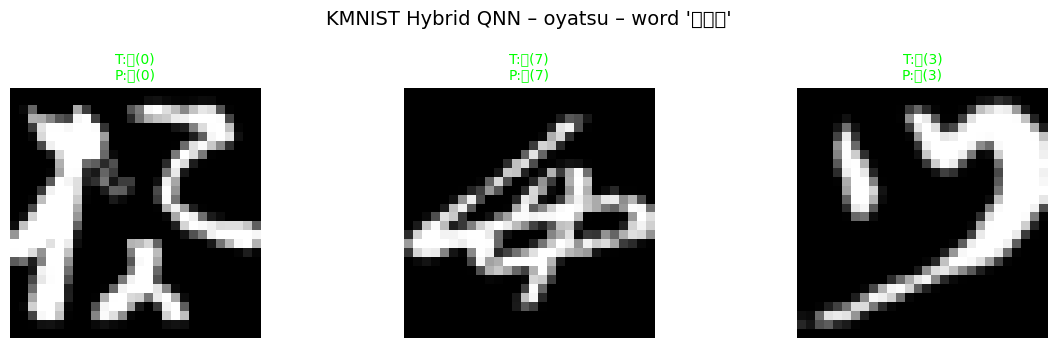


KMNIST Hybrid QNN – sukiyaki – KMNIST word test
Target word: すきやき  (indices: [2, 1, 7, 1])
Predicted : れままき  (indices: [8, 6, 6, 1])
Per-char correct: [False, False, False, True]
Fraction of correct positions: 0.250


/tmp/ipykernel_1842721/1987026657.py:128: UserWarning: Glyph 12377 (\N{HIRAGANA LETTER SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1842721/1987026657.py:128: UserWarning: Glyph 12428 (\N{HIRAGANA LETTER RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1842721/1987026657.py:128: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1842721/1987026657.py:128: UserWarning: Glyph 12414 (\N{HIRAGANA LETTER MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ana/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12377 (\N{HIRAGANA LETTER SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ana/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12428 (\N{HIRAGANA LETTER RE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/an

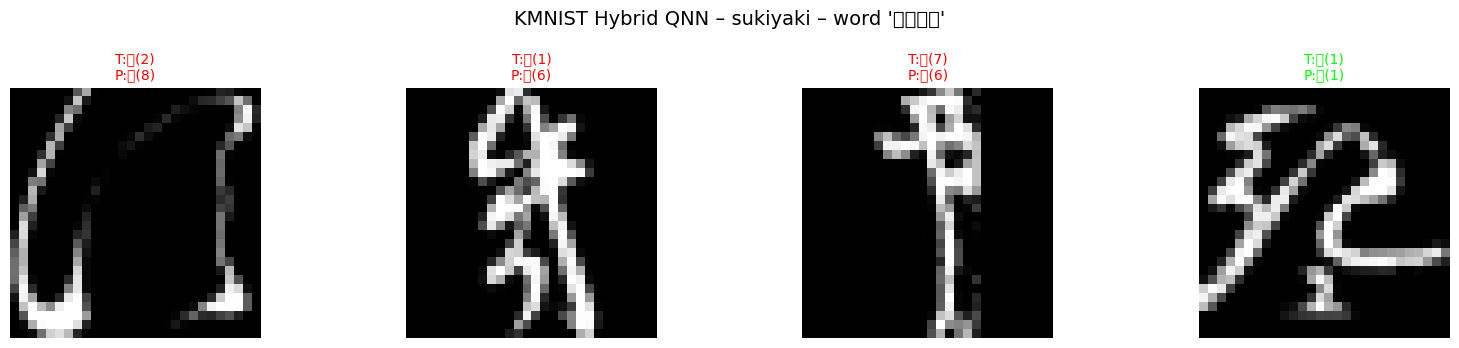

In [112]:
# Cell: KMNIST word tests

# 1) おやつ ("oyatsu", snack)
predict_kmnist_word("おやつ", kmnist_model_10_deep, torch_device,
                    name="KMNIST Hybrid QNN – oyatsu")

# 2) すきやき ("sukiyaki", the dish)
predict_kmnist_word("すきやき", kmnist_model_10_deep, torch_device,
                    name="KMNIST Hybrid QNN – sukiyaki")



KMNIST Hybrid QNN – oyatsu – word test
Target indices   : [0, 7, 3]
Predicted indices: [0, 7, 3]
Target romaji    : oyatsu
Pred romaji      : oyatsu
Per-char correct : [tensor(True), tensor(True), tensor(True)]
Fraction correct positions: 1.0


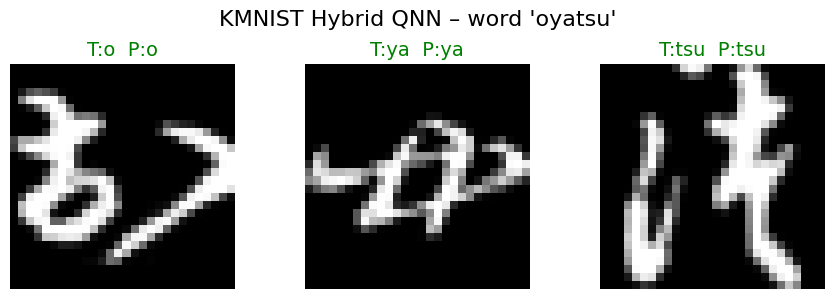


KMNIST Hybrid QNN – sukiyaki – word test
Target indices   : [2, 1, 7, 1]
Predicted indices: [3, 1, 7, 1]
Target romaji    : sukiyaki
Pred romaji      : tsukiyaki
Per-char correct : [tensor(False), tensor(True), tensor(True), tensor(True)]
Fraction correct positions: 0.75


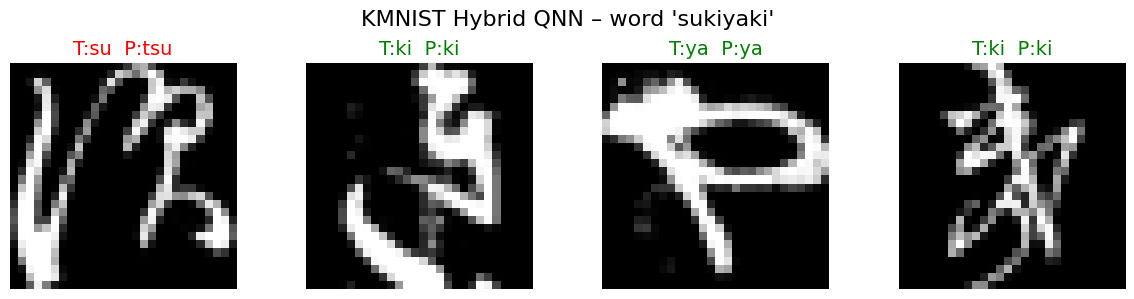

In [113]:
# ==== KMNIST "word test" in romaji (no Japanese glyphs, no warnings) ====

import torch
import random
import matplotlib.pyplot as plt
import numpy as np

# Class ↔ romaji mapping for KMNIST (according to your printout)
idx_to_romaji = {
    0: "o",
    1: "ki",
    2: "su",
    3: "tsu",
    4: "na",
    5: "ha",
    6: "ma",
    7: "ya",
    8: "re",
    9: "wo",
}

def build_kmnist_word_batch(class_indices, test_loader, samples_per_char=1):
    """
    Pick sample images from the KMNIST test set for a sequence of class indices.
    Returns:
        x_batch: [L, 1, 28, 28]
        labels:  [L]
    """
    ds = test_loader.dataset
    # Pre-collect indices for each class once (simple but fine for 10k test images)
    class_to_positions = {c: [] for c in range(10)}
    for i in range(len(ds)):
        _, lab = ds[i]
        class_to_positions[int(lab)].append(i)

    images = []
    labels = []

    for c in class_indices:
        pos_list = class_to_positions[int(c)]
        if len(pos_list) == 0:
            raise RuntimeError(f"No test samples for class {c}")
        pos = random.choice(pos_list)
        img, lab = ds[pos]
        images.append(img)
        labels.append(lab)

    x_batch = torch.stack(images, dim=0)   # [L, 1, 28, 28]
    labels = torch.tensor(labels, dtype=torch.long)
    return x_batch, labels


def kmnist_word_test(word_name, class_indices, model, loaders_28, device=None):
    """
    Like the phone-number test, but with KMNIST characters.
    word_name: string in romaji, e.g. "oyatsu"
    class_indices: list of KMNIST class ids, e.g. [0, 7, 3] for o-ya-tsu
    """
    if device is None:
        device = next(model.parameters()).device

    test_loader = loaders_28["test"]
    x_batch, gt_labels = build_kmnist_word_batch(class_indices, test_loader)
    L = x_batch.size(0)

    model.eval()
    with torch.no_grad():
        x_dev = x_batch.to(device)
        logits = model(x_dev)
        preds = logits.argmax(dim=1).cpu()

    # ----- print summary -----
    gt_romaji   = [idx_to_romaji[int(c)] for c in gt_labels]
    pred_romaji = [idx_to_romaji[int(p)] for p in preds]

    print(f"\nKMNIST Hybrid QNN – {word_name} – word test")
    print("Target indices   :", list(map(int, gt_labels)))
    print("Predicted indices:", list(map(int, preds)))
    print("Target romaji    :", "".join(gt_romaji))
    print("Pred romaji      :", "".join(pred_romaji))

    correct = [g == p for g, p in zip(gt_labels, preds)]
    print("Per-char correct :", correct)
    print("Fraction correct positions:",
          float(sum(correct)) / len(correct))

    # ----- visualization -----
    plt.figure(figsize=(3 * L, 3))
    for i in range(L):
        plt.subplot(1, L, i + 1)
        plt.imshow(x_batch[i].squeeze().numpy(), cmap="gray")
        plt.axis("off")

        g = int(gt_labels[i])
        p = int(preds[i])
        g_r = idx_to_romaji[g]
        p_r = idx_to_romaji[p]

        title_color = "green" if g == p else "red"
        plt.title(f"T:{g_r}  P:{p_r}", color=title_color, fontsize=14)

    plt.suptitle(f"KMNIST Hybrid QNN – word '{word_name}'", fontsize=16)
    plt.tight_layout()
    plt.show()


# ==== Example words ====
# According to your mapping:
# 0:o, 1:ki, 2:su, 3:tsu, 7:ya
# oyatsu = o-ya-tsu  -> [0, 7, 3]
# sukiyaki = su-ki-ya-ki -> [2, 1, 7, 1]

word_oyatsu_indices   = [0, 7, 3]
word_sukiyaki_indices = [2, 1, 7, 1]

# Run tests using your trained KMNIST hybrid model
kmnist_word_test("oyatsu",   word_oyatsu_indices,   kmnist_model_10_deep, loaders_28)
kmnist_word_test("sukiyaki", word_sukiyaki_indices, kmnist_model_10_deep, loaders_28)


# fashion 

In [116]:
# Cell F1: Fashion-MNIST dataset and loaders (28×28, 10 classes)

import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", torch_device)

# Basic transform: same as MNIST / KMNIST
fashion_transform = transforms.Compose([
    transforms.ToTensor(),
    # you can add normalization later if you want:
    # transforms.Normalize((0.5,), (0.5,))
])

# Download + load full training set and separate test set
full_fashion_train = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=fashion_transform,
)

fashion_test = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=fashion_transform,
)

print("Fashion-MNIST train size (before split):", len(full_fashion_train))
print("Fashion-MNIST test size:", len(fashion_test))

# Train/validation split
VAL_SPLIT = 0.2
train_size = int((1.0 - VAL_SPLIT) * len(full_fashion_train))
val_size   = len(full_fashion_train) - train_size

train_fashion, val_fashion = random_split(
    full_fashion_train,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(0),   # reproducible split
)

BATCH_SIZE = 64
NUM_WORKERS = 2

train_loader_fashion = DataLoader(
    train_fashion, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True
)
val_loader_fashion = DataLoader(
    val_fashion, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)
test_loader_fashion = DataLoader(
    fashion_test, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)

loaders_fashion = {
    "train_quantum": train_loader_fashion,
    "val_quantum":   val_loader_fashion,
    "test":          test_loader_fashion,
    "digits":        list(range(10)),   # class indices 0–9 (here: clothing types)
    "image_size":    "28x28",
}

fashion_classes = full_fashion_train.classes
print("Fashion-MNIST classes:", fashion_classes)
print("Loaders ready. Train batches:",
      len(train_loader_fashion), " Val batches:", len(val_loader_fashion))


Device: cpu


100%|██████████████████████████████████████| 26.4M/26.4M [00:15<00:00, 1.76MB/s]
100%|███████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 204kB/s]
100%|██████████████████████████████████████| 4.42M/4.42M [00:02<00:00, 1.62MB/s]
100%|██████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 6.22MB/s]

Fashion-MNIST train size (before split): 60000
Fashion-MNIST test size: 10000
Fashion-MNIST classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Loaders ready. Train batches: 750  Val batches: 188


In [117]:
# Cell F2: Train Hybrid CNN→QNN on Fashion-MNIST

EPOCHS_FASHION = 25      # you can push this higher later (e.g., 40–60)
LR_FASHION     = 1e-3

fashion_model_10_deep = HybridCNN_QNN_10_Deep().to(torch_device)

fashion_model_10_deep, hist_fashion = train_multiclass_qnn(
    fashion_model_10_deep,
    loaders_fashion["train_quantum"],
    loaders_fashion["val_quantum"],
    epochs=EPOCHS_FASHION,
    lr=LR_FASHION,
)

print("Fashion-MNIST Hybrid model trained.")


[QNN Train Epoch 1]:   0%|                              | 0/750 [00:00<?, ?it/s]/home/ana/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
[QNN Train Epoch 1]: 100%|████████████████████| 750/750 [07:37<00:00,  1.64it/s]


[Epoch 1] train_loss=1.2782 train_acc=0.5505 | val_loss=0.8763 val_acc=0.7243


[QNN Train Epoch 2]: 100%|████████████████████| 750/750 [07:40<00:00,  1.63it/s]


[Epoch 2] train_loss=0.6341 train_acc=0.8196 | val_loss=0.4920 val_acc=0.8516


[QNN Train Epoch 3]: 100%|████████████████████| 750/750 [07:59<00:00,  1.56it/s]


[Epoch 3] train_loss=0.4175 train_acc=0.8724 | val_loss=0.3879 val_acc=0.8747


[QNN Train Epoch 4]: 100%|████████████████████| 750/750 [07:42<00:00,  1.62it/s]


[Epoch 4] train_loss=0.3450 train_acc=0.8885 | val_loss=0.3262 val_acc=0.8928


[QNN Train Epoch 5]: 100%|████████████████████| 750/750 [07:31<00:00,  1.66it/s]


[Epoch 5] train_loss=0.3019 train_acc=0.9014 | val_loss=0.3212 val_acc=0.8932


[QNN Train Epoch 6]: 100%|████████████████████| 750/750 [07:21<00:00,  1.70it/s]


[Epoch 6] train_loss=0.2756 train_acc=0.9078 | val_loss=0.3243 val_acc=0.8870


[QNN Train Epoch 7]: 100%|████████████████████| 750/750 [07:08<00:00,  1.75it/s]


[Epoch 7] train_loss=0.2527 train_acc=0.9149 | val_loss=0.3150 val_acc=0.8914


[QNN Train Epoch 8]: 100%|████████████████████| 750/750 [07:14<00:00,  1.73it/s]


[Epoch 8] train_loss=0.2352 train_acc=0.9206 | val_loss=0.2792 val_acc=0.9012


[QNN Train Epoch 9]: 100%|████████████████████| 750/750 [07:16<00:00,  1.72it/s]


[Epoch 9] train_loss=0.2173 train_acc=0.9269 | val_loss=0.3066 val_acc=0.8964


[QNN Train Epoch 10]: 100%|███████████████████| 750/750 [07:31<00:00,  1.66it/s]


[Epoch 10] train_loss=0.2050 train_acc=0.9291 | val_loss=0.2853 val_acc=0.9033


[QNN Train Epoch 11]: 100%|███████████████████| 750/750 [07:16<00:00,  1.72it/s]


[Epoch 11] train_loss=0.1916 train_acc=0.9335 | val_loss=0.2702 val_acc=0.9052


[QNN Train Epoch 12]: 100%|███████████████████| 750/750 [07:23<00:00,  1.69it/s]


[Epoch 12] train_loss=0.1790 train_acc=0.9386 | val_loss=0.2556 val_acc=0.9107


[QNN Train Epoch 13]: 100%|███████████████████| 750/750 [07:19<00:00,  1.71it/s]


[Epoch 13] train_loss=0.1682 train_acc=0.9413 | val_loss=0.2666 val_acc=0.9107


[QNN Train Epoch 14]: 100%|███████████████████| 750/750 [07:16<00:00,  1.72it/s]


[Epoch 14] train_loss=0.1608 train_acc=0.9452 | val_loss=0.2764 val_acc=0.9074


[QNN Train Epoch 15]: 100%|███████████████████| 750/750 [07:13<00:00,  1.73it/s]


[Epoch 15] train_loss=0.1533 train_acc=0.9464 | val_loss=0.2681 val_acc=0.9120


[QNN Train Epoch 16]: 100%|███████████████████| 750/750 [07:20<00:00,  1.70it/s]


[Epoch 16] train_loss=0.1428 train_acc=0.9503 | val_loss=0.2644 val_acc=0.9113


[QNN Train Epoch 17]: 100%|███████████████████| 750/750 [07:18<00:00,  1.71it/s]


[Epoch 17] train_loss=0.1361 train_acc=0.9525 | val_loss=0.2852 val_acc=0.9054


[QNN Train Epoch 18]: 100%|███████████████████| 750/750 [07:20<00:00,  1.70it/s]


[Epoch 18] train_loss=0.1250 train_acc=0.9558 | val_loss=0.2967 val_acc=0.9066


[QNN Train Epoch 19]: 100%|███████████████████| 750/750 [07:08<00:00,  1.75it/s]


[Epoch 19] train_loss=0.1230 train_acc=0.9563 | val_loss=0.2837 val_acc=0.9087


[QNN Train Epoch 20]: 100%|███████████████████| 750/750 [07:09<00:00,  1.75it/s]


[Epoch 20] train_loss=0.1128 train_acc=0.9611 | val_loss=0.2949 val_acc=0.9076


[QNN Train Epoch 21]: 100%|███████████████████| 750/750 [07:18<00:00,  1.71it/s]


[Epoch 21] train_loss=0.1055 train_acc=0.9633 | val_loss=0.3007 val_acc=0.9039


[QNN Train Epoch 22]: 100%|███████████████████| 750/750 [07:03<00:00,  1.77it/s]


[Epoch 22] train_loss=0.1028 train_acc=0.9644 | val_loss=0.3366 val_acc=0.9039


[QNN Train Epoch 23]: 100%|███████████████████| 750/750 [07:06<00:00,  1.76it/s]


[Epoch 23] train_loss=0.0961 train_acc=0.9659 | val_loss=0.3031 val_acc=0.9083


[QNN Train Epoch 24]: 100%|███████████████████| 750/750 [07:12<00:00,  1.73it/s]


[Epoch 24] train_loss=0.0913 train_acc=0.9686 | val_loss=0.3261 val_acc=0.9062


[QNN Train Epoch 25]: 100%|███████████████████| 750/750 [07:12<00:00,  1.73it/s]


[Epoch 25] train_loss=0.0868 train_acc=0.9704 | val_loss=0.3304 val_acc=0.9077
Fashion-MNIST Hybrid model trained.


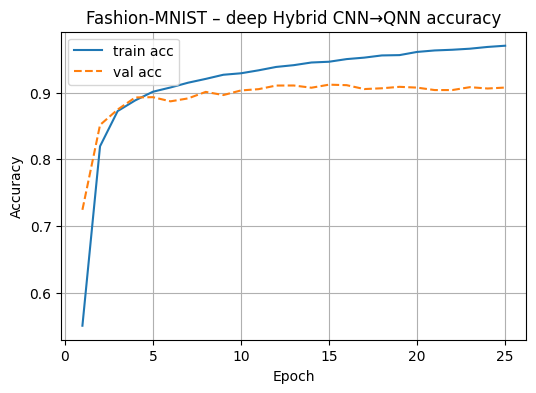

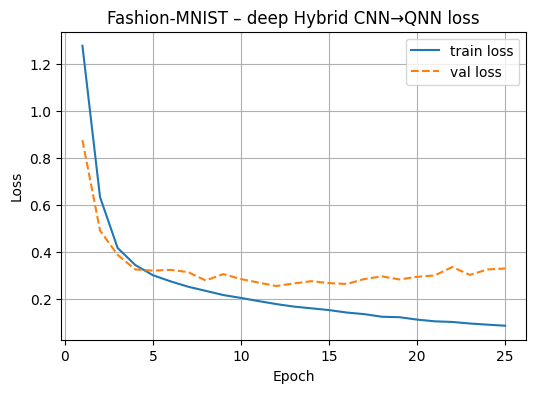

In [118]:
# Cell F3: Fashion-MNIST training curves

import matplotlib.pyplot as plt

epochs = range(1, len(hist_fashion["train_acc"]) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, hist_fashion["train_acc"], label="train acc")
plt.plot(epochs, hist_fashion["val_acc"],   label="val acc", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Fashion-MNIST – deep Hybrid CNN→QNN accuracy")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs, hist_fashion["train_loss"], label="train loss")
plt.plot(epochs, hist_fashion["val_loss"],   label="val loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Fashion-MNIST – deep Hybrid CNN→QNN loss")
plt.grid(True)
plt.legend()
plt.show()


In [121]:
# Cell F4: Evaluate Fashion-MNIST Hybrid model on test set

test_acc_fashion, test_preds_fashion, test_labels_fashion = evaluate_on_test(
    fashion_model_10_deep,
    loaders_fashion["test"],
)
print(f"Fashion-MNIST Test Accuracy: {test_acc_fashion:.4f}")



Test accuracy: 0.9027
Fashion-MNIST Test Accuracy: 0.9027


In [122]:
# Build test images tensor for visualization (slow but ok once)
test_images_fashion = torch.cat([x for x, _ in loaders_fashion["test"]]).cpu().numpy()


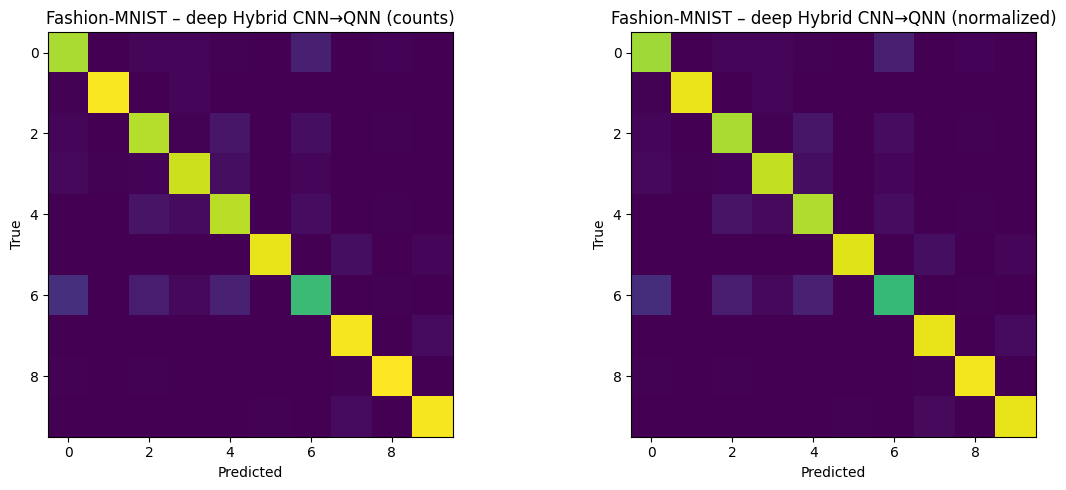

Fashion-MNIST Hybrid QNN misclassified misclassified samples: 20


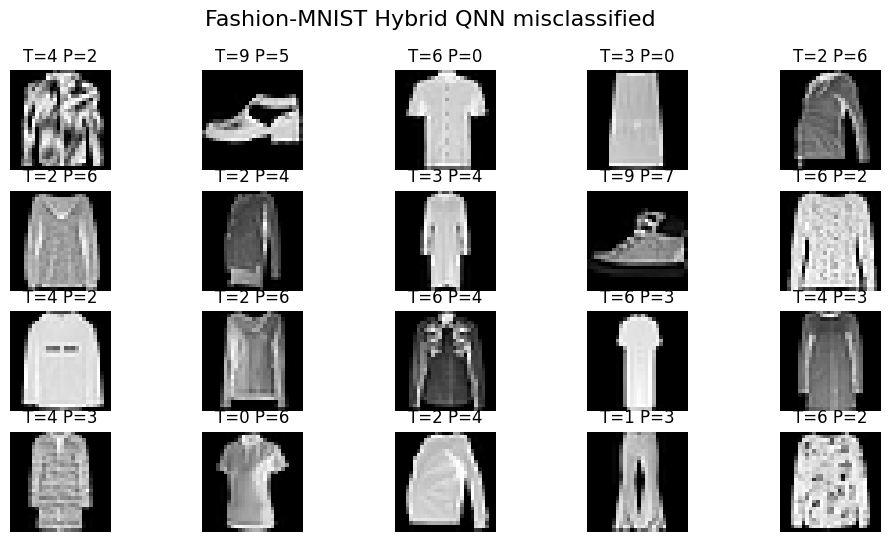

In [123]:
# Cell F5: Confusion matrix & misclassified Fashion-MNIST examples

plot_cm(
    test_labels_fashion,
    test_preds_fashion,
    title="Fashion-MNIST – deep Hybrid CNN→QNN"
)

show_misclassified(
    test_images_fashion,
    test_preds_fashion,
    test_labels_fashion,
    title="Fashion-MNIST Hybrid QNN misclassified",
    max_samples=20,   # tweak if you want more/less
)


| Label | Class Name          |
| ----- | ------------------- |
| **0** | **T-shirt / top**   |
| **1** | **Trouser** (pants) |
| **2** | **Pullover**        |
| **3** | **Dress**           |
| **4** | **Coat**            |
| **5** | **Sandal**          |
| **6** | **Shirt**           |
| **7** | **Sneaker**         |
| **8** | **Bag**             |
| **9** | **Ankle boot**      |


In [124]:
fashion_classes = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}


# Level 4
EMNIST Letters (28×28 grayscale, 26 lowercase letters

In [125]:
# Cell L1: EMNIST Letters dataset & transform

from torchvision import transforms
from torchvision.datasets import EMNIST

# EMNIST image orientation is different; we fix it with a small transform
emnist_transform = transforms.Compose([
    transforms.ToTensor(),
    # rotate/flip to match normal MNIST orientation
    transforms.Lambda(lambda x: x.transpose(1, 2).flip(1)),
])

emnist_trainval = EMNIST(
    root="./data",
    split="letters",      # 26 letters
    train=True,
    download=True,
    transform=emnist_transform,
)

emnist_test = EMNIST(
    root="./data",
    split="letters",
    train=False,
    download=True,
    transform=emnist_transform,
)

print("EMNIST Letters train+val size:", len(emnist_trainval))
print("EMNIST Letters test size:", len(emnist_test))
print("Label range in EMNIST (letters) is 1..26; we will remap to 0..25 in loaders.")


100%|████████████████████████████████████████| 562M/562M [03:35<00:00, 2.61MB/s]


EMNIST Letters train+val size: 124800
EMNIST Letters test size: 20800
Label range in EMNIST (letters) is 1..26; we will remap to 0..25 in loaders.


In [126]:
# Cell L2: wrap EMNIST so labels go from 0..25 instead of 1..26
from torch.utils.data import Dataset, DataLoader, random_split

class EMNISTLettersMapped(Dataset):
    def __init__(self, base_dataset):
        self.base = base_dataset

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, label = self.base[idx]
        # EMNIST letters labels are 1..26, remap to 0..25
        return img, label - 1

# Wrap the big train+val set
emnist_trainval_mapped = EMNISTLettersMapped(emnist_trainval)
emnist_test_mapped     = EMNISTLettersMapped(emnist_test)

# Train/val split (e.g. 90% / 10%)
train_size = int(0.9 * len(emnist_trainval_mapped))
val_size   = len(emnist_trainval_mapped) - train_size
emnist_train, emnist_val = random_split(
    emnist_trainval_mapped,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(0)
)

print("EMNIST train size:", len(emnist_train))
print("EMNIST val size  :", len(emnist_val))
print("EMNIST test size :", len(emnist_test_mapped))


EMNIST train size: 112320
EMNIST val size  : 12480
EMNIST test size : 20800


In [127]:
# Cell L3: EMNIST DataLoaders
BATCH_SIZE_EMNIST = 64  # you can try 128 if RAM is fine

train_loader_emnist = DataLoader(
    emnist_train, batch_size=BATCH_SIZE_EMNIST,
    shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)

val_loader_emnist = DataLoader(
    emnist_val, batch_size=BATCH_SIZE_EMNIST,
    shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
)

test_loader_emnist = DataLoader(
    emnist_test_mapped, batch_size=BATCH_SIZE_EMNIST,
    shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
)

loaders_emnist = {
    "train": train_loader_emnist,
    "val":   val_loader_emnist,
    "test":  test_loader_emnist,
}

print("EMNIST loaders ready.")
for k, v in loaders_emnist.items():
    print(k, "batches:", len(v))


EMNIST loaders ready.
train batches: 1755
val batches: 195
test batches: 325


In [128]:
# Cell H1-letters: Deep 8-qubit, 6-layer VQC + hybrid CNN->QNN model for EMNIST letters

import pennylane as qml
import torch
import torch.nn as nn

N_QUBITS_DEEP = 8
N_LAYERS_DEEP = 6

dev_deep = qml.device(
    "lightning.qubit",
    wires=N_QUBITS_DEEP,
    shots=None,
)

@qml.qnode(dev_deep, interface="torch")
def vqc_8_vector_deep(inputs, weights):
    n_inputs = inputs.shape[0]

    # data encoding
    for i in range(N_QUBITS_DEEP):
        qml.RY(inputs[i], wires=i)

    # variational layers
    for l in range(N_LAYERS_DEEP):
        for i in range(N_QUBITS_DEEP):
            qml.RY(weights[l, i], wires=i)
        for i in range(N_QUBITS_DEEP - 1):
            qml.CNOT(wires=[i, i + 1])

    return tuple(qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS_DEEP))


class HybridCNN_QNN_26_Deep(nn.Module):      # <--- new name, 26 classes
    """CNN28 encoder -> deep 8-qubit VQC (6 layers) -> 26-class logits (EMNIST letters)"""

    def __init__(self, n_classes: int = 26): # <--- default 26
        super().__init__()
        self.encoder = CNN28_Encoder()       # same encoder as before
        self.q_weights = nn.Parameter(
            0.01 * torch.randn(N_LAYERS_DEEP, N_QUBITS_DEEP)
        )
        self.fc_out = nn.Linear(N_QUBITS_DEEP, n_classes)

    def forward(self, x):
        feats = self.encoder(x)              # [B, 8] if encoder outputs 8 features

        outs = []
        for i in range(feats.shape[0]):
            out_vec = vqc_8_vector_deep(feats[i], self.q_weights)
            out_vec = torch.stack(out_vec)   # [8]
            outs.append(out_vec)

        q_out = torch.stack(outs)           # [B, 8]
        logits = self.fc_out(q_out)         # [B, 26]
        return logits


print("HybridCNN_QNN_26_Deep model ready.")
print("   ", N_QUBITS_DEEP, "qubits,", N_LAYERS_DEEP, "layers, 26 classes.")


HybridCNN_QNN_26_Deep model ready.
    8 qubits, 6 layers, 26 classes.


In [133]:
# EMNIST training hyperparameters
EPOCHS_EMNIST = 20      # you can bump this higher later for very long runs
LR_EMNIST     = 1e-3    # same LR we used for other datasets
print("EMNIST hyperparams:", EPOCHS_EMNIST, LR_EMNIST)


EMNIST hyperparams: 20 0.001


In [134]:
emnist_model_deep = HybridCNN_QNN_26_Deep().to(torch_device)

emnist_model_deep, hist_emnist = train_multiclass_qnn(
    emnist_model_deep,
    loaders_emnist["train"],
    loaders_emnist["val"],
    epochs=EPOCHS_EMNIST,
    lr=LR_EMNIST,
)


[QNN Train Epoch 1]:   0%|                             | 0/1755 [00:00<?, ?it/s]/home/ana/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
[QNN Train Epoch 1]: 100%|██████████████████| 1755/1755 [16:33<00:00,  1.77it/s]


[Epoch 1] train_loss=1.7619 train_acc=0.5301 | val_loss=1.0290 val_acc=0.7447


[QNN Train Epoch 2]: 100%|██████████████████| 1755/1755 [17:15<00:00,  1.70it/s]


[Epoch 2] train_loss=0.8036 train_acc=0.7978 | val_loss=0.6707 val_acc=0.8256


[QNN Train Epoch 3]: 100%|██████████████████| 1755/1755 [17:17<00:00,  1.69it/s]


[Epoch 3] train_loss=0.5416 train_acc=0.8627 | val_loss=0.4939 val_acc=0.8736


[QNN Train Epoch 4]: 100%|██████████████████| 1755/1755 [16:45<00:00,  1.75it/s]


[Epoch 4] train_loss=0.4268 train_acc=0.8866 | val_loss=0.4298 val_acc=0.8875


[QNN Train Epoch 5]: 100%|██████████████████| 1755/1755 [17:09<00:00,  1.70it/s]


[Epoch 5] train_loss=0.3658 train_acc=0.9006 | val_loss=0.3910 val_acc=0.8942


[QNN Train Epoch 6]: 100%|██████████████████| 1755/1755 [17:15<00:00,  1.70it/s]


[Epoch 6] train_loss=0.3267 train_acc=0.9091 | val_loss=0.3695 val_acc=0.9012


[QNN Train Epoch 7]: 100%|██████████████████| 1755/1755 [16:44<00:00,  1.75it/s]


[Epoch 7] train_loss=0.2998 train_acc=0.9156 | val_loss=0.3351 val_acc=0.9103


[QNN Train Epoch 8]: 100%|██████████████████| 1755/1755 [16:47<00:00,  1.74it/s]


[Epoch 8] train_loss=0.2766 train_acc=0.9214 | val_loss=0.3121 val_acc=0.9148


[QNN Train Epoch 9]: 100%|██████████████████| 1755/1755 [16:52<00:00,  1.73it/s]


[Epoch 9] train_loss=0.2595 train_acc=0.9254 | val_loss=0.3241 val_acc=0.9115


[QNN Train Epoch 10]: 100%|█████████████████| 1755/1755 [16:45<00:00,  1.74it/s]


[Epoch 10] train_loss=0.2440 train_acc=0.9286 | val_loss=0.3101 val_acc=0.9149


[QNN Train Epoch 11]: 100%|█████████████████| 1755/1755 [16:22<00:00,  1.79it/s]


[Epoch 11] train_loss=0.2330 train_acc=0.9317 | val_loss=0.2987 val_acc=0.9175


[QNN Train Epoch 12]: 100%|█████████████████| 1755/1755 [16:05<00:00,  1.82it/s]


[Epoch 12] train_loss=0.2210 train_acc=0.9344 | val_loss=0.3004 val_acc=0.9171


[QNN Train Epoch 13]: 100%|█████████████████| 1755/1755 [16:16<00:00,  1.80it/s]


[Epoch 13] train_loss=0.2099 train_acc=0.9374 | val_loss=0.3020 val_acc=0.9191


[QNN Train Epoch 14]: 100%|█████████████████| 1755/1755 [16:08<00:00,  1.81it/s]


[Epoch 14] train_loss=0.2023 train_acc=0.9395 | val_loss=0.2863 val_acc=0.9188


[QNN Train Epoch 15]: 100%|█████████████████| 1755/1755 [16:27<00:00,  1.78it/s]


[Epoch 15] train_loss=0.1924 train_acc=0.9416 | val_loss=0.2867 val_acc=0.9219


[QNN Train Epoch 16]: 100%|█████████████████| 1755/1755 [16:23<00:00,  1.78it/s]


[Epoch 16] train_loss=0.1862 train_acc=0.9425 | val_loss=0.2888 val_acc=0.9218


[QNN Train Epoch 17]: 100%|█████████████████| 1755/1755 [16:01<00:00,  1.83it/s]


[Epoch 17] train_loss=0.1798 train_acc=0.9442 | val_loss=0.2965 val_acc=0.9196


[QNN Train Epoch 18]: 100%|█████████████████| 1755/1755 [16:13<00:00,  1.80it/s]


[Epoch 18] train_loss=0.1753 train_acc=0.9455 | val_loss=0.2913 val_acc=0.9200


[QNN Train Epoch 19]: 100%|█████████████████| 1755/1755 [16:21<00:00,  1.79it/s]


[Epoch 19] train_loss=0.1691 train_acc=0.9468 | val_loss=0.2801 val_acc=0.9252


[QNN Train Epoch 20]: 100%|█████████████████| 1755/1755 [16:25<00:00,  1.78it/s]


[Epoch 20] train_loss=0.1640 train_acc=0.9486 | val_loss=0.2901 val_acc=0.9239


In [140]:
def evaluate_on_test_with_images(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_images = []

    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            preds = logits.argmax(dim=1)

            total_correct += (preds == y).sum().item()
            total_samples += y.size(0)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())
            all_images.append(x.cpu())

    acc = total_correct / total_samples
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    all_images = torch.cat(all_images).numpy()

    return acc, all_preds, all_labels, all_images


In [142]:
test_acc_emnist, test_preds_emnist, test_labels_emnist, test_images_emnist = evaluate_on_test_with_images(
    emnist_model_deep,
    loaders_emnist["test"],
    device,
)

print(f"EMNIST Letters Test Accuracy: {test_acc_emnist:.4f}")


EMNIST Letters Test Accuracy: 0.9212


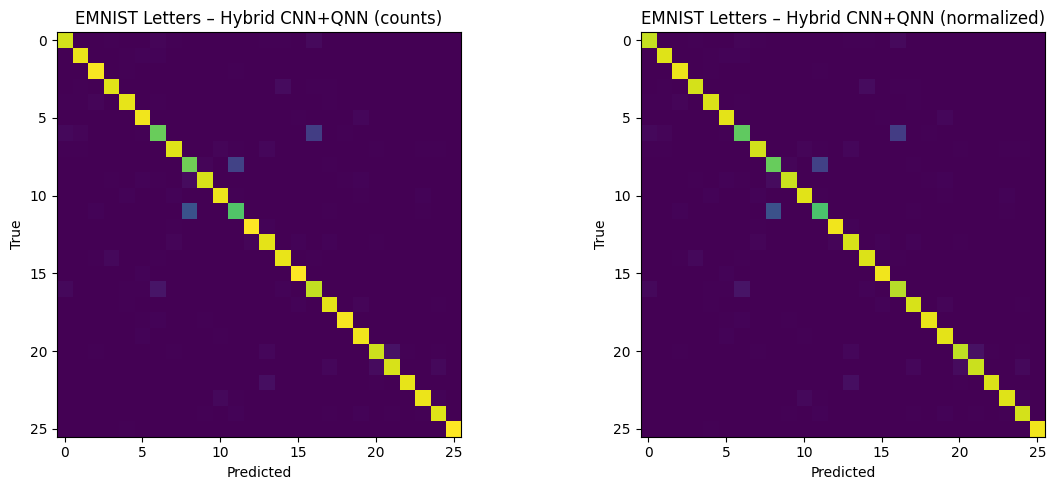

In [143]:
plot_cm(
    test_labels_emnist,
    test_preds_emnist,
    title="EMNIST Letters – Hybrid CNN+QNN"
)


EMNIST Letters Hybrid QNN misclassified misclassified samples: 20


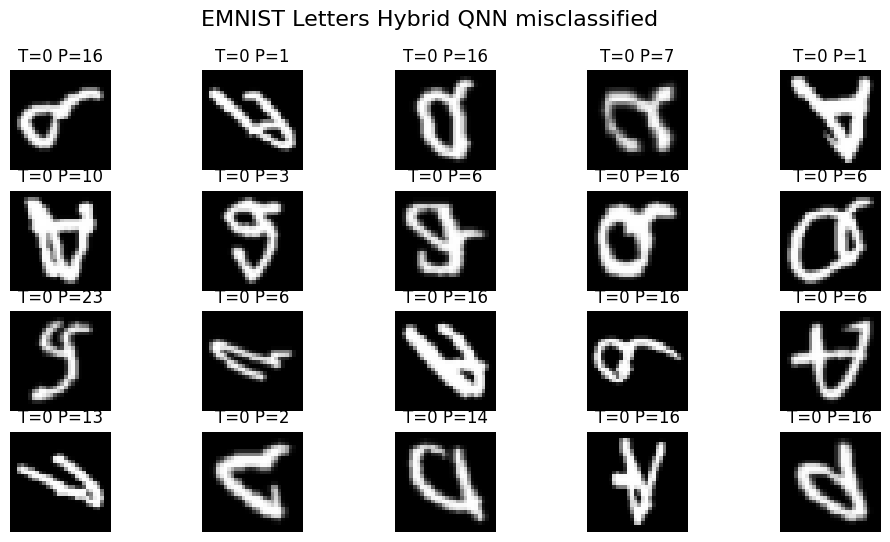

In [144]:
show_misclassified(
    test_images_emnist,
    test_preds_emnist,
    test_labels_emnist,
    title="EMNIST Letters Hybrid QNN misclassified",
    max_samples=20,
)


| Class Index | Letter |
| ----------- | ------ |
| **0**       | **a**  |
| **1**       | **b**  |
| **2**       | **c**  |
| **3**       | **d**  |
| **4**       | **e**  |
| **5**       | **f**  |
| **6**       | **g**  |
| **7**       | **h**  |
| **8**       | **i**  |
| **9**       | **j**  |
| **10**      | **k**  |
| **11**      | **l**  |
| **12**      | **m**  |
| **13**      | **n**  |
| **14**      | **o**  |
| **15**      | **p**  |
| **16**      | **q**  |
| **17**      | **r**  |
| **18**      | **s**  |
| **19**      | **t**  |
| **20**      | **u**  |
| **21**      | **v**  |
| **22**      | **w**  |
| **23**      | **x**  |
| **24**      | **y**  |
| **25**      | **z**  |


In [146]:
# Cell T1: EMNIST Letters "word test" platform

import torch
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Letter ↔ index maps (for 26 EMNIST letters) ---

emnist_letter_to_idx = {chr(ord('a') + i): i for i in range(26)}
emnist_idx_to_letter = {i: chr(ord('a') + i) for i in range(26)}

print("EMNIST letter mapping ready (a–z ↔ 0–25).")


# --- 2. Build / cache example images per letter from the EMNIST test set ---

def build_emnist_letter_cache(test_loader, max_per_class=50):
    """
    Go through the EMNIST test loader once and collect up to `max_per_class`
    example images for each class 0..25. Results are cached in a dict.
    """
    images_by_class = {i: [] for i in range(26)}

    print("Building EMNIST letter image cache from test set...")
    for x_batch, y_batch in test_loader:
        # x_batch: [B, 1, 28, 28], y_batch: [B]
        for img, label in zip(x_batch, y_batch):
            c = int(label.item())
            if c in images_by_class and len(images_by_class[c]) < max_per_class:
                images_by_class[c].append(img.clone())

        # stop early if we already have enough for every class
        if all(len(v) >= max_per_class for v in images_by_class.values()):
            break

    # Convert lists to tensors for easier stacking later
    for k in images_by_class:
        if len(images_by_class[k]) > 0:
            images_by_class[k] = torch.stack(images_by_class[k], dim=0)
        else:
            images_by_class[k] = None  # in case some class is missing

    print("Cache built.")
    return images_by_class


# Global cache (will be filled on first use)
emnist_letter_cache = None


# --- 3. Word test function ---

def emnist_word_test(word, model, test_loader, device, max_per_class=50):
    """
    Given a lowercase word (letters a–z), pick real EMNIST test images
    for each character, run them through the model, and show predictions.
    """

    global emnist_letter_cache

    # normalize word: keep only a–z
    clean_word = "".join([c for c in word.lower() if c in emnist_letter_to_idx])
    if len(clean_word) == 0:
        raise ValueError("Word must contain at least one letter a–z.")

    # build cache on first call
    if emnist_letter_cache is None:
        emnist_letter_cache = build_emnist_letter_cache(test_loader, max_per_class=max_per_class)

    # build batch of images for this word
    imgs = []
    target_indices = []
    for c in clean_word:
        idx = emnist_letter_to_idx[c]
        cache_tensor = emnist_letter_cache[idx]
        if cache_tensor is None:
            raise RuntimeError(f"No cached images for letter '{c}' (class {idx}).")

        # random example for variety
        rand_idx = np.random.randint(cache_tensor.shape[0])
        img = cache_tensor[rand_idx]
        imgs.append(img)
        target_indices.append(idx)

    x_batch = torch.stack(imgs, dim=0)              # [L, 1, 28, 28]
    y_true = torch.tensor(target_indices, dtype=torch.long)

    # run through model
    model.eval()
    with torch.no_grad():
        x_dev = x_batch.to(device)
        logits = model(x_dev)
        preds = logits.argmax(dim=1).cpu()

    # decode letters
    true_letters = [emnist_idx_to_letter[int(t)] for t in y_true]
    pred_letters = [emnist_idx_to_letter[int(p)] for p in preds]

    correct = (y_true == preds)
    frac_correct_positions = correct.float().mean().item()

    print(f"\nEMNIST Hybrid QNN – word test for '{clean_word}'")
    print("Target indices :", [int(t) for t in y_true])
    print("Pred indices   :", [int(p) for p in preds])
    print("Target letters :", "".join(true_letters))
    print("Pred letters   :", "".join(pred_letters))
    print("Per-char correct:", [bool(c.item()) for c in correct])
    print(f"Fraction of correct positions: {frac_correct_positions:.3f}")

    # plot images with T: / P: labels
    L = len(clean_word)
    fig, axes = plt.subplots(1, L, figsize=(2 * L, 2.5))
    if L == 1:
        axes = [axes]
    for i, ax in enumerate(axes):
        ax.imshow(x_batch[i].squeeze(), cmap="gray")
        ax.axis("off")
        ax.set_title(f"T:{true_letters[i]}  P:{pred_letters[i]}", fontsize=10)
    plt.suptitle(f"EMNIST Hybrid QNN – word '{clean_word}'", fontsize=14)
    plt.tight_layout()
    plt.show()

    return {
        "word": clean_word,
        "true_letters": true_letters,
        "pred_letters": pred_letters,
        "correct_mask": correct,
        "fraction_correct": frac_correct_positions,
    }


print("\nEMNIST word test platform ready. Call, for example:")
print("  emnist_word_test('quantum', emnist_model_deep, loaders_emnist['test'], device)")


EMNIST letter mapping ready (a–z ↔ 0–25).

EMNIST word test platform ready. Call, for example:
  emnist_word_test('quantum', emnist_model_deep, loaders_emnist['test'], device)



EMNIST Hybrid QNN – word test for 'quantum'
Target indices : [16, 20, 0, 13, 19, 20, 12]
Pred indices   : [16, 21, 0, 13, 19, 20, 12]
Target letters : quantum
Pred letters   : qvantum
Per-char correct: [True, False, True, True, True, True, True]
Fraction of correct positions: 0.857


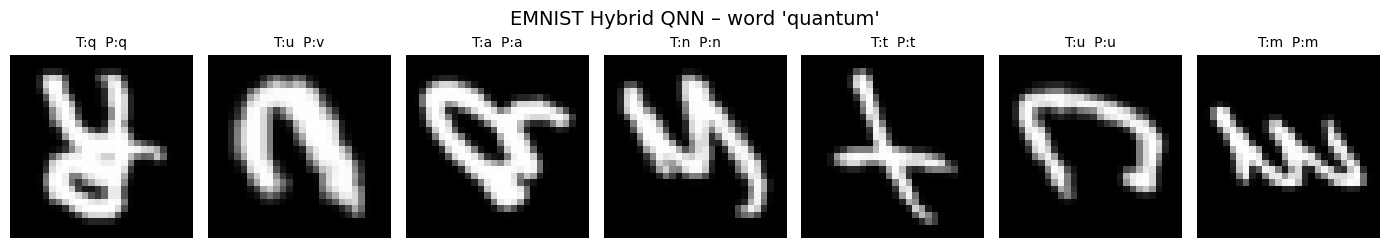


EMNIST Hybrid QNN – word test for 'hybrid'
Target indices : [7, 24, 1, 17, 8, 3]
Pred indices   : [7, 20, 1, 17, 8, 3]
Target letters : hybrid
Pred letters   : hubrid
Per-char correct: [True, False, True, True, True, True]
Fraction of correct positions: 0.833


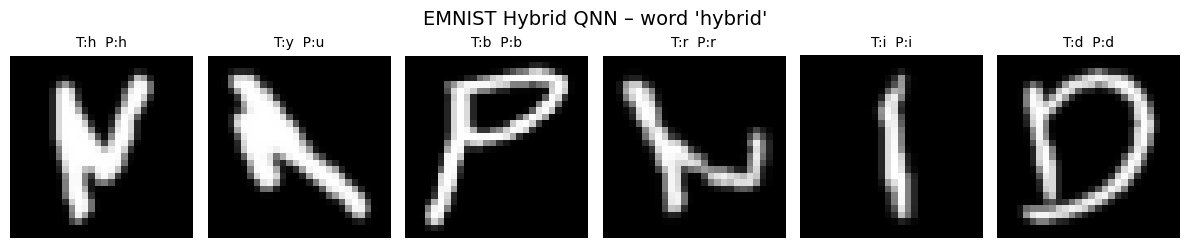


EMNIST Hybrid QNN – word test for 'neural'
Target indices : [13, 4, 20, 17, 0, 11]
Pred indices   : [13, 4, 14, 17, 0, 11]
Target letters : neural
Pred letters   : neoral
Per-char correct: [True, True, False, True, True, True]
Fraction of correct positions: 0.833


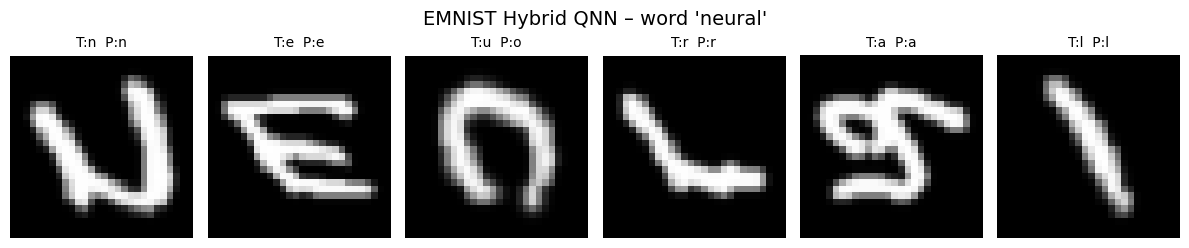


EMNIST Hybrid QNN – word test for 'quantumai'
Target indices : [16, 20, 0, 13, 19, 20, 12, 0, 8]
Pred indices   : [16, 20, 0, 13, 19, 20, 12, 0, 8]
Target letters : quantumai
Pred letters   : quantumai
Per-char correct: [True, True, True, True, True, True, True, True, True]
Fraction of correct positions: 1.000


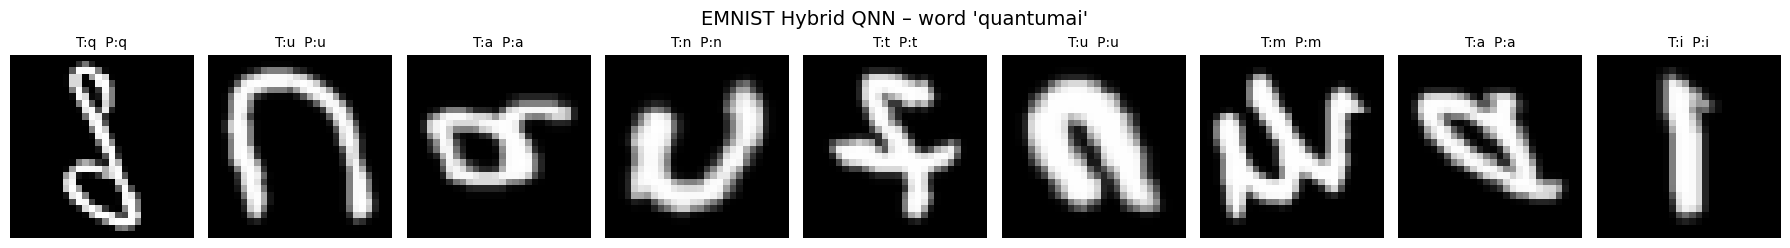

{'word': 'quantumai',
 'true_letters': ['q', 'u', 'a', 'n', 't', 'u', 'm', 'a', 'i'],
 'pred_letters': ['q', 'u', 'a', 'n', 't', 'u', 'm', 'a', 'i'],
 'correct_mask': tensor([True, True, True, True, True, True, True, True, True]),
 'fraction_correct': 1.0}

In [150]:
emnist_word_test("quantum", emnist_model_deep, loaders_emnist["test"], device)
emnist_word_test("hybrid",  emnist_model_deep, loaders_emnist["test"], device)
emnist_word_test("neural",  emnist_model_deep, loaders_emnist["test"], device)
emnist_word_test("quantumai", emnist_model_deep, loaders_emnist["test"], device)


In [2]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import pennylane as qml


In [3]:
# path from your notebook
root_path = "/home/ana/Downloads/data/archive(2)/raw-img"

class AnimalDataset(Dataset):
    def __init__(self, root_path, transform=None):
        self.root_path = root_path
        self.transform = transform
        self.samples = []

        # each folder = class
        self.class_names = sorted(
            d for d in os.listdir(root_path)
            if os.path.isdir(os.path.join(root_path, d))
        )

        for cls_idx, cls in enumerate(self.class_names):
            folder = os.path.join(root_path, cls)
            for fname in os.listdir(folder):
                if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                    self.samples.append(
                        (os.path.join(folder, fname), cls_idx)
                    )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((144, 144)),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.05,
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

dataset = AnimalDataset(root_path, transform=transform)

# train/val split instead of using same data twice
from torch.utils.data import random_split, DataLoader

val_ratio = 0.2
n_total = len(dataset)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val

train_ds, val_ds = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=0)

loaders_animals = {"train": train_loader, "val": val_loader}

animal_classes = dataset.class_names
print("Classes:", animal_classes, " (n =", len(animal_classes), ")")
print("Train samples:", len(train_ds), " Val samples:", len(val_ds))


Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']  (n = 10 )
Train samples: 20944  Val samples: 5235


In [6]:
# quantum hyperparameters
N_QUBITS_ANIMALS = 4      # <= you can try 5 or 6 if you want heavier
N_LAYERS_ANIMALS = 3      # <= you can try 4 or 5


dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="torch", diff_method="backprop")
def animal_qnode(inputs, weights):
    """inputs: 1D torch tensor of len 4, weights: [N_LAYERS, 4, 3]"""
    qml.AngleEmbedding(inputs, wires=range(N_QUBITS), rotation="Y")
    qml.StronglyEntanglingLayers(weights, wires=range(N_QUBITS))
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]


# TorchLayer wraps the QNode and manages trainable weights as torch Parameters
weight_shapes = {"weights": (N_LAYERS, N_QUBITS, 3)}
q_layer = qnn.TorchLayer(animal_qnode, weight_shapes)


NameError: name 'qnn' is not defined

In [7]:
class AnimalsCNNEncoder(nn.Module):
    """
    CNN for 3×128×128 images.
    After 2× MaxPool2d(2): 128 -> 64 -> 32
    Final feature map: [B, 32, 32, 32] => 32 * 32 * 32 = 32768 features.
    """
    def __init__(self, out_features: int, input_size: int = 128):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)

        # 128 -> 64 -> 32
        feat_size = input_size // (2 ** 2)   # 128 // 4 = 32
        self.flat_size = 32 * feat_size * feat_size  # 32 * 32 * 32 = 32768

        self.fc = nn.Linear(self.flat_size, out_features)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # [B, 16, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))   # [B, 32, 32, 32]
        x = x.view(x.size(0), -1)              # [B, 32768]
        x = self.fc(x)                         # [B, out_features]
        return x


class HybridAnimalQNN(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()
        self.encoder = AnimalsCNNEncoder(out_features=N_QUBITS, input_size=128)
        self.q_layer = q_layer                 # TorchLayer (QNode)
        self.fc_out  = nn.Linear(N_QUBITS, n_classes)

    def forward(self, x):
        feats = self.encoder(x)                # [B, 4]
        q_out = self.q_layer(feats)           # [B, 4] (TorchLayer handles batches)
        logits = self.fc_out(q_out)           # [B, n_classes]
        return logits


In [8]:
import time
import torch
import torch.nn as nn
from tqdm.auto import tqdm  # if missing: pip install tqdm

def train_animals_qnn(model, loaders, epochs, lr, device):
    model.to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss": [], "train_acc": [],
               "val_loss": [],   "val_acc": []}

    for ep in range(1, epochs + 1):
        ep_start = time.time()

        # --------- TRAIN ---------
        model.train()
        train_loss_sum = 0.0
        train_correct = 0
        train_total = 0

        train_loop = tqdm(
            loaders["train"],
            desc=f"Epoch [{ep}/{epochs}] (train)",
            leave=False
        )

        for x, y in train_loop:
            x, y = x.to(device), y.to(device)

            opt.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            opt.step()

            # stats
            batch_size = x.size(0)
            train_loss_sum += loss.item() * batch_size
            preds = logits.argmax(1)
            train_correct += (preds == y).sum().item()
            train_total += batch_size

            batch_acc = (preds == y).float().mean().item()
            train_loop.set_postfix(loss=f"{loss.item():.4f}",
                                   batch_acc=f"{batch_acc:.3f}")

        train_loss = train_loss_sum / train_total
        train_acc  = train_correct / train_total

        # --------- VALIDATION ---------
        model.eval()
        val_loss_sum = 0.0
        val_correct = 0
        val_total = 0

        val_loop = tqdm(
            loaders["val"],
            desc=f"Epoch [{ep}/{epochs}] (val)",
            leave=False
        )

        with torch.no_grad():
            for x, y in val_loop:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = criterion(logits, y)

                batch_size = x.size(0)
                val_loss_sum += loss.item() * batch_size
                preds = logits.argmax(1)
                val_correct += (preds == y).sum().item()
                val_total += batch_size

        val_loss = val_loss_sum / val_total
        val_acc  = val_correct / val_total

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        ep_time = time.time() - ep_start
        print(
            f"Epoch [{ep}/{epochs}] | "
            f"train_loss: {train_loss:.4f}  train_acc: {train_acc:.3f} | "
            f"val_loss: {val_loss:.4f}  val_acc: {val_acc:.3f} | "
            f"time: {ep_time:.1f}s"
        )

    return model, history


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

EPOCHS = 20          # was 3
LR = 1e-3            # a bit smaller than 2e-3

n_classes = len(animal_classes)

model_animal_qnn = HybridAnimalQNN(n_classes=n_classes).to(device)

model_animal_qnn, history_animals = train_animals_qnn(
    model_animal_qnn,
    loaders_animals,
    epochs=EPOCHS,
    lr=LR,
    device=device,
)


Using device: cpu


Epoch [1/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [1/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [1/20] | train_loss: 2.2338  train_acc: 0.181 | val_loss: 2.2178  val_acc: 0.185 | time: 103.1s


Epoch [2/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [2/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [2/20] | train_loss: 2.2084  train_acc: 0.187 | val_loss: 2.2158  val_acc: 0.181 | time: 113.8s


Epoch [3/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [3/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [3/20] | train_loss: 2.2068  train_acc: 0.188 | val_loss: 2.2140  val_acc: 0.182 | time: 117.8s


Epoch [4/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [4/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [4/20] | train_loss: 2.2064  train_acc: 0.183 | val_loss: 2.2138  val_acc: 0.178 | time: 120.1s


Epoch [5/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [5/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [5/20] | train_loss: 2.2064  train_acc: 0.184 | val_loss: 2.2137  val_acc: 0.188 | time: 121.2s


Epoch [6/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [6/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [6/20] | train_loss: 2.2063  train_acc: 0.182 | val_loss: 2.2141  val_acc: 0.177 | time: 123.6s


Epoch [7/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [7/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [7/20] | train_loss: 2.2062  train_acc: 0.186 | val_loss: 2.2142  val_acc: 0.178 | time: 140.4s


Epoch [8/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [8/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [8/20] | train_loss: 2.2061  train_acc: 0.184 | val_loss: 2.2141  val_acc: 0.185 | time: 136.0s


Epoch [9/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [9/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [9/20] | train_loss: 2.2063  train_acc: 0.182 | val_loss: 2.2138  val_acc: 0.183 | time: 123.3s


Epoch [10/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [10/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [10/20] | train_loss: 2.2062  train_acc: 0.183 | val_loss: 2.2139  val_acc: 0.182 | time: 126.3s


Epoch [11/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [11/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [11/20] | train_loss: 2.2062  train_acc: 0.189 | val_loss: 2.2139  val_acc: 0.187 | time: 126.7s


Epoch [12/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [12/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [12/20] | train_loss: 2.2062  train_acc: 0.184 | val_loss: 2.2138  val_acc: 0.181 | time: 127.3s


Epoch [13/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [13/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [13/20] | train_loss: 2.2062  train_acc: 0.185 | val_loss: 2.2140  val_acc: 0.181 | time: 123.1s


Epoch [14/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [14/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [14/20] | train_loss: 2.2061  train_acc: 0.186 | val_loss: 2.2142  val_acc: 0.178 | time: 115.6s


Epoch [15/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [15/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [15/20] | train_loss: 2.2062  train_acc: 0.183 | val_loss: 2.2139  val_acc: 0.182 | time: 117.7s


Epoch [16/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class AnimalCNNBaseline(nn.Module):
    """
    Stronger but still lightweight CNN for 3x128x128 images.
    Uses 4 conv blocks + batch norm + global average pooling
    (no manual flatten size math, fewer parameters than the huge FC).
    """
    def __init__(self, n_classes: int):
        super().__init__()

        # conv block 1: 3 -> 32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        # conv block 2: 32 -> 64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        # conv block 3: 64 -> 128
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)

        # conv block 4: 128 -> 256
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # after 4 pools: 128 -> 64 -> 32 -> 16 -> 8
        # feature map is [B, 256, 8, 8]
        # we use global average pooling -> [B, 256]
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        # [B, 3, 128, 128]
        x = self.pool(F.relu(self.bn1(self.conv1(x))))    # [B, 32, 64, 64]
        x = self.pool(F.relu(self.bn2(self.conv2(x))))    # [B, 64, 32, 32]
        x = self.pool(F.relu(self.bn3(self.conv3(x))))    # [B, 128, 16, 16]
        x = self.pool(F.relu(self.bn4(self.conv4(x))))    # [B, 256, 8, 8]

        # global average pooling
        x = x.mean(dim=(2, 3))                            # [B, 256]

        x = self.dropout(F.relu(self.fc1(x)))             # [B, 128]
        x = self.fc2(x)                                   # [B, n_classes]
        return x


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

EPOCHS = 15
LR = 1e-3

n_classes = len(animal_classes)

baseline_cnn = AnimalCNNBaseline(n_classes=n_classes).to(device)

baseline_cnn, hist_cnn = train_animals_qnn(
    baseline_cnn,
    loaders_animals,
    epochs=EPOCHS,
    lr=LR,
    device=device,
)


Using device: cpu


Epoch [1/15] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [1/15] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [1/15] | train_loss: 1.8902  train_acc: 0.336 | val_loss: 1.6250  val_acc: 0.426 | time: 350.9s


Epoch [2/15] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [2/15] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [2/15] | train_loss: 1.5615  train_acc: 0.461 | val_loss: 1.4068  val_acc: 0.521 | time: 389.2s


Epoch [3/15] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [3/15] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [3/15] | train_loss: 1.4205  train_acc: 0.516 | val_loss: 1.3101  val_acc: 0.557 | time: 392.4s


Epoch [4/15] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [4/15] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c2b96f51800>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c2b96f51800>  File "/home/ana/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__

Traceback (most recent call last):
    self._shutdown_workers()
  File "/home/ana/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      File "/home/ana/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    self._shutdown_workers()if w.is_alive():

  File "/home/ana/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive():
        ^ ^^ ^^^^^^^^^^^^^^^^^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process' 
  
   F

Epoch [4/15] | train_loss: 1.3152  train_acc: 0.551 | val_loss: 1.2664  val_acc: 0.572 | time: 401.8s


Epoch [5/15] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [5/15] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [5/15] | train_loss: 1.2443  train_acc: 0.576 | val_loss: 1.1733  val_acc: 0.612 | time: 394.8s


Epoch [6/15] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [6/15] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [6/15] | train_loss: 1.2005  train_acc: 0.595 | val_loss: 1.1223  val_acc: 0.621 | time: 390.5s


Epoch [7/15] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [7/15] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [7/15] | train_loss: 1.1467  train_acc: 0.611 | val_loss: 1.1119  val_acc: 0.631 | time: 391.7s


Epoch [8/15] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [8/15] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [8/15] | train_loss: 1.1169  train_acc: 0.620 | val_loss: 1.0977  val_acc: 0.624 | time: 705.0s


Epoch [9/15] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [9/15] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [9/15] | train_loss: 1.0918  train_acc: 0.631 | val_loss: 1.1117  val_acc: 0.628 | time: 900.2s


Epoch [10/15] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [10/15] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c2b96f51800>
Traceback (most recent call last):
  File "/home/ana/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/ana/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^Exception ignored in: ^^^^^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7c2b96f51800>^
^Traceback (most recent call last):
  File "/home/ana/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^

  File "/home/ana/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Asser

Epoch [10/15] | train_loss: 1.0654  train_acc: 0.640 | val_loss: 1.0435  val_acc: 0.651 | time: 899.4s


Epoch [11/15] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [11/15] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [11/15] | train_loss: 1.0362  train_acc: 0.653 | val_loss: 1.0478  val_acc: 0.651 | time: 885.7s


Epoch [12/15] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [12/15] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [12/15] | train_loss: 1.0237  train_acc: 0.656 | val_loss: 1.0288  val_acc: 0.655 | time: 892.2s


Epoch [13/15] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [13/15] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [13/15] | train_loss: 1.0018  train_acc: 0.662 | val_loss: 0.9837  val_acc: 0.678 | time: 882.7s


Epoch [14/15] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [14/15] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [14/15] | train_loss: 0.9894  train_acc: 0.668 | val_loss: 1.0141  val_acc: 0.662 | time: 878.3s


Epoch [15/15] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [15/15] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [15/15] | train_loss: 0.9664  train_acc: 0.674 | val_loss: 1.0433  val_acc: 0.663 | time: 892.2s


In [46]:
from torch.utils.data import Subset

# Take a tiny subset of the TRAIN set (e.g., 200 samples)
tiny_indices = list(range(min(200, len(loaders_animals["train"].dataset))))
tiny_train_ds = Subset(loaders_animals["train"].dataset, tiny_indices)
tiny_train_loader = DataLoader(tiny_train_ds, batch_size=16, shuffle=True, num_workers=0)

tiny_loaders = {"train": tiny_train_loader, "val": tiny_train_loader}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

n_classes = len(animal_classes)

tiny_model = AnimalCNNBaseline(n_classes=n_classes).to(device)

tiny_model, tiny_hist = train_animals_qnn(
    tiny_model,
    tiny_loaders,
    epochs=20,
    lr=1e-3,
    device=device,
)


Using device: cpu


Epoch [1/20] (train):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [1/20] (val):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [1/20] | train_loss: 2.3883  train_acc: 0.130 | val_loss: 2.2060  val_acc: 0.185 | time: 19.1s


Epoch [2/20] (train):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2/20] (val):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2/20] | train_loss: 2.2247  train_acc: 0.170 | val_loss: 2.1725  val_acc: 0.200 | time: 19.0s


Epoch [3/20] (train):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3/20] (val):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3/20] | train_loss: 2.1923  train_acc: 0.190 | val_loss: 2.1365  val_acc: 0.230 | time: 18.8s


Epoch [4/20] (train):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [4/20] (val):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [4/20] | train_loss: 2.1363  train_acc: 0.235 | val_loss: 2.0724  val_acc: 0.235 | time: 18.7s


Epoch [5/20] (train):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [5/20] (val):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [5/20] | train_loss: 2.1531  train_acc: 0.210 | val_loss: 2.0604  val_acc: 0.240 | time: 20.8s


Epoch [6/20] (train):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [6/20] (val):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [6/20] | train_loss: 2.0651  train_acc: 0.250 | val_loss: 1.9531  val_acc: 0.325 | time: 19.9s


Epoch [7/20] (train):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [7/20] (val):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [7/20] | train_loss: 2.0070  train_acc: 0.265 | val_loss: 1.9097  val_acc: 0.340 | time: 18.2s


Epoch [8/20] (train):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [8/20] (val):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [8/20] | train_loss: 1.9445  train_acc: 0.305 | val_loss: 1.7797  val_acc: 0.420 | time: 18.4s


Epoch [9/20] (train):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [9/20] (val):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [9/20] | train_loss: 1.8531  train_acc: 0.345 | val_loss: 1.6894  val_acc: 0.395 | time: 18.7s


Epoch [10/20] (train):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [10/20] (val):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [10/20] | train_loss: 1.8105  train_acc: 0.345 | val_loss: 1.5927  val_acc: 0.450 | time: 18.6s


Epoch [11/20] (train):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [11/20] (val):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [11/20] | train_loss: 1.6955  train_acc: 0.415 | val_loss: 1.5141  val_acc: 0.465 | time: 20.2s


Epoch [12/20] (train):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [12/20] (val):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [12/20] | train_loss: 1.6535  train_acc: 0.380 | val_loss: 1.3651  val_acc: 0.525 | time: 20.2s


Epoch [13/20] (train):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [13/20] (val):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [13/20] | train_loss: 1.5759  train_acc: 0.450 | val_loss: 1.3158  val_acc: 0.605 | time: 18.8s


Epoch [14/20] (train):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [14/20] (val):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [14/20] | train_loss: 1.4270  train_acc: 0.490 | val_loss: 1.1930  val_acc: 0.665 | time: 19.2s


Epoch [15/20] (train):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [15/20] (val):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [15/20] | train_loss: 1.3353  train_acc: 0.530 | val_loss: 1.0416  val_acc: 0.660 | time: 17.0s


Epoch [16/20] (train):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [16/20] (val):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [16/20] | train_loss: 1.3166  train_acc: 0.500 | val_loss: 1.0013  val_acc: 0.690 | time: 18.9s


Epoch [17/20] (train):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [17/20] (val):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [17/20] | train_loss: 1.2643  train_acc: 0.550 | val_loss: 1.0413  val_acc: 0.710 | time: 20.6s


Epoch [18/20] (train):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [18/20] (val):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [18/20] | train_loss: 1.1897  train_acc: 0.620 | val_loss: 0.9306  val_acc: 0.665 | time: 19.9s


Epoch [19/20] (train):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [19/20] (val):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [19/20] | train_loss: 1.1090  train_acc: 0.580 | val_loss: 0.8292  val_acc: 0.755 | time: 18.4s


Epoch [20/20] (train):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [20/20] (val):   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [20/20] | train_loss: 0.9523  train_acc: 0.705 | val_loss: 0.7328  val_acc: 0.750 | time: 20.1s


In [10]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

class AnimalResNetBaseline(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()

        # load pretrained ResNet18
        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # remove the last fully connected layer
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])  # 512-d

        # new classifier head
        self.fc1 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.feature_extractor(x)          # [B,512,1,1]
        x = x.view(x.size(0), -1)              # [B,512]
        x = F.relu(self.fc1(x))                # [B,256]
        x = self.dropout(x)
        x = self.fc2(x)                        # [B,n_classes]
        return x


In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

EPOCHS = 10      # with ResNet, 10 epochs is enough
LR = 1e-4        # smaller LR for finetuning

n_classes = len(animal_classes)

resnet_model = AnimalResNetBaseline(n_classes=n_classes).to(device)

resnet_model, hist_resnet = train_animals_qnn(
    resnet_model,
    loaders_animals,
    epochs=EPOCHS,
    lr=LR,
    device=device,
)


Using device: cpu
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ana/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|███████████████████████████████████████| 44.7M/44.7M [01:14<00:00, 625kB/s]


Epoch [1/10] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [1/10] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [1/10] | train_loss: 0.6038  train_acc: 0.810 | val_loss: 0.3241  val_acc: 0.895 | time: 2034.1s


Epoch [2/10] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [2/10] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [2/10] | train_loss: 0.3624  train_acc: 0.887 | val_loss: 0.2803  val_acc: 0.910 | time: 1958.4s


Epoch [3/10] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

EPOCHS = 20         # give it some time; still far cheaper than ResNet
LR = 1e-3

n_classes = len(animal_classes)

strong_cnn = AnimalCNNBaseline(n_classes=n_classes).to(device)

strong_cnn, strong_hist = train_animals_qnn(
    strong_cnn,
    loaders_animals,
    epochs=EPOCHS,
    lr=LR,
    device=device,
)


Using device: cpu


Epoch [1/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [1/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [1/20] | train_loss: 2.0341  train_acc: 0.279 | val_loss: 1.8904  val_acc: 0.355 | time: 1410.6s


Epoch [2/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [2/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [2/20] | train_loss: 1.7669  train_acc: 0.386 | val_loss: 1.5983  val_acc: 0.440 | time: 1380.0s


Epoch [3/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [3/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [3/20] | train_loss: 1.6161  train_acc: 0.433 | val_loss: 1.4804  val_acc: 0.490 | time: 1432.2s


Epoch [4/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [4/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [4/20] | train_loss: 1.5174  train_acc: 0.469 | val_loss: 1.3850  val_acc: 0.511 | time: 1395.1s


Epoch [5/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [5/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [5/20] | train_loss: 1.4302  train_acc: 0.499 | val_loss: 1.2513  val_acc: 0.576 | time: 1411.6s


Epoch [6/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [6/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [6/20] | train_loss: 1.3684  train_acc: 0.523 | val_loss: 1.3831  val_acc: 0.521 | time: 1382.0s


Epoch [7/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [7/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [7/20] | train_loss: 1.3149  train_acc: 0.544 | val_loss: 1.1922  val_acc: 0.586 | time: 1390.8s


Epoch [8/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [8/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [8/20] | train_loss: 1.2659  train_acc: 0.564 | val_loss: 1.1005  val_acc: 0.614 | time: 1379.3s


Epoch [9/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [9/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [9/20] | train_loss: 1.2246  train_acc: 0.581 | val_loss: 1.0860  val_acc: 0.628 | time: 1353.7s


Epoch [10/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [10/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [10/20] | train_loss: 1.1904  train_acc: 0.596 | val_loss: 1.1759  val_acc: 0.586 | time: 1341.1s


Epoch [11/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [11/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [11/20] | train_loss: 1.1509  train_acc: 0.607 | val_loss: 1.0339  val_acc: 0.644 | time: 1368.0s


Epoch [12/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [12/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [12/20] | train_loss: 1.1071  train_acc: 0.626 | val_loss: 0.9924  val_acc: 0.656 | time: 412.2s


Epoch [13/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [13/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [13/20] | train_loss: 1.0752  train_acc: 0.638 | val_loss: 0.9789  val_acc: 0.659 | time: 422.2s


Epoch [14/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [14/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [14/20] | train_loss: 1.0462  train_acc: 0.647 | val_loss: 1.0156  val_acc: 0.657 | time: 534.6s


Epoch [15/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [15/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [15/20] | train_loss: 1.0145  train_acc: 0.659 | val_loss: 0.9548  val_acc: 0.676 | time: 506.2s


Epoch [16/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [16/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [16/20] | train_loss: 0.9913  train_acc: 0.663 | val_loss: 0.9848  val_acc: 0.674 | time: 507.7s


Epoch [17/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [17/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [17/20] | train_loss: 0.9588  train_acc: 0.675 | val_loss: 0.8554  val_acc: 0.709 | time: 433.0s


Epoch [18/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [18/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [18/20] | train_loss: 0.9418  train_acc: 0.689 | val_loss: 1.0651  val_acc: 0.642 | time: 470.1s


Epoch [19/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [19/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [19/20] | train_loss: 0.9250  train_acc: 0.692 | val_loss: 0.8996  val_acc: 0.695 | time: 489.1s


Epoch [20/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [20/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [20/20] | train_loss: 0.8883  train_acc: 0.704 | val_loss: 0.7906  val_acc: 0.735 | time: 519.8s


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AnimalCNN_Strong(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),        # 128 -> 64

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),        # 64 -> 32

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),        # 32 -> 16  => [B, 128, 16, 16]
        )

        # 128 * 16 * 16 = 32768  (this was wrong before)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, n_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)   # [B, 32768]
        x = self.classifier(x)
        return x


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

EPOCHS = 20
LR = 1e-3

n_classes = len(animal_classes)

strong_cnn = AnimalCNN_Strong(n_classes).to(device)

optimizer = torch.optim.AdamW(strong_cnn.parameters(), lr=LR, weight_decay=1e-4)

strong_cnn, strong_hist = train_animals_qnn(
    strong_cnn,
    loaders_animals,
    epochs=EPOCHS,
    lr=LR,
    device=device
)


Using: cpu


Epoch [1/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [1/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [1/20] | train_loss: 2.3799  train_acc: 0.200 | val_loss: 2.1770  val_acc: 0.234 | time: 867.8s


Epoch [2/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [2/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [2/20] | train_loss: 2.1904  train_acc: 0.208 | val_loss: 2.1661  val_acc: 0.225 | time: 844.6s


Epoch [3/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [3/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [3/20] | train_loss: 2.1879  train_acc: 0.208 | val_loss: 2.1583  val_acc: 0.222 | time: 846.3s


Epoch [4/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [4/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [4/20] | train_loss: 2.1856  train_acc: 0.210 | val_loss: 2.1509  val_acc: 0.226 | time: 850.6s


Epoch [5/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [5/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [5/20] | train_loss: 2.1804  train_acc: 0.216 | val_loss: 2.1637  val_acc: 0.225 | time: 846.4s


Epoch [6/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [6/20] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [6/20] | train_loss: 2.1772  train_acc: 0.222 | val_loss: 2.1462  val_acc: 0.235 | time: 848.1s


Epoch [7/20] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

class AnimalResNetBaseline(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()

        # Load pretrained ResNet18
        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Remove the last fully-connected classification layer (fc)
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])  # -> [B, 512, 1, 1]

        # New classifier head (this part is "yours")
        self.fc1 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, n_classes)

    def forward(self, x):
        # ResNet feature extractor
        x = self.feature_extractor(x)          # [B, 512, 1, 1]
        x = x.view(x.size(0), -1)              # [B, 512]

        # Custom head
        x = F.relu(self.fc1(x))                # [B, 256]
        x = self.dropout(x)
        x = self.fc2(x)                        # [B, n_classes]
        return x


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

EPOCHS = 10      # ResNet usually does very well in 5–10 epochs
LR = 1e-4        # small LR for fine-tuning pretrained weights

n_classes = len(animal_classes)

resnet_model = AnimalResNetBaseline(n_classes=n_classes).to(device)

resnet_model, hist_resnet = train_animals_qnn(
    resnet_model,
    loaders_animals,
    epochs=EPOCHS,
    lr=LR,
    device=device,
)


Using device: cpu


Epoch [1/10] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [1/10] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [1/10] | train_loss: 0.6097  train_acc: 0.807 | val_loss: 0.3323  val_acc: 0.891 | time: 528.0s


Epoch [2/10] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [2/10] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [2/10] | train_loss: 0.3534  train_acc: 0.887 | val_loss: 0.2955  val_acc: 0.905 | time: 524.6s


Epoch [3/10] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [3/10] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [3/10] | train_loss: 0.2991  train_acc: 0.904 | val_loss: 0.2661  val_acc: 0.915 | time: 513.5s


Epoch [4/10] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [4/10] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [4/10] | train_loss: 0.2601  train_acc: 0.917 | val_loss: 0.2670  val_acc: 0.917 | time: 515.6s


Epoch [5/10] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [5/10] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [5/10] | train_loss: 0.2200  train_acc: 0.930 | val_loss: 0.2871  val_acc: 0.907 | time: 518.7s


Epoch [6/10] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [6/10] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [6/10] | train_loss: 0.2018  train_acc: 0.934 | val_loss: 0.2830  val_acc: 0.915 | time: 510.9s


Epoch [7/10] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [7/10] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [7/10] | train_loss: 0.1794  train_acc: 0.942 | val_loss: 0.2781  val_acc: 0.912 | time: 508.9s


Epoch [8/10] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [8/10] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [8/10] | train_loss: 0.1670  train_acc: 0.946 | val_loss: 0.2750  val_acc: 0.916 | time: 515.2s


Epoch [9/10] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [9/10] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [9/10] | train_loss: 0.1538  train_acc: 0.950 | val_loss: 0.2855  val_acc: 0.916 | time: 514.0s


Epoch [10/10] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [10/10] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [10/10] | train_loss: 0.1409  train_acc: 0.955 | val_loss: 0.2909  val_acc: 0.918 | time: 511.8s


In [42]:
import torch
import torch.nn as nn
from torchvision import models

import pennylane as qml
from pennylane import qnn

# QNN configuration
N_QUBITS = 6
N_LAYERS = 4

dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="torch", diff_method="backprop")
def qnode(inputs, weights):
    """
    inputs: tensor of shape [N_QUBITS]
    weights: tensor of shape [N_LAYERS, N_QUBITS, 3]
    """
    # Scale inputs into [-pi, pi] using torch ops only
    angles = torch.tanh(inputs) * torch.pi

    qml.AngleEmbedding(angles, wires=range(N_QUBITS), rotation="Y")
    qml.StronglyEntanglingLayers(weights, wires=range(N_QUBITS))

    # Return list of expectation values; TorchLayer converts to torch.Tensor
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

# Shapes for the variational weights (matches qnode signature)
weight_shapes = {"weights": (N_LAYERS, N_QUBITS, 3)}

# Wrap QNode as a PyTorch module (handles batch, gradients, etc.)
q_layer = qnn.TorchLayer(qnode, weight_shapes)


In [43]:
class HybridResNetQNN(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()

        # 1) Pretrained ResNet18 backbone as feature extractor
        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.features = nn.Sequential(
            *list(backbone.children())[:-1]   # output: [B, 512, 1, 1]
        )

        # (optional) freeze backbone for stability / speed
        for p in self.features.parameters():
            p.requires_grad = False

        # 2) Linear projection 512 -> 6 (QNN inputs)
        self.to_qnn = nn.Linear(512, N_QUBITS)

        # 3) Quantum layer (TorchLayer from Cell 1)
        self.q_layer = q_layer   # outputs [B, 6]

        # 4) Final classifier 6 -> n_classes
        self.classifier = nn.Linear(N_QUBITS, n_classes)

    def forward(self, x):
        # ResNet features
        x = self.features(x)          # [B, 512, 1, 1]
        x = x.view(x.size(0), -1)     # [B, 512]

        # to QNN
        x = self.to_qnn(x)            # [B, 6]

        # QNN output (TorchLayer handles batch + gradients)
        x = self.q_layer(x)           # [B, 6]

        # class logits
        x = self.classifier(x)        # [B, n_classes]
        return x


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

EPOCHS = 8      # start with 8; you can increase later
LR = 5e-4       # slightly higher LR for the small head

n_classes = len(animal_classes)

hybrid_model = HybridResNetQNN(n_classes=n_classes).to(device)

hybrid_model, hist_hybrid = train_animals_qnn(
    hybrid_model,
    loaders_animals,
    epochs=EPOCHS,
    lr=LR,
    device=device,
)


Using: cpu


Epoch [1/8] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [1/8] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [1/8] | train_loss: 2.0531  train_acc: 0.318 | val_loss: 1.7964  val_acc: 0.405 | time: 306.3s


Epoch [2/8] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [2/8] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [2/8] | train_loss: 1.7017  train_acc: 0.400 | val_loss: 1.6036  val_acc: 0.407 | time: 259.3s


Epoch [3/8] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [3/8] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [3/8] | train_loss: 1.5232  train_acc: 0.439 | val_loss: 1.3610  val_acc: 0.534 | time: 262.3s


Epoch [4/8] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [4/8] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [4/8] | train_loss: 1.3704  train_acc: 0.523 | val_loss: 1.2526  val_acc: 0.580 | time: 286.4s


Epoch [5/8] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [5/8] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [5/8] | train_loss: 1.2962  train_acc: 0.560 | val_loss: 1.2122  val_acc: 0.583 | time: 271.8s


Epoch [6/8] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [6/8] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [6/8] | train_loss: 1.2557  train_acc: 0.567 | val_loss: 1.1314  val_acc: 0.611 | time: 261.1s


Epoch [7/8] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [7/8] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [7/8] | train_loss: 1.2353  train_acc: 0.570 | val_loss: 1.1121  val_acc: 0.608 | time: 257.0s


Epoch [8/8] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [8/8] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [8/8] | train_loss: 1.2010  train_acc: 0.580 | val_loss: 1.1185  val_acc: 0.612 | time: 256.5s


In [45]:
import torch
import torch.nn as nn
from torchvision import models

import pennylane as qml
from pennylane import qnn

# QNN configuration – 8 qubits now
N_QUBITS = 8
N_LAYERS = 3   # keep layers a bit smaller for speed

dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="torch", diff_method="backprop")
def qnode(inputs, weights):
    """
    inputs: tensor of shape [N_QUBITS]
    weights: tensor of shape [N_LAYERS, N_QUBITS, 3]
    """
    # Scale inputs into [-pi, pi] using torch ops only
    angles = torch.tanh(inputs) * torch.pi

    qml.AngleEmbedding(angles, wires=range(N_QUBITS), rotation="Y")
    qml.StronglyEntanglingLayers(weights, wires=range(N_QUBITS))

    # Return list of expectation values; TorchLayer converts to torch.Tensor
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

# Shapes for the variational weights (matches qnode signature)
weight_shapes = {"weights": (N_LAYERS, N_QUBITS, 3)}

# Wrap QNode as a PyTorch module (handles batch + gradients etc.)
q_layer = qnn.TorchLayer(qnode, weight_shapes)


In [46]:
class HybridResNetQNN(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()

        # 1) Pretrained ResNet18 backbone as feature extractor
        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.features = nn.Sequential(
            *list(backbone.children())[:-1]   # output: [B, 512, 1, 1]
        )

        # (optional) freeze backbone for stability / speed
        for p in self.features.parameters():
            p.requires_grad = False

        # 2) Linear projection 512 -> 8 (QNN inputs)
        self.to_qnn = nn.Linear(512, N_QUBITS)   # N_QUBITS = 8

        # 3) Quantum layer (TorchLayer from cell above)
        self.q_layer = q_layer                   # outputs [B, 8]

        # 4) Final classifier 8 -> n_classes
        self.classifier = nn.Linear(N_QUBITS, n_classes)

    def forward(self, x):
        # ResNet features
        x = self.features(x)          # [B, 512, 1, 1]
        x = x.view(x.size(0), -1)     # [B, 512]

        # to QNN
        x = self.to_qnn(x)            # [B, 8]

        # QNN output (TorchLayer handles batch + gradients)
        x = self.q_layer(x)           # [B, 8]

        # class logits
        x = self.classifier(x)        # [B, n_classes]
        return x


In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

EPOCHS = 8
LR = 5e-4

n_classes = len(animal_classes)

hybrid_model = HybridResNetQNN(n_classes=n_classes).to(device)

hybrid_model, hist_hybrid = train_animals_qnn(
    hybrid_model,
    loaders_animals,
    epochs=EPOCHS,
    lr=LR,
    device=device,
)


Using: cpu


Epoch [1/8] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [1/8] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [1/8] | train_loss: 2.0940  train_acc: 0.243 | val_loss: 1.7534  val_acc: 0.372 | time: 264.0s


Epoch [2/8] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [2/8] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [2/8] | train_loss: 1.6736  train_acc: 0.411 | val_loss: 1.5740  val_acc: 0.447 | time: 262.2s


Epoch [3/8] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [3/8] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [3/8] | train_loss: 1.4966  train_acc: 0.479 | val_loss: 1.3819  val_acc: 0.528 | time: 263.9s


Epoch [4/8] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [4/8] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [4/8] | train_loss: 1.3899  train_acc: 0.524 | val_loss: 1.2782  val_acc: 0.556 | time: 263.3s


Epoch [5/8] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [5/8] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [5/8] | train_loss: 1.3369  train_acc: 0.536 | val_loss: 1.3901  val_acc: 0.522 | time: 262.5s


Epoch [6/8] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [6/8] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [6/8] | train_loss: 1.3005  train_acc: 0.547 | val_loss: 1.1465  val_acc: 0.601 | time: 265.3s


Epoch [7/8] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [7/8] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [7/8] | train_loss: 1.2576  train_acc: 0.561 | val_loss: 1.1413  val_acc: 0.602 | time: 265.6s


Epoch [8/8] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [8/8] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [8/8] | train_loss: 1.2349  train_acc: 0.569 | val_loss: 1.1402  val_acc: 0.581 | time: 263.4s


In [48]:
class HybridDualHeadResNetQNN(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()

        # 1) Pretrained ResNet18 backbone
        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.features = nn.Sequential(
            *list(backbone.children())[:-1]   # [B, 512, 1, 1]
        )

        # (optional) freeze most of ResNet
        for p in self.features.parameters():
            p.requires_grad = False

        # 2) Classical branch: 512 -> 256
        self.class_fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
        )

        # 3) Quantum branch: 512 -> N_QUBITS (8)
        self.to_qnn = nn.Linear(512, N_QUBITS)  # N_QUBITS from your QNN cell
        self.q_layer = q_layer                 # 8-qubit TorchLayer

        # 4) Final classifier: (256 classical + 8 quantum) -> n_classes
        self.classifier = nn.Linear(256 + N_QUBITS, n_classes)

    def forward(self, x):
        # ResNet features
        x = self.features(x)          # [B, 512, 1, 1]
        x = x.view(x.size(0), -1)     # [B, 512]

        # Classical branch
        c = self.class_fc(x)          # [B, 256]

        # Quantum branch
        q_in = self.to_qnn(x)         # [B, 8]
        q = self.q_layer(q_in)        # [B, 8]

        # Concatenate classical + quantum features
        h = torch.cat([c, q], dim=1)  # [B, 256 + 8]

        # Final logits
        logits = self.classifier(h)   # [B, n_classes]
        return logits


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

EPOCHS = 30      # give it a bit more time
LR = 3e-4        # slightly lower LR for bigger head

n_classes = len(animal_classes)

hybrid_dual = HybridDualHeadResNetQNN(n_classes=n_classes).to(device)

hybrid_dual, hist_dual = train_animals_qnn(
    hybrid_dual,
    loaders_animals,
    epochs=EPOCHS,
    lr=LR,
    device=device,
)


Using: cpu


Epoch [1/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [1/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [1/30] | train_loss: 0.9320  train_acc: 0.697 | val_loss: 0.6121  val_acc: 0.799 | time: 267.0s


Epoch [2/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [2/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [2/30] | train_loss: 0.7109  train_acc: 0.764 | val_loss: 0.5422  val_acc: 0.820 | time: 265.4s


Epoch [3/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [3/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [3/30] | train_loss: 0.6779  train_acc: 0.774 | val_loss: 0.5623  val_acc: 0.808 | time: 270.8s


Epoch [4/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [4/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [4/30] | train_loss: 0.6619  train_acc: 0.778 | val_loss: 0.5348  val_acc: 0.820 | time: 273.6s


Epoch [5/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [5/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [5/30] | train_loss: 0.6379  train_acc: 0.787 | val_loss: 0.5343  val_acc: 0.820 | time: 269.8s


Epoch [6/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [6/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [6/30] | train_loss: 0.6323  train_acc: 0.786 | val_loss: 0.5318  val_acc: 0.821 | time: 269.4s


Epoch [7/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [7/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [7/30] | train_loss: 0.6141  train_acc: 0.796 | val_loss: 0.5084  val_acc: 0.828 | time: 270.9s


Epoch [8/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [8/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [8/30] | train_loss: 0.6227  train_acc: 0.792 | val_loss: 0.5051  val_acc: 0.832 | time: 268.2s


Epoch [9/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [9/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [9/30] | train_loss: 0.6088  train_acc: 0.796 | val_loss: 0.4974  val_acc: 0.832 | time: 267.5s


Epoch [10/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [10/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [10/30] | train_loss: 0.5981  train_acc: 0.800 | val_loss: 0.5143  val_acc: 0.831 | time: 267.1s


Epoch [11/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [11/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [11/30] | train_loss: 0.5989  train_acc: 0.800 | val_loss: 0.5072  val_acc: 0.835 | time: 266.0s


Epoch [12/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [12/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [12/30] | train_loss: 0.5885  train_acc: 0.802 | val_loss: 0.4975  val_acc: 0.833 | time: 269.1s


Epoch [13/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [13/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [13/30] | train_loss: 0.5802  train_acc: 0.804 | val_loss: 0.5054  val_acc: 0.832 | time: 269.1s


Epoch [14/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [14/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [14/30] | train_loss: 0.5841  train_acc: 0.803 | val_loss: 0.4863  val_acc: 0.835 | time: 269.1s


Epoch [15/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [15/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [15/30] | train_loss: 0.5706  train_acc: 0.809 | val_loss: 0.4876  val_acc: 0.840 | time: 272.0s


Epoch [16/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [16/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [16/30] | train_loss: 0.5742  train_acc: 0.807 | val_loss: 0.4910  val_acc: 0.843 | time: 274.1s


Epoch [17/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [17/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [17/30] | train_loss: 0.5732  train_acc: 0.808 | val_loss: 0.4739  val_acc: 0.840 | time: 267.9s


Epoch [18/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [18/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [18/30] | train_loss: 0.5643  train_acc: 0.814 | val_loss: 0.4734  val_acc: 0.846 | time: 269.1s


Epoch [19/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [19/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [19/30] | train_loss: 0.5582  train_acc: 0.814 | val_loss: 0.4577  val_acc: 0.849 | time: 270.3s


Epoch [20/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [20/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [20/30] | train_loss: 0.5637  train_acc: 0.811 | val_loss: 0.4792  val_acc: 0.840 | time: 271.8s


Epoch [21/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [21/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [21/30] | train_loss: 0.5486  train_acc: 0.816 | val_loss: 0.4648  val_acc: 0.845 | time: 268.3s


Epoch [22/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [22/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [22/30] | train_loss: 0.5520  train_acc: 0.817 | val_loss: 0.4818  val_acc: 0.840 | time: 269.5s


Epoch [23/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [23/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [23/30] | train_loss: 0.5519  train_acc: 0.815 | val_loss: 0.4994  val_acc: 0.830 | time: 270.9s


Epoch [24/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [24/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [24/30] | train_loss: 0.5530  train_acc: 0.816 | val_loss: 0.4670  val_acc: 0.846 | time: 272.6s


Epoch [25/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [25/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [25/30] | train_loss: 0.5492  train_acc: 0.816 | val_loss: 0.4859  val_acc: 0.842 | time: 270.0s


Epoch [26/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [26/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [26/30] | train_loss: 0.5454  train_acc: 0.817 | val_loss: 0.4621  val_acc: 0.842 | time: 272.5s


Epoch [27/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [27/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [27/30] | train_loss: 0.5393  train_acc: 0.821 | val_loss: 0.4664  val_acc: 0.849 | time: 269.5s


Epoch [28/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [28/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [28/30] | train_loss: 0.5399  train_acc: 0.818 | val_loss: 0.4955  val_acc: 0.832 | time: 270.9s


Epoch [29/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [29/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [29/30] | train_loss: 0.5379  train_acc: 0.819 | val_loss: 0.4728  val_acc: 0.847 | time: 268.4s


Epoch [30/30] (train):   0%|          | 0/1309 [00:00<?, ?it/s]

Epoch [30/30] (val):   0%|          | 0/328 [00:00<?, ?it/s]

Epoch [30/30] | train_loss: 0.5343  train_acc: 0.820 | val_loss: 0.4454  val_acc: 0.854 | time: 270.7s


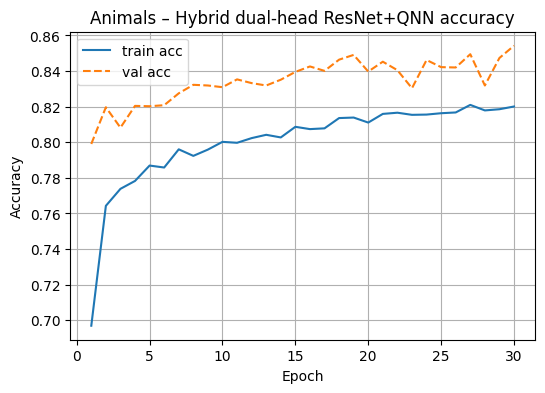

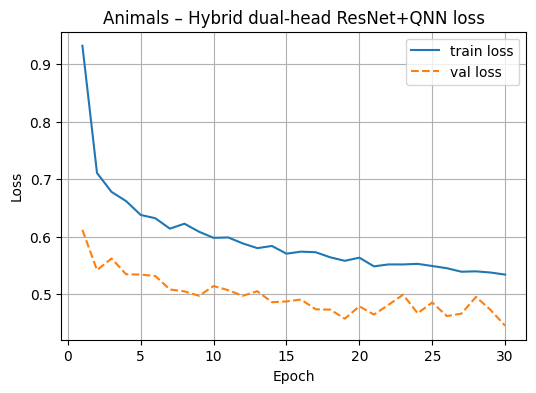

In [51]:
import matplotlib.pyplot as plt

# choose which history to plot (you can swap to hist_resnet, hist_classic, etc.)
history = hist_dual
title_prefix = "Animals – Hybrid dual-head ResNet+QNN"

epochs = range(1, len(history["train_acc"]) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, history["train_acc"], label="train acc")
plt.plot(epochs, history["val_acc"],   label="val acc", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"{title_prefix} accuracy")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs, history["train_loss"], label="train loss")
plt.plot(epochs, history["val_loss"],   label="val loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"{title_prefix} loss")
plt.grid(True)
plt.legend()
plt.show()


In [52]:
import torch

def evaluate_on_loader_with_images(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_images = []

    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            preds = logits.argmax(dim=1)

            total_correct += (preds == y).sum().item()
            total_samples += y.size(0)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())
            all_images.append(x.cpu())

    acc = total_correct / total_samples

    all_preds = torch.cat(all_preds).numpy()   # [N]
    all_labels = torch.cat(all_labels).numpy() # [N]
    all_images = torch.cat(all_images)         # [N, C, H, W] (torch tensor)

    return acc, all_preds, all_labels, all_images


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names=None, title_prefix=""):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # counts
    im0 = axes[0].imshow(cm, interpolation="nearest", cmap="viridis")
    axes[0].set_title(f"{title_prefix} (counts)")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")
    fig.colorbar(im0, ax=axes[0])
    if class_names is not None:
        axes[0].set_xticks(range(len(class_names)))
        axes[0].set_xticklabels(class_names, rotation=90, fontsize=6)
        axes[0].set_yticks(range(len(class_names)))
        axes[0].set_yticklabels(class_names, fontsize=6)

    # normalized
    im1 = axes[1].imshow(cm_norm, interpolation="nearest", cmap="viridis", vmin=0.0, vmax=1.0)
    axes[1].set_title(f"{title_prefix} (normalized)")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")
    fig.colorbar(im1, ax=axes[1])
    if class_names is not None:
        axes[1].set_xticks(range(len(class_names)))
        axes[1].set_xticklabels(class_names, rotation=90, fontsize=6)
        axes[1].set_yticks(range(len(class_names)))
        axes[1].set_yticklabels(class_names, fontsize=6)

    plt.tight_layout()
    plt.show()


In [56]:
def show_misclassified(images, y_true, y_pred, class_names=None, title="", max_samples=20):
    import numpy as np
    import matplotlib.pyplot as plt
    import torch

    # y_true, y_pred expected as numpy arrays
    mis_idx = np.where(y_true != y_pred)[0]
    if len(mis_idx) == 0:
        print("No misclassified samples.")
        return

    sel = mis_idx[:max_samples]
    n = len(sel)
    cols = min(8, n)          # fewer columns → bigger images
    rows = (n + cols - 1) // cols

    # bigger figures than before
    plt.figure(figsize=(2.5 * cols, 2.5 * rows))

    for i, idx in enumerate(sel):
        img = images[idx]     # torch tensor [C,H,W] or [H,W,C]

        if isinstance(img, torch.Tensor):
            img = img.clone()
            if img.dim() == 3 and img.size(0) in (1, 3):
                img = img.permute(1, 2, 0)  # [H,W,C]
            img = img.numpy()
            img = np.clip(img, 0, 1)       # assumes normalized to 0–1

        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.axis("off")

        t = int(y_true[idx])
        p = int(y_pred[idx])

        if class_names is not None:
            t_name = class_names[t]
            p_name = class_names[p]
            ax.set_title(f"T={t_name}\nP={p_name}", fontsize=9)
        else:
            ax.set_title(f"T={t} P={p}", fontsize=9)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


Hybrid dual-head ResNet+QNN validation accuracy: 0.8558


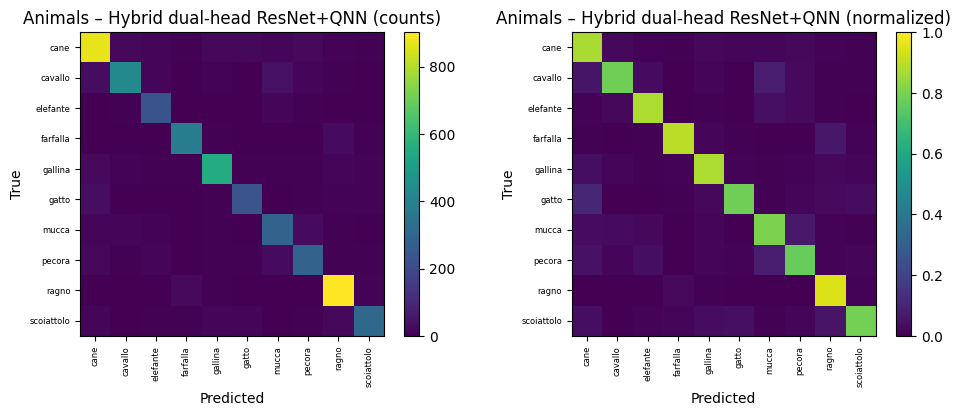

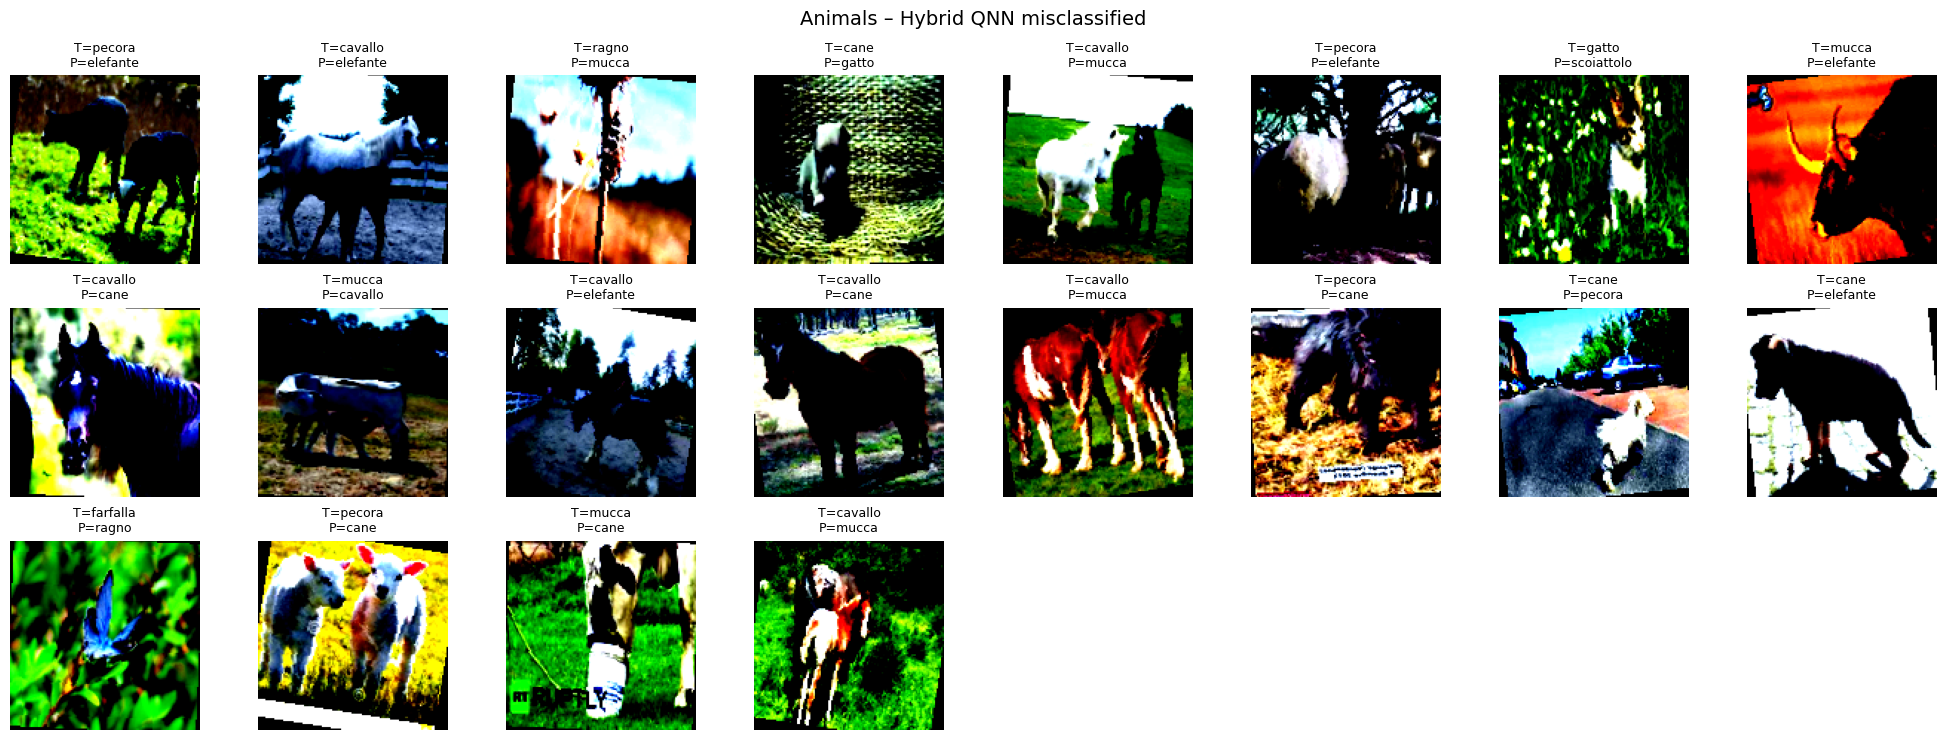

In [57]:
# evaluate
val_acc_hybrid, val_preds_hybrid, val_labels_hybrid, val_images_hybrid = (
    evaluate_on_loader_with_images(
        hybrid_dual,
        loaders_animals["val"],  # or "test" if you have it
        device,
    )
)

print(f"Hybrid dual-head ResNet+QNN validation accuracy: {val_acc_hybrid:.4f}")

# confusion matrix
plot_cm(
    val_labels_hybrid,
    val_preds_hybrid,
    class_names=animal_classes,   # list of class names you printed earlier
    title_prefix="Animals – Hybrid dual-head ResNet+QNN",
)

# misclassified examples
show_misclassified(
    val_images_hybrid,
    val_labels_hybrid,
    val_preds_hybrid,
    class_names=animal_classes,
    title="Animals – Hybrid QNN misclassified",
    max_samples=20,
)


| Label | Class name (dataset) | Meaning (English) |
| ----- | -------------------- | ----------------- |
| 0     | **cane**             | dog               |
| 1     | **cavallo**          | horse             |
| 2     | **elefante**         | elephant          |
| 3     | **farfalla**         | butterfly         |
| 4     | **gallina**          | hen / chicken     |
| 5     | **gatto**            | cat               |
| 6     | **mucca**            | cow               |
| 7     | **pecora**           | sheep             |
| 8     | **ragno**            | spider            |
| 9     | **scoiattolo**       | squirrel          |


In [17]:
import io
import torch
import torchvision.transforms as T
from PIL import Image
import ipywidgets as widgets
from IPython.display import display

# --- Preprocessing same as validation ---
preprocess = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

out = widgets.Output()
uploader = widgets.FileUpload(accept='image/*', multiple=False)
btn_classify = widgets.Button(description="Classify")

def classify_image(b):
    out.clear_output()
    if uploader.value is None or len(uploader.value) == 0:
        with out: print("Please upload an image.")
        return

    # uploader.value is a tuple → take first element
    uploaded_file = uploader.value[0]

    # Extract image bytes
    img_bytes = uploaded_file["content"]

    # Open as PIL
    img = Image.open(io.BytesIO(img_bytes)).convert("RGB")

    # Preprocess
    x = preprocess(img).unsqueeze(0).to(device)

    # Run model
    hybrid_dual.eval()
    with torch.no_grad():
        logits = hybrid_dual(x)
        probs = torch.softmax(logits, dim=1)[0]

    # Top-3 predictions
    topk = torch.topk(probs, 3)

    # Show results
    with out:
        display(img.resize((160,160)))
        print("\nTop predictions:")
        for i in range(3):
            idx = topk.indices[i].item()
            p = float(topk.values[i].item() * 100)
            cls_name = animal_classes[idx]
            print(f"{i+1}. {cls_name:12s}  ({p:4.1f}%)")

btn_classify.on_click(classify_image)

display(widgets.VBox([uploader, btn_classify, out]))


In [18]:
import io
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# ---------------------------------------------------------
# 1) Preprocessing (use your training transform if it exists)
# ---------------------------------------------------------
if "transform" in globals():
    preprocess = transform
else:
    preprocess = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
    ])

# ---------------------------------------------------------
# 2) Grad-CAM helper
#    (for your Hybrid dual-head ResNet+QNN model)
# ---------------------------------------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        def fwd_hook(module, inp, out):
            self.activations = out

        def bwd_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.fwd_handle = target_layer.register_forward_hook(fwd_hook)
        self.bwd_handle = target_layer.register_full_backward_hook(bwd_hook)

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        logits = self.model(x)

        if class_idx is None:
            class_idx = logits.argmax(dim=1).item()

        score = logits[:, class_idx]
        score.backward(retain_graph=True)

        acts = self.activations       # [B, C, H, W]
        grads = self.gradients        # [B, C, H, W]

        # Global average pool on gradients
        weights = grads.mean(dim=(2, 3), keepdim=True)    # [B,C,1,1]
        cam = (weights * acts).sum(dim=1, keepdim=True)   # [B,1,H,W]
        cam = F.relu(cam)

        # Normalize to 0–1
        cam_min, cam_max = cam.min(), cam.max()
        if cam_max > cam_min:
            cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)
        else:
            cam = torch.zeros_like(cam)

        # Upsample to input size
        cam = F.interpolate(cam, size=x.shape[2:], mode="bilinear", align_corners=False)
        return cam.detach()

# your backbone is stored in hybrid_dual.features; last conv block is [-2]
target_layer = hybrid_dual.features[-2]
gradcam = GradCAM(hybrid_dual, target_layer)

# ---------------------------------------------------------
# 3) Widgets
# ---------------------------------------------------------
uploader = widgets.FileUpload(accept="image/*", multiple=False, description="Upload")
btn_classify = widgets.Button(description="Classify", button_style="primary")
out = widgets.Output()

def classify_image(b):
    with out:
        clear_output()

        v = uploader.value
        if v is None or len(v) == 0:
            print("Please upload an image first.")
            return

        # v is tuple (ipywidgets>=8) or dict (older)
        if isinstance(v, tuple):
            file_info = v[0]
        else:
            file_info = list(v.values())[0]

        img_bytes = file_info["content"]
        pil_img = Image.open(io.BytesIO(img_bytes)).convert("RGB")

        # preprocess
        x = preprocess(pil_img).unsqueeze(0).to(device)
        x.requires_grad_(True)

        # forward pass
        hybrid_dual.eval()
        logits = hybrid_dual(x)
        probs = torch.softmax(logits, dim=1)[0]

        # top-3
        top3 = torch.topk(probs, 3)
        idxs = top3.indices.cpu().numpy()
        vals = top3.values.detach().cpu().numpy()

        # Grad-CAM for top-1 class
        cam = gradcam(x, class_idx=int(idxs[0]))[0, 0].cpu().numpy()

        # ---------- show original + Grad-CAM ----------
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        # left: original uploaded image
        axes[0].imshow(pil_img)
        axes[0].axis("off")
        axes[0].set_title("Uploaded image")

        # right: Grad-CAM overlay
        heat = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        heat = plt.cm.jet(heat)[..., :3]            # [H,W,3], 0–1
        heat = (heat * 255).astype(np.uint8)
        heat_img = Image.fromarray(heat).resize(pil_img.size)
        blended = Image.blend(pil_img.convert("RGB"), heat_img.convert("RGB"), alpha=0.45)

        axes[1].imshow(blended)
        axes[1].axis("off")
        axes[1].set_title("Grad-CAM (top-1 class)")

        plt.tight_layout()
        plt.show()

        # ---------- probability bar chart (top-5) ----------
        topN = min(5, len(animal_classes))
        topN_vals, topN_idx = torch.topk(probs, topN)
        topN_vals = topN_vals.detach().cpu().numpy()
        topN_idx = topN_idx.detach().cpu().numpy()
        labels = [animal_classes[i] for i in topN_idx]

        plt.figure(figsize=(5, 3))
        plt.barh(range(topN), topN_vals[::-1])
        plt.yticks(range(topN), labels[::-1])
        plt.xlim(0, 1.0)
        plt.xlabel("Probability")
        plt.title("Top predictions")
        plt.tight_layout()
        plt.show()

        # ---------- text output ----------
        print("Top-3 predictions:")
        for rank, (i, p) in enumerate(zip(idxs, vals), start=1):
            print(f"{rank}. {animal_classes[i]:10s} ({p*100:.1f}%)")

btn_classify.on_click(classify_image)

display(
    widgets.VBox([
        widgets.HTML("<h3>Upload an animal image and classify</h3>"),
        uploader,
        btn_classify,
        out
    ])
)








---------------------------------------------------------------------------------------------

final step saving the model : 

import torch

# Save trained hybrid dual-head ResNet+QNN model
torch.save(hybrid_dual.state_dict(), "hybrid_dual_resnet_qnn.pth")
print("Saved to hybrid_dual_resnet_qnn.pth")


In [25]:
import io
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as T
from PIL import Image

import ipywidgets as widgets
from IPython.display import display, clear_output

import pennylane as qml
from pennylane import numpy as pnp

print("PyTorch:", torch.__version__)
print("PennyLane:", qml.__version__)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Path to your saved model (change if needed)
MODEL_PATH = "hybrid_dual_resnet_qnn.pth"
print("Looking for model file at:", MODEL_PATH)

# Class names (same order as training)
animal_classes = [
    "cane",       # dog
    "cavallo",    # horse
    "elefante",   # elephant
    "farfalla",   # butterfly
    "gallina",    # hen/chicken
    "gatto",      # cat
    "mucca",      # cow
    "pecora",     # sheep
    "ragno",      # spider
    "scoiattolo", # squirrel
]

# Same preprocessing as during validation / test
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

# QNN hyperparameters – MUST MATCH TRAINING
N_QUBITS = 8
N_LAYERS = 3   # <--- this is the important fix (was 2 before)


PyTorch: 2.9.1+cu128
PennyLane: 0.43.1
Using device: cpu
Looking for model file at: hybrid_dual_resnet_qnn.pth


In [26]:
# Quantum device
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="torch")
def qnode(inputs, weights):
    """
    inputs: tensor of shape [N_QUBITS]
    weights: shape (N_LAYERS, N_QUBITS, 3)
    """
    # Scale & embed classical features
    angles = torch.tanh(inputs) * np.pi
    qml.AngleEmbedding(angles, wires=range(N_QUBITS), rotation="Y")
    qml.StronglyEntanglingLayers(weights, wires=range(N_QUBITS))
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

weight_shapes = {"weights": (N_LAYERS, N_QUBITS, 3)}

# Wrap the QNode in a TorchLayer
q_layer = qml.qnn.TorchLayer(qnode, weight_shapes)

print("Quantum layer ready with", N_LAYERS, "layers and", N_QUBITS, "qubits")


Quantum layer ready with 3 layers and 8 qubits


In [27]:
class HybridDualHeadResNetQNN(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()

        # 1) Pretrained ResNet18 backbone
        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.features = nn.Sequential(
            *list(backbone.children())[:-1]   # [B, 512, 1, 1]
        )

        # (optional) freeze most of ResNet
        for p in self.features.parameters():
            p.requires_grad = False

        # 2) Classical branch: 512 -> 256
        self.class_fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
        )

        # 3) Quantum branch: 512 -> N_QUBITS
        self.to_qnn = nn.Linear(512, N_QUBITS)
        self.q_layer = q_layer           # the 8-qubit TorchLayer from above

        # 4) Final classifier: (256 classical + 8 quantum) -> n_classes
        self.classifier = nn.Linear(256 + N_QUBITS, n_classes)

    def forward(self, x):
        # ResNet features
        x = self.features(x)             # [B, 512, 1, 1]
        x = x.view(x.size(0), -1)        # [B, 512]

        # Classical branch
        c = self.class_fc(x)             # [B, 256]

        # Quantum branch
        q_in = self.to_qnn(x)            # [B, 8]
        q = self.q_layer(q_in)           # [B, 8]

        # Concatenate classical + quantum features
        h = torch.cat((c, q), dim=1)     # [B, 256 + 8]

        # Final logits
        logits = self.classifier(h)      # [B, n_classes]
        return logits


In [28]:
n_classes = len(animal_classes)

hybrid_dual = HybridDualHeadResNetQNN(n_classes=n_classes).to(device)

if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(
        f"Model file not found at {MODEL_PATH}.\n"
        f"Run `torch.save(hybrid_dual.state_dict(), '{MODEL_PATH}')` in the training notebook first."
    )

state_dict = torch.load(MODEL_PATH, map_location=device)
hybrid_dual.load_state_dict(state_dict)   # should now load cleanly
hybrid_dual.eval()

print("Loaded trained model from", MODEL_PATH)


Loaded trained model from hybrid_dual_resnet_qnn.pth


In [29]:
# ------------------------ Grad-CAM helper ------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        def fwd_hook(module, inp, out):
            self.activations = out

        def bwd_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.fwd_handle = target_layer.register_forward_hook(fwd_hook)
        self.bwd_handle = target_layer.register_full_backward_hook(bwd_hook)

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        logits = self.model(x)

        if class_idx is None:
            class_idx = logits.argmax(dim=1).item()

        score = logits[:, class_idx]
        score.backward(retain_graph=True)

        acts = self.activations        # [B,C,H,W]
        grads = self.gradients         # [B,C,H,W]

        weights = grads.mean(dim=(2, 3), keepdim=True)
        cam = (weights * acts).sum(dim=1, keepdim=True)
        cam = F.relu(cam)

        cam_min, cam_max = cam.min(), cam.max()
        if cam_max > cam_min:
            cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)
        else:
            cam = torch.zeros_like(cam)

        cam = F.interpolate(cam, size=x.shape[2:], mode="bilinear", align_corners=False)
        return cam.detach()

# Last conv layer of the ResNet features
target_layer = hybrid_dual.features[-2]
gradcam = GradCAM(hybrid_dual, target_layer)

# ------------------------ Upload + classify widget ------------------------
uploader = widgets.FileUpload(accept="image/*", multiple=False, description="Upload")
btn_classify = widgets.Button(description="Classify", button_style="primary")
out = widgets.Output()

def classify_image(b):
    with out:
        clear_output()

        v = uploader.value
        if v is None or len(v) == 0:
            print("Please upload an image first.")
            return

        # ipywidgets >=8 returns a tuple; older versions return a dict
        if isinstance(v, tuple):
            file_info = v[0]
        else:
            file_info = list(v.values())[0]

        img_bytes = file_info["content"]
        pil_img = Image.open(io.BytesIO(img_bytes)).convert("RGB")

        # Preprocess
        x = transform(pil_img).unsqueeze(0).to(device)
        x.requires_grad_(True)

        # Forward
        hybrid_dual.eval()
        logits = hybrid_dual(x)
        probs = torch.softmax(logits, dim=1)[0]

        # Top-3
        top3 = torch.topk(probs, 3)
        idxs = top3.indices.cpu().numpy()
        vals = top3.values.detach().cpu().numpy()

        # Grad-CAM for top-1 class
        cam = gradcam(x, class_idx=int(idxs[0]))[0, 0].cpu().numpy()

        # ---------- show ORIGINAL + Grad-CAM ----------
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        # Left: original upload
        axes[0].imshow(pil_img)
        axes[0].axis("off")
        axes[0].set_title("Uploaded image")

        # Right: Grad-CAM overlay
        heat = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        heat = plt.cm.jet(heat)[..., :3]
        heat = (heat * 255).astype(np.uint8)
        heat_img = Image.fromarray(heat).resize(pil_img.size)
        blended = Image.blend(pil_img.convert("RGB"), heat_img.convert("RGB"), alpha=0.45)

        axes[1].imshow(blended)
        axes[1].axis("off")
        axes[1].set_title("Grad-CAM (top-1 class)")

        plt.tight_layout()
        plt.show()

        # ---------- probability bar chart (top-5) ----------
        topN = min(5, len(animal_classes))
        topN_vals, topN_idx = torch.topk(probs, topN)
        topN_vals = topN_vals.detach().cpu().numpy()
        topN_idx = topN_idx.detach().cpu().numpy()
        labels = [animal_classes[i] for i in topN_idx]

        plt.figure(figsize=(5, 3))
        plt.barh(range(topN), topN_vals[::-1])
        plt.yticks(range(topN), labels[::-1])
        plt.xlim(0, 1.0)
        plt.xlabel("Probability")
        plt.title("Top predictions")
        plt.tight_layout()
        plt.show()

        # ---------- text output ----------
        print("Top-3 predictions:")
        
        for rank, (i, p) in enumerate(zip(topN_idx, vals), start=1):
            print(f"{rank}. {animal_classes[i]:10s}  ({p*100:.1f}%)")
        
        # EXTRA LINE REQUESTED
        best_class = animal_classes[topN_idx[0]]
        print(f"\nPrediction = {best_class}")

btn_classify.on_click(classify_image)

display(
    widgets.VBox([
        widgets.HTML("<h3>Upload an animal image and classify</h3>"),
        uploader,
        btn_classify,
        out
    ])
)


| Label | Class name (dataset) | Meaning (English) |
| ----- | -------------------- | ----------------- |
| 0     | **cane**             | dog               |
| 1     | **cavallo**          | horse             |
| 2     | **elefante**         | elephant          |
| 3     | **farfalla**         | butterfly         |
| 4     | **gallina**          | hen / chicken     |
| 5     | **gatto**            | cat               |
| 6     | **mucca**            | cow               |
| 7     | **pecora**           | sheep             |
| 8     | **ragno**            | spider            |
| 9     | **scoiattolo**       | squirrel          |
